In [1]:
import pandas as pd, numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.stats import pearsonr,chi2_contingency, kstest, shapiro, kruskal, spearmanr
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
from optbinning import OptimalBinning
from imblearn.under_sampling import TomekLinks,OneSidedSelection, RandomUnderSampler, CondensedNearestNeighbour, NeighbourhoodCleaningRule
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SMOTENC
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import SVC
import shap
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score,
                            precision_recall_curve, auc)
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings, xgboost as xgb
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.ticker as ticker
import scikitplot as skplt


import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical 

(CVXPY) Sep 09 02:39:38 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 09 02:39:38 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pd.set_option('display.max_columns',None)

warnings.simplefilter("ignore")

## Construction de la Base d'apprentissage

In [3]:
## Chargement fichier de Base

df_region =pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\DATA - DOSSIER PERSO EQUIPE\DATA - Dossier Patrick\Projet_DV\Dictionnaire_SD_Region_equipe_Data.csv",delimiter=';',engine='python',encoding='mbcs')

df_region.head()

,CODSEC,CODSEC_text,REGION
0,54,054,Grand Est
1,55,055,Grand Est
2,57,057,Grand Est
3,67,067,Grand Est
4,68,068,Grand Est


In [4]:
## Chargement fichier de devis 2022

df_base_devis = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_base_devis_2021")

#df_base_devis.insert(2,"Age",2023-df_base_devis["DATNAI"])

df_base_devis.head()

,NOIDE,TOP_ASSUR_VIE,DATNAI,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,AVEC_MAIL,AVEC_TEL_FIX,AVEC_TEL_PORT,AVEC_ADRESSE,NAT_ACTIVITE,PROMOANACOUR,PROMOANAMAIL,PROMOANASMS,PROMOANATEL,PROMOHANACOUR,PROMOHANAMAIL,PROMOHANASMS,PROMOHANATEL,PIM_Cour,PIM_MAIL,PIM_SMS,PIM_TEL,RETRAITE_Cour,RETRAITE_MAIL,RETRAITE_SMS,RETRAITE_TEL,ASSUR_VIE_Cour,ASSUR_VIE_MAIL,ASSUR_VIE_SMS,ASSUR_VIE_TEL,DECES_Cour,DECES_MAIL,DECES_SMS,DECES_TEL,OBS_Cour,OBS_MAIL,OBS_SMS,OBS_TEL,CAM_Cour,CAM_MAIL,CAM_SMS,CAM_TEL,TOUT_HABITAT_Cour,TOUT_HABITAT_MAIL,TOUT_HABITAT_SMS,TOUT_HABITAT_TEL,HABITAT_MGEN_Cour,HABITAT_MGEN_MAIL,HABITAT_MGEN_SMS,HABITAT_MGEN_TEL,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE
0,0101673765,1,1951,70,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,Retraité,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0108918236,1,1986,35,0,0,0,0,0,1,0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0100832363,1,1955,66,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,Retraité,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,0105389802,1,1994,27,0,0,0,0,0,0,0,1.0,0.0,1.0,1.0,Actif,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0108546990,1,1980,41,0,0,0,0,0,0,0,1.0,0.0,1.0,1.0,Actif,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0


In [5]:
## Canal via lequel l'adhérent peut être contacté

df_base_devis["Contact_Tel"] = df_base_devis[["PROMOANATEL","AVEC_TEL_FIX","AVEC_TEL_PORT"]].apply(lambda x:
                                    1 if (x.AVEC_TEL_FIX==1 or x.AVEC_TEL_PORT==1) and x.PROMOANATEL==1 else 0,axis=1)

df_base_devis["Contact_Mail"] = df_base_devis[["PROMOANAMAIL","AVEC_MAIL"]].apply(lambda x:
                                    1 if x.AVEC_MAIL==1 and x.PROMOANAMAIL==1 else 0,axis=1)


df_base_devis["Contact_SMS"] = df_base_devis[["PROMOANASMS","AVEC_TEL_PORT"]].apply(lambda x:
                                    1 if x.AVEC_TEL_PORT==1 and x.PROMOANASMS==1 else 0,axis=1)

df_base_devis["Contact_Cour"] = df_base_devis[["PROMOANACOUR","AVEC_ADRESSE"]].apply(lambda x:
                                    1 if x.AVEC_ADRESSE==1 and x.PROMOANACOUR==1 else 0,axis=1)

df_base_devis["Nbre_canaux_dispo"] = df_base_devis[["Contact_Tel","Contact_Mail","Contact_SMS","Contact_Cour"]].sum(axis=1)

In [6]:
## Selection des colonnes

df_base_devis = df_base_devis[['NOIDE', 'TOP_ASSUR_VIE', 'DATNAI', 'Age', 'TOP_DECES', 'TOP_CAM',
       'TOP_TOUT_HABITAT', 'TOP_HABITAT_MGEN', 'TOP_OBS', 'TOP_PIM',
        'TOP_RETRAITE','NAT_ACTIVITE','Devis_Assur_Décès','Devis_Assur_Obs', 'Devis_Assur_Vie', 'Devis_CAM',
       'Devis_Epargne_retraite', 'Devis_PIM','PROPO_Courrier', 'PROPO_FACEAFACE',
       'PROPO_INTERNET', 'PROPO_Mail', 'PROPO_TELEPHONE','Nbre_canaux_dispo','Contact_Tel',
                              'Contact_Mail','Contact_SMS','Contact_Cour']].copy()

## Nbre devis fait sur les equipements autre que la retraite

df_base_devis["Nbre_Devis_Hors_Retr"] = df_base_devis[['Devis_Assur_Obs', 'Devis_Assur_Vie', 'Devis_CAM','Devis_PIM',
                                                       'Devis_Assur_Décès']].sum(axis=1)

df_base_devis["Nbre_Equip_Hors_Retr"] = df_base_devis[['TOP_ASSUR_VIE', 'TOP_DECES', 'TOP_CAM','TOP_TOUT_HABITAT',
                                                       'TOP_HABITAT_MGEN','TOP_OBS','TOP_PIM'
                                                      ]].sum(axis=1)

## Ce calcul de nombre de contact utilisé pour faire un devis peut contenir 
## celui de devis retraite

df_base_devis["Nbre_canaux_Devis"] = df_base_devis[['PROPO_Courrier', 'PROPO_FACEAFACE', 'PROPO_INTERNET','TOP_TOUT_HABITAT',
                                                       'PROPO_Mail','PROPO_TELEPHONE']].sum(axis=1)

In [7]:
base_formule = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Base_Formule.csv",
                          sep="|",dtype={"NOIDE":str}, usecols=["NOIDE","CODSEC","ANNAIS","DATE_ADHESION_PERS","FORMULE","CODSEX","COUVRE_BE","COUVRE_BC",
                                                                "NB_RECLA","TYPE_COTISATION","MTT_COT_AN","RETRAITE"])

base_formule = base_formule.sort_values(["NOIDE","DATE_ADHESION_PERS"]).drop_duplicates("NOIDE", keep="first")

base_formule.head()

,NOIDE,CODSEC,ANNAIS,DATE_ADHESION_PERS,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,RETRAITE,TYPE_COTISATION,MTT_COT_AN
1061585,0100000001,064,1953,1992-09-01,Reference,M,0,0,1.0,NaN,Taux,"1,090.2"
992326,0100000005,026,1960,1993-09-16,Reference,M,0,0,NaN,NaN,Forfait,882
36649,0100000272,006,1932,1987-01-06,Reference,F,0,0,NaN,NaN,Forfait,384
1233683,0100000518,059,1931,1953-01-01,Reference,F,0,0,NaN,NaN,Taux,832.8
1236836,0100001385,02A,1921,1996-12-01,Reference,F,0,0,NaN,NaN,Forfait,969


In [8]:
## Calcul de l'ancienneté

base_formule["DATE_ADHESION_PERS"] =pd.to_datetime(base_formule["DATE_ADHESION_PERS"],
                                                                  errors="ignore").apply(lambda x: x.date())

base_formule["year_adhesion"] = base_formule["DATE_ADHESION_PERS"].apply(lambda x: x.year
                                                if type(x)!=float or type(x)!=int else x)

base_formule.insert(4,"Anciennete",2021-base_formule["year_adhesion"])  ## calculer l'ancienneté en fonction de l'année en cours

base_formule.drop("year_adhesion", axis=1, inplace=True)

base_formule.head()

,NOIDE,CODSEC,ANNAIS,DATE_ADHESION_PERS,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,RETRAITE,TYPE_COTISATION,MTT_COT_AN
1061585,0100000001,064,1953,1992-09-01,29,Reference,M,0,0,1.0,NaN,Taux,"1,090.2"
992326,0100000005,026,1960,1993-09-16,28,Reference,M,0,0,NaN,NaN,Forfait,882
36649,0100000272,006,1932,1987-01-06,34,Reference,F,0,0,NaN,NaN,Forfait,384
1233683,0100000518,059,1931,1953-01-01,68,Reference,F,0,0,NaN,NaN,Taux,832.8
1236836,0100001385,02A,1921,1996-12-01,25,Reference,F,0,0,NaN,NaN,Forfait,969


In [9]:
### Jointure et sortie des régions

base_formule = base_formule.merge(df_region[["CODSEC_text","REGION"]], how="left", 
                                  left_on="CODSEC", right_on="CODSEC_text")

base_formule.drop(["CODSEC_text","CODSEC","DATE_ADHESION_PERS","ANNAIS"], axis=1, inplace=True)

base_formule.head()

,NOIDE,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,RETRAITE,TYPE_COTISATION,MTT_COT_AN,REGION
0,0100000001,29,Reference,M,0,0,1.0,NaN,Taux,"1,090.2",Aquitaine
1,0100000005,28,Reference,M,0,0,NaN,NaN,Forfait,882,Rhône Alpes
2,0100000272,34,Reference,F,0,0,NaN,NaN,Forfait,384,PACA Corse
3,0100000518,68,Reference,F,0,0,NaN,NaN,Taux,832.8,Hauts De France
4,0100001385,25,Reference,F,0,0,NaN,NaN,Forfait,969,PACA Corse


In [10]:
## Jointure pour la base

df_base_devis = df_base_devis.merge(base_formule, on="NOIDE",how="left")

df_base_devis.head()

,NOIDE,TOP_ASSUR_VIE,DATNAI,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Nbre_Devis_Hors_Retr,Nbre_Equip_Hors_Retr,Nbre_canaux_Devis,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,RETRAITE,TYPE_COTISATION,MTT_COT_AN,REGION
0,0101673765,1,1951,70,0,0,0,0,0,0,0,Retraité,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,31.0,Integrale,F,0.0,0.0,NaN,NaN,Taux,938.88,Rhône Alpes
1,0108918236,1,1986,35,0,0,0,0,0,1,0,NaN,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4,1,1,1,1,3.0,2,3.0,1.0,Initiale,F,1.0,0.0,NaN,NaN,Taux,711.96,Bretagne
2,0100832363,1,1955,66,0,0,0,0,0,0,0,Retraité,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0,0,0,0,2.0,1,2.0,47.0,Integrale,F,1.0,0.0,NaN,NaN,Taux,"1,879.08",Rhône Alpes
3,0105389802,1,1994,27,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Reference,F,0.0,0.0,NaN,NaN,Taux,204.15,Rhône Alpes
4,0108546990,1,1980,41,0,0,0,0,0,0,0,Actif,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,4,1,1,1,1,2.0,1,3.0,4.0,Reference,F,0.0,0.0,2.0,NaN,Plafond,879,ZOI


In [11]:
## Données de Campagne

df_nbre_contact = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\nbre_contact_2021")

df_nbre_campagne = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\nbre_campagne_2021")

df_contact_latence = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_contact_latence_2021")

df_temps_latence_camp = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_temps_latence_camp_2021")

In [13]:
## récupération des colonnes de latence pour le calcul des fréquences de contact

col_int = ["NOIDE"]+[col for col in df_contact_latence.columns if col.startswith("Latence") and not col.endswith("reçu")]

df_contact_latence = df_contact_latence[col_int].copy()

In [14]:
## Jointiure des données de campagne

df_contact_flag_desabo_anciennete = df_nbre_contact.merge(df_contact_latence, on="NOIDE", how="left")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_temps_latence_camp, on="NOIDE", how="left")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_nbre_campagne,on="NOIDE", how="left")

In [15]:
df_contact_flag_desabo_anciennete.head()

,NOIDE,INTER_COURRIER,INTER_MAIL,INTER_SMS,INTER_TEL,TOTAL_INTER_CANAL,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_camp,Nbre_Camp_Conq,Nbre_Camp_Conq_entrant,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp
0,0100000001,0,2,0,0,2,132.0,NaN,NaN,NaN,132,0,0,2,0,2
1,0100000168,0,1,0,0,1,0.0,NaN,NaN,NaN,0,0,0,1,0,1
2,0100002558,0,8,0,0,8,692.0,NaN,NaN,NaN,692,0,0,6,2,8
3,0100002568,0,1,0,0,1,0.0,NaN,NaN,NaN,0,0,0,0,1,1
4,0100002836,0,1,0,0,1,0.0,NaN,NaN,NaN,0,0,0,0,1,1


In [16]:
## Jointure avec le fichier des devis

df_base_devis_recla = df_base_devis.merge(df_contact_flag_desabo_anciennete,on="NOIDE", how="left")

df_base_devis_recla.drop(["DATNAI"], axis=1, inplace=True)

df_base_devis_recla.head()

,NOIDE,TOP_ASSUR_VIE,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Nbre_Devis_Hors_Retr,Nbre_Equip_Hors_Retr,Nbre_canaux_Devis,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,RETRAITE,TYPE_COTISATION,MTT_COT_AN,REGION,INTER_COURRIER,INTER_MAIL,INTER_SMS,INTER_TEL,TOTAL_INTER_CANAL,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_camp,Nbre_Camp_Conq,Nbre_Camp_Conq_entrant,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp
0,0101673765,1,70,0,0,0,0,0,0,0,Retraité,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,31.0,Integrale,F,0.0,0.0,NaN,NaN,Taux,938.88,Rhône Alpes,0.0,7.0,0.0,0.0,7.0,695.0,NaN,NaN,NaN,695.0,0.0,0.0,6.0,2.0,8.0
1,0108918236,1,35,0,0,0,0,0,1,0,NaN,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4,1,1,1,1,3.0,2,3.0,1.0,Initiale,F,1.0,0.0,NaN,NaN,Taux,711.96,Bretagne,0.0,10.0,0.0,0.0,10.0,562.0,NaN,NaN,NaN,562.0,0.0,0.0,9.0,0.0,9.0
2,0100832363,1,66,0,0,0,0,0,0,0,Retraité,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0,0,0,0,2.0,1,2.0,47.0,Integrale,F,1.0,0.0,NaN,NaN,Taux,"1,879.08",Rhône Alpes,0.0,4.0,0.0,0.0,4.0,380.0,NaN,NaN,NaN,380.0,0.0,0.0,3.0,1.0,4.0
3,0105389802,1,27,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Reference,F,0.0,0.0,NaN,NaN,Taux,204.15,Rhône Alpes,0.0,7.0,0.0,0.0,7.0,203.0,NaN,NaN,NaN,203.0,0.0,0.0,6.0,0.0,6.0
4,0108546990,1,41,0,0,0,0,0,0,0,Actif,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,4,1,1,1,1,2.0,1,3.0,4.0,Reference,F,0.0,0.0,2.0,NaN,Plafond,879,ZOI,0.0,11.0,0.0,0.0,11.0,562.0,NaN,NaN,NaN,562.0,0.0,0.0,10.0,3.0,13.0


In [17]:
## Filtrage pour population d'étude

df_etude = df_base_devis_recla[df_base_devis_recla["Age"]<62].copy()

df_etude["MTT_COT_AN"] = df_etude["MTT_COT_AN"].str.replace(',','').astype(float)

df_etude.head()

,NOIDE,TOP_ASSUR_VIE,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Nbre_Devis_Hors_Retr,Nbre_Equip_Hors_Retr,Nbre_canaux_Devis,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,RETRAITE,TYPE_COTISATION,MTT_COT_AN,REGION,INTER_COURRIER,INTER_MAIL,INTER_SMS,INTER_TEL,TOTAL_INTER_CANAL,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_camp,Nbre_Camp_Conq,Nbre_Camp_Conq_entrant,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp
1,0108918236,1,35,0,0,0,0,0,1,0,NaN,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4,1,1,1,1,3.0,2,3.0,1.0,Initiale,F,1.0,0.0,NaN,NaN,Taux,711.96,Bretagne,0.0,10.0,0.0,0.0,10.0,562.0,NaN,NaN,NaN,562.0,0.0,0.0,9.0,0.0,9.0
3,0105389802,1,27,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Reference,F,0.0,0.0,NaN,NaN,Taux,204.15,Rhône Alpes,0.0,7.0,0.0,0.0,7.0,203.0,NaN,NaN,NaN,203.0,0.0,0.0,6.0,0.0,6.0
4,0108546990,1,41,0,0,0,0,0,0,0,Actif,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,4,1,1,1,1,2.0,1,3.0,4.0,Reference,F,0.0,0.0,2.0,NaN,Plafond,879.00,ZOI,0.0,11.0,0.0,0.0,11.0,562.0,NaN,NaN,NaN,562.0,0.0,0.0,10.0,3.0,13.0
5,0108255739,1,30,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,5.0,Reference,F,0.0,0.0,NaN,NaN,Taux,763.56,Bourgogne Franche Comté,0.0,14.0,0.0,2.0,16.0,675.0,NaN,NaN,136.0,675.0,0.0,0.0,13.0,3.0,16.0
6,0105696902,1,22,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Initiale,F,0.0,0.0,NaN,NaN,Forfait,0.00,Bretagne,0.0,2.0,0.0,0.0,2.0,14.0,NaN,NaN,NaN,14.0,0.0,0.0,2.0,0.0,2.0


In [20]:
df_etude["TOP_RETRAITE"].sum()

1482

In [19]:
## délimitation de la base d'étude

df_etude = df_etude[df_etude["CODSEX"].notna()].copy()

df_etude = df_etude[~df_etude["NAT_ACTIVITE"].isin(["Sans activité","TNS et Agricole","Service Volontaire"])].copy()

In [21]:
## Traitement des valeurs manquantes.

Liste_quanti_NA = ["NB_RECLA","COUVRE_BE","COUVRE_BC",
                  "Devis_Assur_Décès","Devis_Assur_Obs","Devis_Assur_Vie","Devis_CAM","Devis_Epargne_retraite",
                  "Devis_PIM","PROPO_Courrier","PROPO_FACEAFACE","PROPO_INTERNET","PROPO_Mail",
                  "PROPO_TELEPHONE"]

liste_fill_median = ["INTER_COURRIER","INTER_MAIL","INTER_SMS","INTER_TEL","Nbre_Camp_Conq","Nbre_Camp_Fid", "Nbre_Camp_Conq_entrant",
                     "Nbre_Camp_Multiequip","Nbre_Total_Camp","Latence_Mail","Latence_Cour","Latence_SMS",
                    "Latence_TEL","Latence_camp"]


#liste_quali_NA = ["FORMULE","CODSEC","CODSEX"]

for var in Liste_quanti_NA:
    
    df_etude[var].fillna(0, inplace=True)
    

for var0 in liste_fill_median:
    
    df_etude[var0].fillna(df_etude[var0].median(), inplace=True)
    
df_etude["MTT_COT_AN"].fillna(df_etude["MTT_COT_AN"].median(), inplace=True)

df_etude["TOTAL_INTER_CANAL"].fillna(df_etude["TOTAL_INTER_CANAL"].median(), inplace=True)

df_etude["Anciennete"].fillna(df_etude["Anciennete"].median(), inplace=True)

df_etude["TYPE_COTISATION"].fillna(df_etude["TYPE_COTISATION"].mode()[0], inplace=True)

df_etude["NAT_ACTIVITE"].fillna(df_etude["NAT_ACTIVITE"].mode()[0], inplace=True)

df_etude.drop("RETRAITE", axis=1, inplace=True)

In [22]:
df_etude.head()

,NOIDE,TOP_ASSUR_VIE,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Nbre_Devis_Hors_Retr,Nbre_Equip_Hors_Retr,Nbre_canaux_Devis,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,REGION,INTER_COURRIER,INTER_MAIL,INTER_SMS,INTER_TEL,TOTAL_INTER_CANAL,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_camp,Nbre_Camp_Conq,Nbre_Camp_Conq_entrant,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp
1,0108918236,1,35,0,0,0,0,0,1,0,Actif,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4,1,1,1,1,3.0,2,3.0,1.0,Initiale,F,1.0,0.0,0.0,Taux,711.96,Bretagne,0.0,10.0,0.0,0.0,10.0,562.0,0.0,0.0,0.0,562.0,0.0,0.0,9.0,0.0,9.0
3,0105389802,1,27,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Reference,F,0.0,0.0,0.0,Taux,204.15,Rhône Alpes,0.0,7.0,0.0,0.0,7.0,203.0,0.0,0.0,0.0,203.0,0.0,0.0,6.0,0.0,6.0
4,0108546990,1,41,0,0,0,0,0,0,0,Actif,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,4,1,1,1,1,2.0,1,3.0,4.0,Reference,F,0.0,0.0,2.0,Plafond,879.00,ZOI,0.0,11.0,0.0,0.0,11.0,562.0,0.0,0.0,0.0,562.0,0.0,0.0,10.0,3.0,13.0
5,0108255739,1,30,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,5.0,Reference,F,0.0,0.0,0.0,Taux,763.56,Bourgogne Franche Comté,0.0,14.0,0.0,2.0,16.0,675.0,0.0,0.0,136.0,675.0,0.0,0.0,13.0,3.0,16.0
6,0105696902,1,22,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Initiale,F,0.0,0.0,0.0,Forfait,0.00,Bretagne,0.0,2.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,14.0,0.0,0.0,2.0,0.0,2.0


In [23]:
df_etude["Freq_moy_email/mois"] = np.ceil(df_etude["INTER_MAIL"]*30/df_etude["Latence_Mail"])

df_etude["Freq_moy_Cour/mois"] = np.ceil(df_etude["INTER_COURRIER"]*30/df_etude["Latence_Cour"])

df_etude["Freq_moy_SMS/mois"] = np.ceil(df_etude["INTER_SMS"]*30/df_etude["Latence_SMS"])

df_etude["Freq_moy_TEL/mois"] = np.ceil(df_etude["INTER_TEL"]*30/df_etude["Latence_TEL"])

df_etude["Freq_moy_Camp/mois"] = np.ceil(df_etude["Nbre_Total_Camp"]*30/df_etude["Latence_camp"])

df_etude["Freq_moy_email/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_Cour/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_SMS/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_TEL/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_email/mois_disc"]= df_etude["Freq_moy_email/mois"].apply(lambda x:"Aucun_mail/mois" if x==0 
                                            else "ciblé_1_fois" if x==np.inf else "1_mail/mois" if x==1 else "plus_2mails/mois"
                                                                                                                             if x>=2 else x)
df_etude["Freq_moy_Cour/mois_disc"]= df_etude["Freq_moy_Cour/mois"].apply(lambda x:"Aucun_Cour/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "plus_1_Cour/mois" if x>=1 else x)
df_etude["Freq_moy_SMS/mois_disc"]= df_etude["Freq_moy_SMS/mois"].apply(lambda x:"Aucun_SMS/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "au_moins_1_SMS/mois" if x>=1 else x)
                                                                                                                             
df_etude["Freq_moy_TEL/mois_disc"]= df_etude["Freq_moy_TEL/mois"].apply(lambda x:"Aucun_TEL/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "plus_1_TEL/mois" if x>=1 else x)
df_etude["Freq_moy_Camp/mois_disc"]= df_etude["Freq_moy_Camp/mois"].apply(lambda x:"1_Camp/mois" if x==1
                                                                                                                            else "ciblé_1_fois" if x==np.inf else "plus_2_Camp/mois" if x>=2 else x)

In [24]:
## Suppression des colonnes non neccessaires

df_etude.drop(["Latence_Mail","Latence_Cour","Latence_SMS","Latence_TEL",
                                       "Latence_camp","Nbre_Camp_Conq_entrant","Freq_moy_email/mois","Freq_moy_Cour/mois",
                                       "Freq_moy_SMS/mois","Freq_moy_TEL/mois","Freq_moy_Camp/mois"], axis=1, inplace=True)

In [25]:
## Base finale

df_etude.head()

,NOIDE,TOP_ASSUR_VIE,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Nbre_Devis_Hors_Retr,Nbre_Equip_Hors_Retr,Nbre_canaux_Devis,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,REGION,INTER_COURRIER,INTER_MAIL,INTER_SMS,INTER_TEL,TOTAL_INTER_CANAL,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc
1,0108918236,1,35,0,0,0,0,0,1,0,Actif,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4,1,1,1,1,3.0,2,3.0,1.0,Initiale,F,1.0,0.0,0.0,Taux,711.96,Bretagne,0.0,10.0,0.0,0.0,10.0,0.0,9.0,0.0,9.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois
3,0105389802,1,27,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Reference,F,0.0,0.0,0.0,Taux,204.15,Rhône Alpes,0.0,7.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,plus_2mails/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois
4,0108546990,1,41,0,0,0,0,0,0,0,Actif,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,4,1,1,1,1,2.0,1,3.0,4.0,Reference,F,0.0,0.0,2.0,Plafond,879.00,ZOI,0.0,11.0,0.0,0.0,11.0,0.0,10.0,3.0,13.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois
5,0108255739,1,30,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,5.0,Reference,F,0.0,0.0,0.0,Taux,763.56,Bourgogne Franche Comté,0.0,14.0,0.0,2.0,16.0,0.0,13.0,3.0,16.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,plus_1_TEL/mois,1_Camp/mois
6,0105696902,1,22,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Initiale,F,0.0,0.0,0.0,Forfait,0.00,Bretagne,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,plus_2mails/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,plus_2_Camp/mois


In [26]:
Counter(df_etude["TYPE_COTISATION"])

Counter({'Taux': 713232,
         'Plafond': 79637,
         'Forfait': 76499,
         'Plancher': 59288})

### Montant de cotisation

In [30]:
df_montant = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Montant_cotisation.csv", sep="|",
                        dtype={"NOIDE":str})

df_montant.shape

(3405817, 11)

In [31]:
df_montant.drop_duplicates(inplace=True)

df_montant.head()

,NOIDE,TYPE_COTISATION_2019,MTT_COT_AN_2019,TYPE_COTISATION_2020,MTT_COT_AN_2020,TYPE_COTISATION_2021,MTT_COT_AN_2021,TYPE_COTISATION_2022,MTT_COT_AN_2022,TYPE_COTISATION_2023,MTT_COT_AN_2023
0,0100498403,Taux,"4,645.44",Taux,"4,751.52",Taux,"4,843.68",Taux,"5,121.12",NaN,NaN
1,0102791168,Taux,"2,175.84",Taux,"2,227.2",Taux,"2,271.6",Taux,"2,350.32",Taux,"2,444.4"
2,0103356230,Taux,"2,830.8",Taux,"2,780.4",Taux,"3,207",Taux,"3,225",Taux,"3,310.2"
3,0103640157,NaN,NaN,NaN,NaN,Forfait,"3,528",Forfait,"3,612",Forfait,"4,068"
4,0100474023,Taux,"3,647.4",Taux,"3,379.8",Taux,"3,882.6",Taux,"3,447.6",Taux,"3,697.8"


In [29]:
changement = lambda x: "NC" if x[0] is np.nan or x[1] is np.nan else "1" if x[0]!=x[1] else "0" 

evolution = lambda x:  "NC" if x[0] is np.nan or x[1] is np.nan else "évolution" if x[0]<x[1] else "baisse" if x[0]>x[1] else "stable" 

In [32]:
## Penser à modifier le nom des colonnes avec les bonnes dates

df_montant.loc[df_montant["TYPE_COTISATION_2020"].isna()|df_montant["TYPE_COTISATION_2021"].isna(),"chgt_tr_cotis_n-1_n"] = "NC"

df_montant.loc[(df_montant["TYPE_COTISATION_2020"]==df_montant["TYPE_COTISATION_2021"]),"chgt_tr_cotis_n-1_n"] = "0"

df_montant["chgt_tr_cotis_n-1_n"].fillna("1", inplace=True)

df_montant["chgt_tr_cotis_n-2_n-1"] = df_montant[["TYPE_COTISATION_2019","TYPE_COTISATION_2020"]].apply(changement, axis=1)

df_montant["evol_cotis_n-1_n"] = df_montant[["MTT_COT_AN_2020","MTT_COT_AN_2021"]].apply(evolution, axis=1)

df_montant["evol_cotis_n-2_n-1"] = df_montant[["MTT_COT_AN_2019","MTT_COT_AN_2020"]].apply(evolution, axis=1)

In [33]:
## Ajout du montant de cotisation durant les deux dernieres années

#df_montant = pd.read_pickle("montant_cotisation_2annee_avant")

nb_evolution = lambda x: "NC" if list(x).count("NC")==2 else "Aucune" if list(x).count("évolution")==0 else "1_et_plus"

nb_baisse = lambda x: "NC" if list(x).count("NC")==2 else "Aucune" if list(x).count("baisse")==0 else "1_et_plus"

df_montant["nb_evolution"] = df_montant[["evol_cotis_n-1_n","evol_cotis_n-2_n-1"]].apply(nb_evolution, axis=1)

df_montant["nb_baisse"] = df_montant[["evol_cotis_n-1_n","evol_cotis_n-2_n-1"]].apply(nb_baisse, axis=1)

df_etude = df_etude.merge(df_montant[["NOIDE","chgt_tr_cotis_n-1_n",
                                     "chgt_tr_cotis_n-2_n-1","evol_cotis_n-1_n","evol_cotis_n-2_n-1",
                                      "nb_evolution","nb_baisse"]], how="left", on="NOIDE")

df_etude.head()

,NOIDE,TOP_ASSUR_VIE,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Nbre_Devis_Hors_Retr,Nbre_Equip_Hors_Retr,Nbre_canaux_Devis,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,REGION,INTER_COURRIER,INTER_MAIL,INTER_SMS,INTER_TEL,TOTAL_INTER_CANAL,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,chgt_tr_cotis_n-1_n,chgt_tr_cotis_n-2_n-1,evol_cotis_n-1_n,evol_cotis_n-2_n-1,nb_evolution,nb_baisse
0,0108918236,1,35,0,0,0,0,0,1,0,Actif,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4,1,1,1,1,3.0,2,3.0,1.0,Initiale,F,1.0,0.0,0.0,Taux,711.96,Bretagne,0.0,10.0,0.0,0.0,10.0,0.0,9.0,0.0,9.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,NC,NC,NC,NC,NC,NC
1,0105389802,1,27,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Reference,F,0.0,0.0,0.0,Taux,204.15,Rhône Alpes,0.0,7.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,plus_2mails/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,NC,NC,NC,NC,NC,NC
2,0108546990,1,41,0,0,0,0,0,0,0,Actif,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,4,1,1,1,1,2.0,1,3.0,4.0,Reference,F,0.0,0.0,2.0,Plafond,879.00,ZOI,0.0,11.0,0.0,0.0,11.0,0.0,10.0,3.0,13.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,0,0,évolution,évolution,1_et_plus,Aucune
3,0108255739,1,30,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,5.0,Reference,F,0.0,0.0,0.0,Taux,763.56,Bourgogne Franche Comté,0.0,14.0,0.0,2.0,16.0,0.0,13.0,3.0,16.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,plus_1_TEL/mois,1_Camp/mois,0,0,évolution,évolution,1_et_plus,Aucune
4,0105696902,1,22,0,0,0,0,0,0,0,Actif,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,1,1,1,1.0,1,1.0,0.0,Initiale,F,0.0,0.0,0.0,Forfait,0.00,Bretagne,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,plus_2mails/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,plus_2_Camp/mois,NC,NC,NC,NC,NC,NC


In [35]:
## Suppression des valeurs manquantes

df_etude = df_etude[df_etude["nb_evolution"].notna()].copy()

In [37]:
Top = [col for col in df_etude.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_etude[col] = df_etude[col].astype(str)
    
df_etude["COUVRE_BE"] = df_etude["COUVRE_BE"].astype(float).astype(int).astype(str)

df_etude["COUVRE_BC"] = df_etude["COUVRE_BC"].astype(float).astype(int).astype(str)

In [39]:
one_hot = lambda x: "Au_moins_1" if x>0 else "Aucun"

liste_propo = [col for col in df_etude.columns if col.startswith("PROPO_")]

for columns in liste_propo:
    
    df_etude[columns+"_disc"] = df_etude[columns].apply(one_hot)
    
## supression des variables de "prop" non discrétisées

df_etude.drop(liste_propo, axis=1, inplace=True)

### Discrétisation des devis

liste_devis = [col for col in df_etude.columns if col.startswith("Devis_")]
    
for col in liste_devis:
    
    df_etude[col+'_disc'] = df_etude[col].apply(lambda x: "Aucun" if x==0 else "Au_moins_1")
    
df_etude.drop(liste_devis, axis=1, inplace=True)

## discrétisation des variables de campagne

liste_camp = ["Nbre_Devis_Hors_Retr","Nbre_Equip_Hors_Retr","Nbre_canaux_Devis","NB_RECLA","INTER_COURRIER","INTER_SMS","INTER_TEL",
"Nbre_Camp_Conq"]

for camp in liste_camp:
    
    df_etude[camp+"_disc"] = df_etude[camp].apply(one_hot)
    
df_etude.drop(liste_camp, axis=1, inplace=True)

df_etude.head()

,NOIDE,TOP_ASSUR_VIE,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Anciennete,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,TYPE_COTISATION,MTT_COT_AN,REGION,INTER_MAIL,TOTAL_INTER_CANAL,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,chgt_tr_cotis_n-1_n,chgt_tr_cotis_n-2_n-1,evol_cotis_n-1_n,evol_cotis_n-2_n-1,nb_evolution,nb_baisse,PROPO_Courrier_disc,PROPO_FACEAFACE_disc,PROPO_INTERNET_disc,PROPO_Mail_disc,PROPO_TELEPHONE_disc,Devis_Assur_Décès_disc,Devis_Assur_Obs_disc,Devis_Assur_Vie_disc,Devis_CAM_disc,Devis_Epargne_retraite_disc,Devis_PIM_disc,Nbre_Devis_Hors_Retr_disc,Nbre_Equip_Hors_Retr_disc,Nbre_canaux_Devis_disc,NB_RECLA_disc,INTER_COURRIER_disc,INTER_SMS_disc,INTER_TEL_disc,Nbre_Camp_Conq_disc
0,0108918236,1,35,0,0,0,0,0,1,0,Actif,4,1,1,1,1,1.0,Initiale,F,1,0,Taux,711.96,Bretagne,10.0,10.0,9.0,0.0,9.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,NC,NC,NC,NC,NC,NC,Aucun,Au_moins_1,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun
1,0105389802,1,27,0,0,0,0,0,0,0,Actif,4,1,1,1,1,0.0,Reference,F,0,0,Taux,204.15,Rhône Alpes,7.0,7.0,6.0,0.0,6.0,plus_2mails/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,NC,NC,NC,NC,NC,NC,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun
2,0108546990,1,41,0,0,0,0,0,0,0,Actif,4,1,1,1,1,4.0,Reference,F,0,0,Plafond,879.00,ZOI,11.0,11.0,10.0,3.0,13.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,0,0,évolution,évolution,1_et_plus,Aucune,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun
3,0108255739,1,30,0,0,0,0,0,0,0,Actif,4,1,1,1,1,5.0,Reference,F,0,0,Taux,763.56,Bourgogne Franche Comté,14.0,16.0,13.0,3.0,16.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,plus_1_TEL/mois,1_Camp/mois,0,0,évolution,évolution,1_et_plus,Aucune,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Aucun
4,0105696902,1,22,0,0,0,0,0,0,0,Actif,4,1,1,1,1,0.0,Initiale,F,0,0,Forfait,0.00,Bretagne,2.0,2.0,2.0,0.0,2.0,plus_2mails/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,plus_2_Camp/mois,NC,NC,NC,NC,NC,NC,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun


## Import de la base 2021

In [3]:
#### Importer les données 2021 ici

#df_etude.to_csv("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_etude_score_base_2021.csv", encoding='mbcs', index=False)

df_etude = pd.read_csv("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_etude_score_base_2021.csv",encoding='mbcs', dtype={"NOIDE":str})

In [70]:
#df_etude.to_csv("df_etude_score_base_2022.csv", encoding='mbcs', index=False)

#df_etude = pd.read_csv("df_etude_score_base_2022.csv",encoding='mbcs', dtype={"NOIDE":str})

In [5]:
Top = [col for col in df_etude.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_etude[col] = df_etude[col].astype(str)
    
df_etude["COUVRE_BE"] = df_etude["COUVRE_BE"].astype(float).astype(int).astype(str)

df_etude["COUVRE_BC"] = df_etude["COUVRE_BC"].astype(float).astype(int).astype(str)

In [51]:
## Nombre de ligne ayant un montant de cotisation < 273

(df_etude["MTT_COT_AN"]<273).sum()

0

In [261]:
## Nombre d'adhérent retraité ou pas chez ceux ayant un montant de cotisation < 273

Counter(df_etude.loc[df_etude["MTT_COT_AN"]<273,"TOP_RETRAITE"])

Counter({'0': 35228, '1': 1487})

In [14]:
## taux de differente valeur de la variable cible

df_etude.loc[df_etude["MTT_COT_AN"]>=273,"TOP_RETRAITE"].value_counts(normalize=True)

0    0.998598
1    0.001402
Name: TOP_RETRAITE, dtype: float64

In [6]:
## Filtrage des valeur pour définir la base à utiliser pour les differents modèles

df_etude = df_etude[df_etude["Nbre_canaux_dispo"]!=0].copy()

df_etude = df_etude[df_etude["Age"]>=18].copy()

df_etude = df_etude[df_etude["MTT_COT_AN"]>=273].copy()

df_etude.reset_index(drop=True, inplace=True)

df_etude.shape

(608955, 59)

In [7]:
## proportion de differente valeur de la variable cible

df_etude["TOP_RETRAITE"].value_counts(normalize=True)

0    0.998598
1    0.001402
Name: TOP_RETRAITE, dtype: float64

In [8]:
## tête du fichier

df_etude.head()

,NOIDE,TOP_ASSUR_VIE,Age,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,...,Devis_Epargne_retraite_disc,Devis_PIM_disc,Nbre_Devis_Hors_Retr_disc,Nbre_Equip_Hors_Retr_disc,Nbre_canaux_Devis_disc,NB_RECLA_disc,INTER_COURRIER_disc,INTER_SMS_disc,INTER_TEL_disc,Nbre_Camp_Conq_disc
0,0108918236,1,35,0,0,0,0,0,1,0,...,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun
1,0108546990,1,41,0,0,0,0,0,0,0,...,Au_moins_1,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun
2,0108255739,1,30,0,0,0,0,0,0,0,...,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Aucun
3,0108514712,1,29,0,0,0,0,0,0,0,...,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Aucun
4,0108921675,1,35,0,0,0,0,0,0,0,...,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Aucun


## Base de validation 2023

In [69]:
df_val_2023 = df_etude.copy()

<div class='alert alert-info'>
    <center> <h3> Statistiques Descriptives</h3> </center>
</div>

<AxesSubplot:xlabel='MTT_COT_AN'>

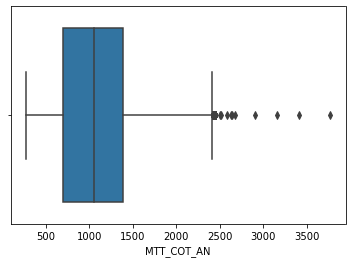

In [50]:
## Distribution du montant de cotisation

sns.boxplot(data=df_etude, x="MTT_COT_AN")

In [ ]:
## Distribution de l'age

fig = px.box(df_etude, x="Age")
fig.update_traces(boxmean=True)
fig.show()

In [46]:
## corrélation entre l'age et le montant de cotisation

spearmanr(df_etude["MTT_COT_AN"],df_etude["Age"], alternative="greater")

SignificanceResult(statistic=0.5854788292804954, pvalue=0.0)

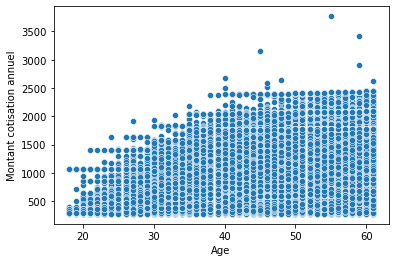

In [47]:
## Nuage de point  entre Age et le montant de cotisation

sns.scatterplot(data=df_etude, x="Age", y="MTT_COT_AN")

plt.xlabel("Age")

plt.ylabel("Montant cotisation annuel")

plt.show()

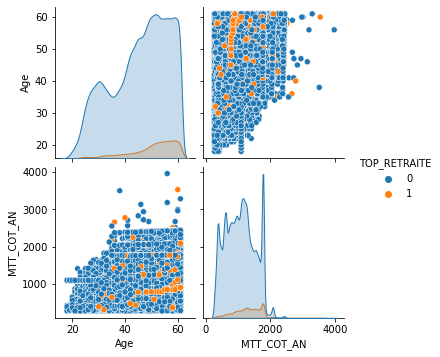

In [8]:
## adhérent ayant soucrit ou pas à la retraite en fonction de l'age et du montant

sns.pairplot(data=df_etude[["Age","MTT_COT_AN","TOP_RETRAITE"]], hue="TOP_RETRAITE")

In [12]:
Counter(df_etude["TOP_RETRAITE"])

Counter({'0': 608101, '1': 854})

In [273]:
df_etude["TYPE_COTISATION"].value_counts()

Taux        454406
Plafond      51885
Forfait      47403
Plancher     31512
Name: TYPE_COTISATION, dtype: int64

In [15]:
## test de khi-2 entre NAT_ACTIVITE et TYPE_COTISATION
## le premier element cest la statistique de test et le second élément c'est la p-value

chi2_contingency(pd.crosstab(df_etude["NAT_ACTIVITE"], df_etude["TYPE_COTISATION"]))[:2]

(129189.7289439463, 0.0)

In [48]:
## Calcul du v_cramer entre "NAT_ACTIVITE" et "TYPE_COTISATION"

nbre_mod_x=df_etude["NAT_ACTIVITE"].nunique()

nbre_mod_y=df_etude["TYPE_COTISATION"].nunique()

df1=pd.crosstab(df_etude["NAT_ACTIVITE"],df_etude["TYPE_COTISATION"])

chi2=chi2_contingency(df1)[0]

N=df_etude.shape[0]

round(np.sqrt(chi2/(N*(min(nbre_mod_x,nbre_mod_y)-1))),2)

0.33

Text(0, 0.5, 'Type de cotisation')

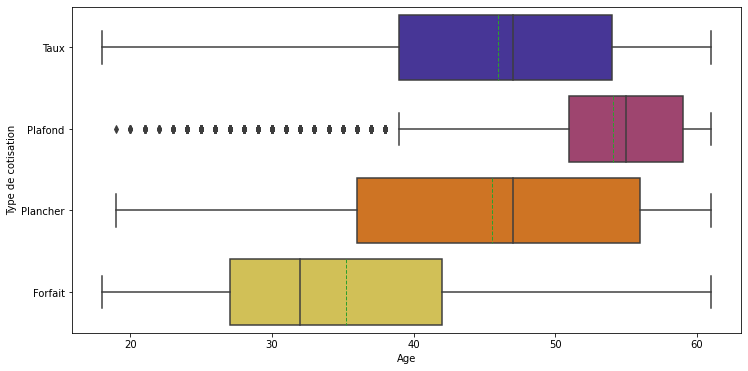

In [49]:
## Distribution de l'age en fonction du type

plt.figure(figsize=(12,6))
sns.boxplot(data=df_etude, y="TYPE_COTISATION",x="Age", orient='h',showmeans=True,palette="CMRmap",
            meanline=True)
plt.xlabel("Age")
plt.ylabel("Type de cotisation")

In [ ]:
## fait la même chose que précedemment

fig = px.box(df_etude, y="TYPE_COTISATION",x="Age")

fig.update_traces(boxmean=True)

fig.update_xaxes(title="Age")

fig.update_yaxes(title="Type de cotisation")

fig.show()

In [52]:
## fait le test de kruskal wallis pour tester s'il ya une difference significative d'age entre les differents
## types de cotisation

kruskal(df_etude.loc[(df_etude["TYPE_COTISATION"]=="Taux"),"Age"],
        df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plafond"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Forfait"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plancher"),"Age"])

KruskalResult(statistic=70411.00779980142, pvalue=0.0)

In [277]:
## réalise un test de Dunn avec ajustement de bonferroni pour relever les groupes où la difference 
## significative est averée

sp.posthoc_dunn([df_etude.loc[(df_etude["TYPE_COTISATION"]=="Taux"),"Age"],
        df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plafond"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Forfait"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plancher"),"Age"]], p_adjust = 'bonferroni')


,1,2
1,1.000000e+00,1.946164e-84
2,1.946164e-84,1.000000e+00


In [256]:
import scikit_posthocs as sp

## test de kruskal wallis

kruskal(df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Actif"),"MTT_COT_AN"],
        df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Retraité"),"MTT_COT_AN"],
       df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Scolarité"),"MTT_COT_AN"])

### Test de Dunn

sp.posthoc_dunn([df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Actif"),"MTT_COT_AN"],
        df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Retraité"),"MTT_COT_AN"],
       df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Scolarité"),"MTT_COT_AN"]], p_adjust = 'bonferroni')

### test shapiro

shapiro(df_etude["MTT_COT_AN"])

,1,2,3
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0


In [40]:
#Counter(df_etude["TOP_RETRAITE"])

In [16]:
## Proportion des équipements

TOP = [col for col in df_etude.columns if col.startswith("TOP")]

df_agg = df_etude[TOP].agg(lambda x: round(x.value_counts(normalize=True),4)*100)

df_agg

df_agg = df_agg.T.reset_index()

#df_agg.columns.name = "Equipement"

,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE
0,99.83,97.08,99.39,81.92,88.29,99.14,97.65,99.86
1,0.17,2.92,0.61,18.08,11.71,0.86,2.35,0.14


In [153]:
#px.bar(df_agg, x="index", y=["0","1"], text_auto=True)

In [21]:
#px.bar(df_agg, x="index",color="0",barmode="stack")



plot = go.Figure(data=[go.Bar(
    name = 'Non',
    x = df_agg["index"],
    y = df_agg["0"], text=list(map(lambda x: f"{x:.2f}%",list(df_agg["0"]))),textposition="auto"
   ),
                       go.Bar(
    name = 'Oui',
    x = df_agg["index"],
    y = df_agg["1"], text=list(map(lambda x: f"{x:.2f}%",list(df_agg["1"]))),textposition="auto"
   )
])

plot.update_layout(barmode='stack',legend_title_text='Equipé')

plot.update_yaxes(title="Pourcentage")

#plot.update_xaxes(title="Offres Additionnelles",tickvals=list(range(len(df_agg["index"]))), ticktext=["Tout Habitat","Tout Habitat MGEN","Assurance Retraite",
 #                                               "Assurance Décès","Prêt Installation MGEN","Assurance Obsèques","CAM","Assurance Vie",
 #                                                                                                     "Protection Juridique","Santé Animale"],
 #                categoryorder='max ascending')
    

plot.update_xaxes(title="Offres Additionnelles",categoryorder='max ascending')
                  
plot.show()

<AxesSubplot:ylabel='FORMULE'>

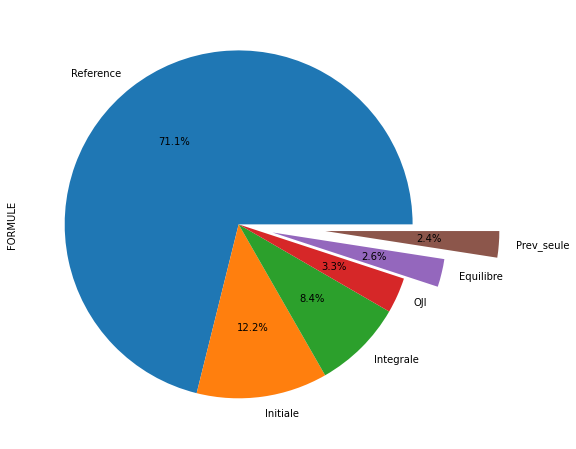

In [187]:
## proportion pour la "formule"

plt.figure(figsize=(10,8))
df_etude["FORMULE"].value_counts(normalize=True).plot(kind="pie",autopct="%.1f%%",explode=[0,0,0,0,0.2,0.5])

<div class='alert alert-info'>
    <center> <h3> Analyse Statistique</h3> </center>
</div>

In [92]:
## récupération de la classe de chaque colonne

clas = []

for colonne in df_etude:
    
    binaire = "Binaire" if df_etude[colonne].nunique()==2 else "Non_Binaire"
    
    clas.append((colonne, str(type(df_etude[colonne][0]))[7:-1], binaire))
    
class_total = pd.DataFrame(clas, columns=["Colonne","Type","Nbre_elem"])

class_total.head()

,Colonne,Type,Nbre_elem
0,NOIDE,'str',Non_Binaire
1,TOP_ASSUR_VIE,'str',Binaire
2,Age,'numpy.int64',Non_Binaire
3,TOP_DECES,'str',Binaire
4,TOP_CAM,'str',Binaire


In [54]:
## liste des variables quantitatives

list(class_total.loc[class_total["Type"]!="'str'","Colonne"])

['Age',
 'Nbre_canaux_dispo',
 'Anciennete',
 'MTT_COT_AN',
 'INTER_MAIL',
 'TOTAL_INTER_CANAL',
 'Nbre_Camp_Fid',
 'Nbre_Camp_Multiequip',
 'Nbre_Total_Camp']

In [55]:
## V_cramer entre les variables qualitatives

dummies_var = list(class_total.loc[class_total["Type"]=="'str'","Colonne"])[1:]

V_de_cramer =[]

for var1 in dummies_var:
    
    cramer = []
    
    nbre_mod_x=df_etude[var1].nunique()
    
    for var2 in dummies_var:
        
        nbre_mod_y=df_etude[var2].nunique()
        
        df1=pd.crosstab(df_etude[var1],df_etude[var2])
        
        chi2=chi2_contingency(df1)[0]
        
        N=df_etude.shape[0]
        
        cramer.append(round(np.sqrt(chi2/(N*(min(nbre_mod_x,nbre_mod_y)-1))),1))
        
    V_de_cramer.append(cramer)
        
df_cramer = pd.DataFrame(V_de_cramer, columns=dummies_var, index=dummies_var) 

df_cramer.head()

,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,FORMULE,CODSEX,COUVRE_BE,COUVRE_BC,TYPE_COTISATION,REGION,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,chgt_tr_cotis_n-1_n,chgt_tr_cotis_n-2_n-1,evol_cotis_n-1_n,evol_cotis_n-2_n-1,nb_evolution,nb_baisse,PROPO_Courrier_disc,PROPO_FACEAFACE_disc,PROPO_INTERNET_disc,PROPO_Mail_disc,PROPO_TELEPHONE_disc,Devis_Assur_Décès_disc,Devis_Assur_Obs_disc,Devis_Assur_Vie_disc,Devis_CAM_disc,Devis_Epargne_retraite_disc,Devis_PIM_disc,Nbre_Devis_Hors_Retr_disc,Nbre_Equip_Hors_Retr_disc,Nbre_canaux_Devis_disc,NB_RECLA_disc,INTER_COURRIER_disc,INTER_SMS_disc,INTER_TEL_disc,Nbre_Camp_Conq_disc
TOP_ASSUR_VIE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.4,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0
TOP_DECES,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.1,0.1,0.3,0.1,0.0,0.1,0.0,0.0,0.0
TOP_CAM,0.0,0.0,1.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.2,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0
TOP_TOUT_HABITAT,0.0,0.0,0.0,1.0,0.8,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.1,0.2,0.0,0.1,0.0,0.2,0.1,0.0,0.1,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.0,0.0,0.0,0.0,0.0
TOP_HABITAT_MGEN,0.0,0.0,0.0,0.8,1.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.6,0.0,0.0,0.0,0.0,0.0


In [56]:
## Calcul de la statistique de kolmogorov entre variable qualitatives et quantitatives

def kolmogorov(df, cible, liste_var):
    
    liste_ks = []
    
    for var in liste_var:
        
        liste_ks.append(kstest(df.loc[(df[cible]=="0"),var],df.loc[(df[cible]=="1"),var]))
        
    return pd.DataFrame(liste_ks, columns=[cible,"P_value"], index=liste_var)

## Appel de la fonction

df_kolmogorov = kolmogorov(df_etude, "TOP_RETRAITE", list(class_total.loc[class_total["Type"]!="'str'","Colonne"]))

df_kolmogorov

,TOP_RETRAITE,P_value
Age,0.508954,2.262857e-205
Nbre_canaux_dispo,0.117959,8.474141e-11
Anciennete,0.382434,1.060379e-112
MTT_COT_AN,0.368397,2.451382e-104
INTER_MAIL,0.119584,4.364119e-11
TOTAL_INTER_CANAL,0.086314,5.603627e-06
Nbre_Camp_Fid,0.070507,3.928757e-04
Nbre_Camp_Multiequip,0.087319,4.153335e-06
Nbre_Total_Camp,0.051036,2.268939e-02


In [18]:
df_kolmogorov

,TOP_RETRAITE,P_value
Age,0.230312,0.000000e+00
Nbre_canaux_dispo,0.023271,9.158564e-19
Anciennete,0.328986,0.000000e+00
MTT_COT_AN,0.216160,0.000000e+00
INTER_MAIL,0.087918,1.510965e-262
TOTAL_INTER_CANAL,0.095880,2.856257e-312
Nbre_Camp_Fid,0.100268,0.000000e+00
Nbre_Camp_Multiequip,0.076208,2.743459e-197
Nbre_Total_Camp,0.103981,0.000000e+00


In [ ]:
## Variable avec le v_cramer plus grand avec la variable cible

fig = px.bar(df_cramer[df_cramer["TOP_RETRAITE"].between(0.01,0.1)],x="TOP_RETRAITE", text_auto=True)

fig.update_yaxes(title="Variables",categoryorder='total ascending',tickvals=list(range(6,-1,-1)),
                 ticktext=["Nombre contact courrier",
                "Fréquence moyenne contact courrier/mois","Type de cotisation","Formule","Changement type de cotisation de 2020-2021",
                "évolution montant cotisation de 2020-2021","Nature d'activité"])

fig.update_xaxes(title="V-cramer")

fig.show()

In [ ]:
## Variable avec la statistique de kolmogorov plus grande avec la variable cible

fig = px.bar(df_kolmogorov[df_kolmogorov["P_value"]<.05],x="TOP_RETRAITE", text_auto='.2f')

fig.update_yaxes(title="Variables",categoryorder='total ascending',tickvals=list(range(8,-1,-1)),
                 ticktext=["Âge","Ancienneté",
                "Montant annuelle cotisation","Nombre total de contact email reçu","Nombre de canaux de contact disponible","Nombre de campagne de multi-équipements",
                "Nombre total de contact de campagne", "Nombre de campagne de Fidélisation reçu","Nombre total de campagne reçu hors retraite"
                ])

fig.update_xaxes(title="Statistique de Kolmogorov")

fig.show()

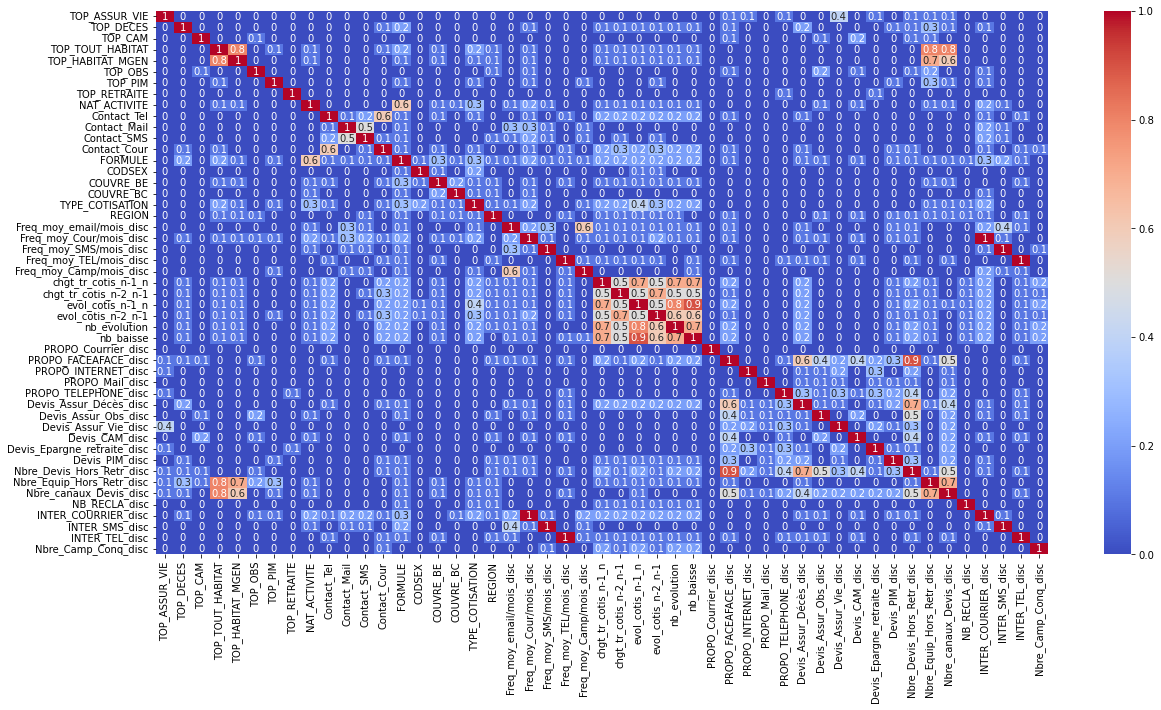

In [69]:
## plot heatmap

plt.rcParams["figure.figsize"]=[20,10]

sns.heatmap(df_cramer,annot=True, cmap="coolwarm")

plt.show()

<div class='alert alert-info'>
    <center> <h3> Clustering de variables</h3> </center>
</div>

In [81]:
# récupération des variables avec un v_cramer>0.5

col_cramer = []
for col1 in df_cramer.columns:
    for col2 in df_cramer.columns:
        if col1!=col2 and df_cramer.loc[col1,col2]>0.5:
            col_cramer.append(col1)
            
## dédoublonnages des variables
col_cramer = list(set(col_cramer))

In [87]:
## dataframe de v_cramer des variables avec v_cramer>0.5

df_cramer_associe = df_cramer.loc[col_cramer,col_cramer].copy()

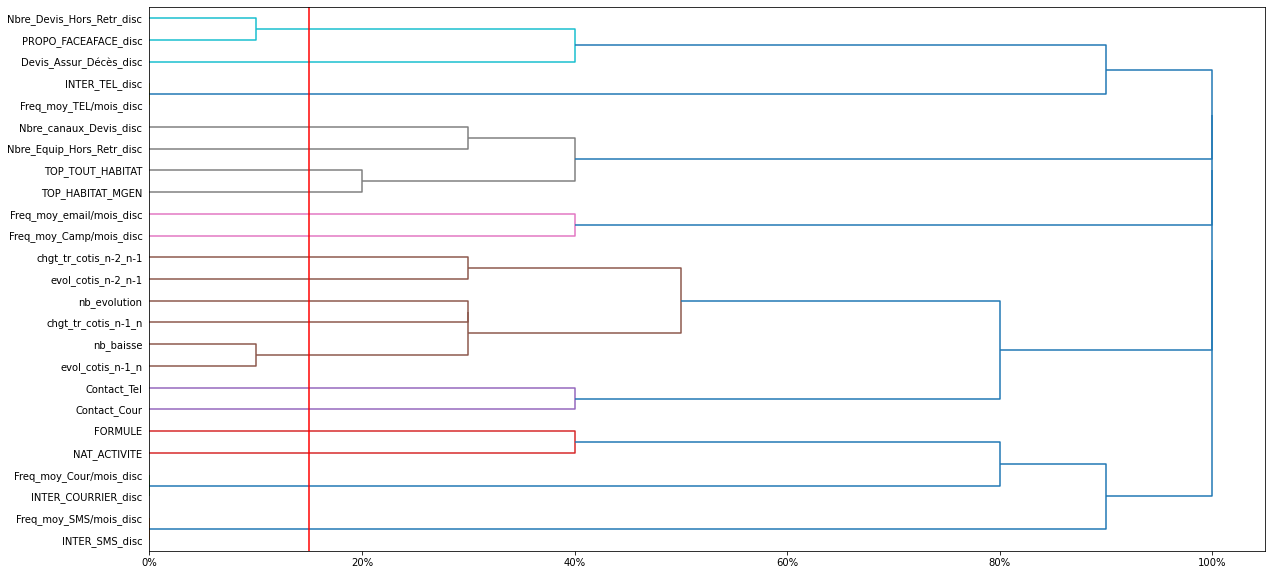

In [88]:
## clustering de variables avec seuil de 0.15

plt.rcParams["figure.figsize"]=[20,10]

figure = pyplot.figure()

axes = figure.add_subplot(111)

dist = squareform(1-abs(df_cramer_associe))

corr_linkage = hierarchy.complete(dist)

dendro = hierarchy.dendrogram(
    corr_linkage,
    orientation="right",
    labels=df_cramer_associe.columns
)

plt.axvline(0.15, c='r')

#axes.yaxis.set_ticklabels(["Nombre contact SMS discrétisé","Fréquence moyenne contact SMS/mois discrétisé","Nombre contact courrier discrétisé",
#                         "Fréquence moyenne contact courrier/mois discrétisé","Nombre équipement hors retraite discrétisé","offre Tout habitat",
#                          "Nombre de devis hors retraite discrétisé","Nombre devis fait face à face discrétisé",
#                           "Nombre d'évolution cotisation discrétisé","Evolution cotisation 2021-2022","Nombre de contact téléphonique discrétisé",
#                          "Fréquence moyenne contact Téléphone/mois discrétisé"][::-1])

axes.xaxis.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

plt.show()

In [89]:
# Définition du seuil de corrélation

threshold_for_cluster_creation = 0.15

var = df_cramer_associe.columns

# Récupération des clusters à partir de la hiérarchie

cluster_ids = hierarchy.fcluster(corr_linkage, threshold_for_cluster_creation, criterion='distance')

cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
clusters = [ list(v) for v in cluster_id_to_feature_ids.values() if len(v) >1]

clusters_col = [list(var[i] for i in v) for v in clusters]

# On ne conservera que la variable la plus associée à la variable cible dans chaque cluster, les autres sont retirées

print(f"les clusters au seuil de {threshold_for_cluster_creation} sont \n\n {clusters_col}")

les clusters au seuil de 0.15 sont 

 [['Freq_moy_TEL/mois_disc', 'INTER_TEL_disc'], ['PROPO_FACEAFACE_disc', 'Nbre_Devis_Hors_Retr_disc'], ['INTER_COURRIER_disc', 'Freq_moy_Cour/mois_disc'], ['evol_cotis_n-1_n', 'nb_baisse'], ['INTER_SMS_disc', 'Freq_moy_SMS/mois_disc']]


## Ne pas executer ici

In [123]:
## trnasformation des variables en qualitatives en dummies variables

dummies_var = list(class_total.loc[class_total["Type"]=="'str'","Colonne"])[1:]

int_var = ["NOIDE"]+list(class_total.loc[class_total["Type"]!="'str'","Colonne"])

var_binaire = list(class_total.loc[class_total["Nbre_elem"]=="Binaire","Colonne"])

df1 = pd.get_dummies(df_etude[dummies_var], prefix=dummies_var)

for colonne in var_binaire:
    
    try:
        
        df1.drop(colonne+"_0", axis=1, inplace=True)
        
        df1.rename(columns={colonne+"_1":colonne}, inplace=True)
        
    except KeyError:
        
        try:
            
            df1.drop(colonne+"_Aucun", axis=1, inplace=True)
            
        except KeyError:
            
            try:
            
                df1.drop(colonne+"_F", axis=1, inplace=True)

                df1.rename(columns={colonne+"_M":"SEXE"}, inplace=True)
                
            except KeyError:
                
                df1.drop(colonne+"_Aucune", axis=1, inplace=True)

    #finally:
      #  print("le groupe try except est terminé")
    
df1.head()

,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,NAT_ACTIVITE_Actif,NAT_ACTIVITE_Retraité,NAT_ACTIVITE_Scolarité,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,FORMULE_Equilibre,FORMULE_Initiale,FORMULE_Integrale,FORMULE_OJI,FORMULE_Prev_seule,FORMULE_Reference,SEXE,COUVRE_BE,COUVRE_BC,TYPE_COTISATION_Forfait,TYPE_COTISATION_Plafond,TYPE_COTISATION_Plancher,TYPE_COTISATION_Taux,REGION_Aquitaine,REGION_Auvergne,REGION_Bourgogne Franche Comté,REGION_Bretagne,REGION_Centre,REGION_DFA,REGION_Grand Est,REGION_Hauts De France,REGION_ILE DE France,REGION_Languedoc/Roussillon,REGION_Limousin/Poitou Charentes,REGION_Midi Pyrénées,REGION_Normandie,REGION_PACA Corse,REGION_Pays de la Loire,REGION_Rhône Alpes,REGION_S. E. M.,REGION_ZOI,Freq_moy_email/mois_disc_1_mail/mois,Freq_moy_email/mois_disc_Aucun_mail/mois,Freq_moy_email/mois_disc_ciblé_1_fois,Freq_moy_email/mois_disc_plus_2mails/mois,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,Freq_moy_Cour/mois_disc_ciblé_1_fois,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,Freq_moy_SMS/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_Camp/mois_disc_ciblé_1_fois,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,chgt_tr_cotis_21-22_0,chgt_tr_cotis_21-22_1,chgt_tr_cotis_21-22_NC,chgt_tr_cotis_20-21_0,chgt_tr_cotis_20-21_1,chgt_tr_cotis_20-21_NC,evol_cotis_21-22_NC,evol_cotis_21-22_baisse,evol_cotis_21-22_stable,evol_cotis_21-22_évolution,evol_cotis_20-21_NC,evol_cotis_20-21_baisse,evol_cotis_20-21_stable,evol_cotis_20-21_évolution,nb_evolution_1_et_plus,nb_evolution_Aucune,nb_evolution_NC,nb_baisse_1_et_plus,nb_baisse_Aucune,nb_baisse_NC,PROPO_Courrier_disc_Au_moins_1,PROPO_FACEAFACE_disc_Au_moins_1,PROPO_INTERNET_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,Devis_Assur_Décès_disc_Au_moins_1,Devis_Assur_Obs_disc_Au_moins_1,Devis_Assur_Vie_disc_Au_moins_1,Devis_CAM_disc_Au_moins_1,Devis_Epargne_retraite_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Devis_Protect_Juriq_disc_Au_moins_1,Devis_Sante_Animale_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,Nbre_Equip_Hors_Retr_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,NB_RECLA_disc_Au_moins_1,INTER_COURRIER_disc_Au_moins_1,INTER_SMS_disc_Au_moins_1,INTER_TEL_disc_Au_moins_1,Nbre_Camp_Conq_disc_Au_moins_1
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0


## SEXE=1 si masculin et 0 si femme

In [124]:
## concaténation des dataframes pour un dataframe dummy

df_etude_dummy = pd.concat([df_etude[int_var],df1], axis=1)

df_etude_dummy.head()

,NOIDE,Age,Nbre_canaux_dispo,Anciennete,MTT_COT_AN,INTER_MAIL,TOTAL_INTER_CANAL,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,NAT_ACTIVITE_Actif,NAT_ACTIVITE_Retraité,NAT_ACTIVITE_Scolarité,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,FORMULE_Equilibre,FORMULE_Initiale,FORMULE_Integrale,FORMULE_OJI,FORMULE_Prev_seule,FORMULE_Reference,SEXE,COUVRE_BE,COUVRE_BC,TYPE_COTISATION_Forfait,TYPE_COTISATION_Plafond,TYPE_COTISATION_Plancher,TYPE_COTISATION_Taux,REGION_Aquitaine,REGION_Auvergne,REGION_Bourgogne Franche Comté,REGION_Bretagne,REGION_Centre,REGION_DFA,REGION_Grand Est,REGION_Hauts De France,REGION_ILE DE France,REGION_Languedoc/Roussillon,REGION_Limousin/Poitou Charentes,REGION_Midi Pyrénées,REGION_Normandie,REGION_PACA Corse,REGION_Pays de la Loire,REGION_Rhône Alpes,REGION_S. E. M.,REGION_ZOI,Freq_moy_email/mois_disc_1_mail/mois,Freq_moy_email/mois_disc_Aucun_mail/mois,Freq_moy_email/mois_disc_ciblé_1_fois,Freq_moy_email/mois_disc_plus_2mails/mois,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,Freq_moy_Cour/mois_disc_ciblé_1_fois,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,Freq_moy_SMS/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_Camp/mois_disc_ciblé_1_fois,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,chgt_tr_cotis_21-22_0,chgt_tr_cotis_21-22_1,chgt_tr_cotis_21-22_NC,chgt_tr_cotis_20-21_0,chgt_tr_cotis_20-21_1,chgt_tr_cotis_20-21_NC,evol_cotis_21-22_NC,evol_cotis_21-22_baisse,evol_cotis_21-22_stable,evol_cotis_21-22_évolution,evol_cotis_20-21_NC,evol_cotis_20-21_baisse,evol_cotis_20-21_stable,evol_cotis_20-21_évolution,nb_evolution_1_et_plus,nb_evolution_Aucune,nb_evolution_NC,nb_baisse_1_et_plus,nb_baisse_Aucune,nb_baisse_NC,PROPO_Courrier_disc_Au_moins_1,PROPO_FACEAFACE_disc_Au_moins_1,PROPO_INTERNET_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,Devis_Assur_Décès_disc_Au_moins_1,Devis_Assur_Obs_disc_Au_moins_1,Devis_Assur_Vie_disc_Au_moins_1,Devis_CAM_disc_Au_moins_1,Devis_Epargne_retraite_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Devis_Protect_Juriq_disc_Au_moins_1,Devis_Sante_Animale_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,Nbre_Equip_Hors_Retr_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,NB_RECLA_disc_Au_moins_1,INTER_COURRIER_disc_Au_moins_1,INTER_SMS_disc_Au_moins_1,INTER_TEL_disc_Au_moins_1,Nbre_Camp_Conq_disc_Au_moins_1
0,0106458830,39,0,13.0,996.24,9.0,9.0,9.0,1.0,10.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0
1,0108106495,36,4,6.0,817.92,15.0,15.0,12.0,4.0,16.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
2,0105015422,45,4,10.0,1148.76,14.0,14.0,12.0,2.0,14.0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
3,0103711625,50,4,26.0,1257.12,20.0,22.0,20.0,2.0,22.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0
4,0105608656,25,0,1.0,362.28,5.0,5.0,5.0,0.0,5.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0


In [64]:
## charger la base d'etude ici

#df_etude_dummy.to_csv("df_apprentissage_2020_12_31.csv", index=False, encoding="mbcs")

df_etude_dummy = pd.read_csv("df_apprentissage_2020_12_31.csv",encoding="mbcs",dtype={"NOIDE":str})

df_etude_dummy.head()

,NOIDE,Age,Nbre_canaux_dispo,Anciennete,MTT_COT_AN,INTER_MAIL,TOTAL_INTER_CANAL,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,NAT_ACTIVITE_Actif,NAT_ACTIVITE_Retraité,NAT_ACTIVITE_Scolarité,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,FORMULE_Equilibre,FORMULE_Initiale,FORMULE_Integrale,FORMULE_OJI,FORMULE_Prev_seule,FORMULE_Reference,SEXE,COUVRE_BE,COUVRE_BC,TYPE_COTISATION_Forfait,TYPE_COTISATION_Plafond,TYPE_COTISATION_Plancher,TYPE_COTISATION_Taux,REGION_Aquitaine,REGION_Auvergne,REGION_Bourgogne Franche Comté,REGION_Bretagne,REGION_Centre,REGION_DFA,REGION_Grand Est,REGION_Hauts De France,REGION_ILE DE France,REGION_Languedoc/Roussillon,REGION_Limousin/Poitou Charentes,REGION_Midi Pyrénées,REGION_Normandie,REGION_PACA Corse,REGION_Pays de la Loire,REGION_Rhône Alpes,REGION_S. E. M.,REGION_ZOI,Freq_moy_email/mois_disc_1_mail/mois,Freq_moy_email/mois_disc_Aucun_mail/mois,Freq_moy_email/mois_disc_ciblé_1_fois,Freq_moy_email/mois_disc_plus_2mails/mois,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,Freq_moy_Cour/mois_disc_ciblé_1_fois,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,Freq_moy_SMS/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_Camp/mois_disc_ciblé_1_fois,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,chgt_tr_cotis_21-22_0,chgt_tr_cotis_21-22_1,chgt_tr_cotis_21-22_NC,chgt_tr_cotis_20-21_0,chgt_tr_cotis_20-21_1,chgt_tr_cotis_20-21_NC,evol_cotis_21-22_NC,evol_cotis_21-22_baisse,evol_cotis_21-22_stable,evol_cotis_21-22_évolution,evol_cotis_20-21_NC,evol_cotis_20-21_baisse,evol_cotis_20-21_stable,evol_cotis_20-21_évolution,nb_evolution_1_et_plus,nb_evolution_Aucune,nb_evolution_NC,nb_baisse_1_et_plus,nb_baisse_Aucune,nb_baisse_NC,PROPO_Courrier_disc_Au_moins_1,PROPO_FACEAFACE_disc_Au_moins_1,PROPO_INTERNET_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,Devis_Assur_Décès_disc_Au_moins_1,Devis_Assur_Obs_disc_Au_moins_1,Devis_Assur_Vie_disc_Au_moins_1,Devis_CAM_disc_Au_moins_1,Devis_Epargne_retraite_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Devis_Protect_Juriq_disc_Au_moins_1,Devis_Sante_Animale_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,Nbre_Equip_Hors_Retr_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,NB_RECLA_disc_Au_moins_1,INTER_COURRIER_disc_Au_moins_1,INTER_SMS_disc_Au_moins_1,INTER_TEL_disc_Au_moins_1,Nbre_Camp_Conq_disc_Au_moins_1
0,0106458830,39,0,13.0,996.24,9.0,9.0,9.0,1.0,10.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0
1,0108106495,36,4,6.0,817.92,15.0,15.0,12.0,4.0,16.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
2,0105015422,45,4,10.0,1148.76,14.0,14.0,12.0,2.0,14.0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
3,0103711625,50,4,26.0,1257.12,20.0,22.0,20.0,2.0,22.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0
4,0105608656,25,0,1.0,362.28,5.0,5.0,5.0,0.0,5.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0


In [67]:
#df_etude_dummy.loc[df_etude_dummy["TOP_RETRAITE"]==0,"NOIDE"]

In [4]:
#df_etude_dummy.drop("Devis_Epargne_retraite",axis=1,inplace=True)

In [5]:
df_etude_undersample = df_etude_dummy.drop("NOIDE",axis=1).copy()

print(df_etude_undersample.shape)

df_etude_undersample.head()

(882417, 114)


,Age,Nbre_canaux_dispo,Anciennete,MTT_COT_AN,INTER_MAIL,TOTAL_INTER_CANAL,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,NAT_ACTIVITE_Actif,NAT_ACTIVITE_Retraité,NAT_ACTIVITE_Scolarité,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,FORMULE_Equilibre,FORMULE_Initiale,FORMULE_Integrale,FORMULE_OJI,FORMULE_Prev_seule,FORMULE_Reference,SEXE,COUVRE_BE,COUVRE_BC,TYPE_COTISATION_Forfait,TYPE_COTISATION_Plafond,TYPE_COTISATION_Plancher,TYPE_COTISATION_Taux,REGION_Aquitaine,REGION_Auvergne,REGION_Bourgogne Franche Comté,REGION_Bretagne,REGION_Centre,REGION_DFA,REGION_Grand Est,REGION_Hauts De France,REGION_ILE DE France,REGION_Languedoc/Roussillon,REGION_Limousin/Poitou Charentes,REGION_Midi Pyrénées,REGION_Normandie,REGION_PACA Corse,REGION_Pays de la Loire,REGION_Rhône Alpes,REGION_S. E. M.,REGION_ZOI,Freq_moy_email/mois_disc_1_mail/mois,Freq_moy_email/mois_disc_Aucun_mail/mois,Freq_moy_email/mois_disc_ciblé_1_fois,Freq_moy_email/mois_disc_plus_2mails/mois,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,Freq_moy_Cour/mois_disc_ciblé_1_fois,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,Freq_moy_SMS/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_Camp/mois_disc_ciblé_1_fois,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,chgt_tr_cotis_21-22_0,chgt_tr_cotis_21-22_1,chgt_tr_cotis_21-22_NC,chgt_tr_cotis_20-21_0,chgt_tr_cotis_20-21_1,chgt_tr_cotis_20-21_NC,evol_cotis_21-22_NC,evol_cotis_21-22_baisse,evol_cotis_21-22_stable,evol_cotis_21-22_évolution,evol_cotis_20-21_NC,evol_cotis_20-21_baisse,evol_cotis_20-21_stable,evol_cotis_20-21_évolution,nb_evolution_1_et_plus,nb_evolution_Aucune,nb_evolution_NC,nb_baisse_1_et_plus,nb_baisse_Aucune,nb_baisse_NC,PROPO_Courrier_disc_Au_moins_1,PROPO_FACEAFACE_disc_Au_moins_1,PROPO_INTERNET_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,Devis_Assur_Décès_disc_Au_moins_1,Devis_Assur_Obs_disc_Au_moins_1,Devis_Assur_Vie_disc_Au_moins_1,Devis_CAM_disc_Au_moins_1,Devis_Epargne_retraite_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Devis_Protect_Juriq_disc_Au_moins_1,Devis_Sante_Animale_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,Nbre_Equip_Hors_Retr_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,NB_RECLA_disc_Au_moins_1,INTER_COURRIER_disc_Au_moins_1,INTER_SMS_disc_Au_moins_1,INTER_TEL_disc_Au_moins_1,Nbre_Camp_Conq_disc_Au_moins_1
0,39,0,13.0,996.24,9.0,9.0,9.0,1.0,10.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0
1,36,4,6.0,817.92,15.0,15.0,12.0,4.0,16.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
2,45,4,10.0,1148.76,14.0,14.0,12.0,2.0,14.0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0
3,50,4,26.0,1257.12,20.0,22.0,20.0,2.0,22.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0
4,25,0,1.0,362.28,5.0,5.0,5.0,0.0,5.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0


## continuer ici

In [99]:
## Variables continue

#int_var = ['NOIDE',"Age","Nbre_canaux_dispo","Anciennete","MTT_COT_AN","INTER_MAIL","TOTAL_INTER_CANAL","Nbre_Camp_Fid",
#       "Nbre_Camp_Multiequip","Nbre_Total_Camp"]

int_var = list(class_total.loc[class_total["Type"]!="'str'","Colonne"])

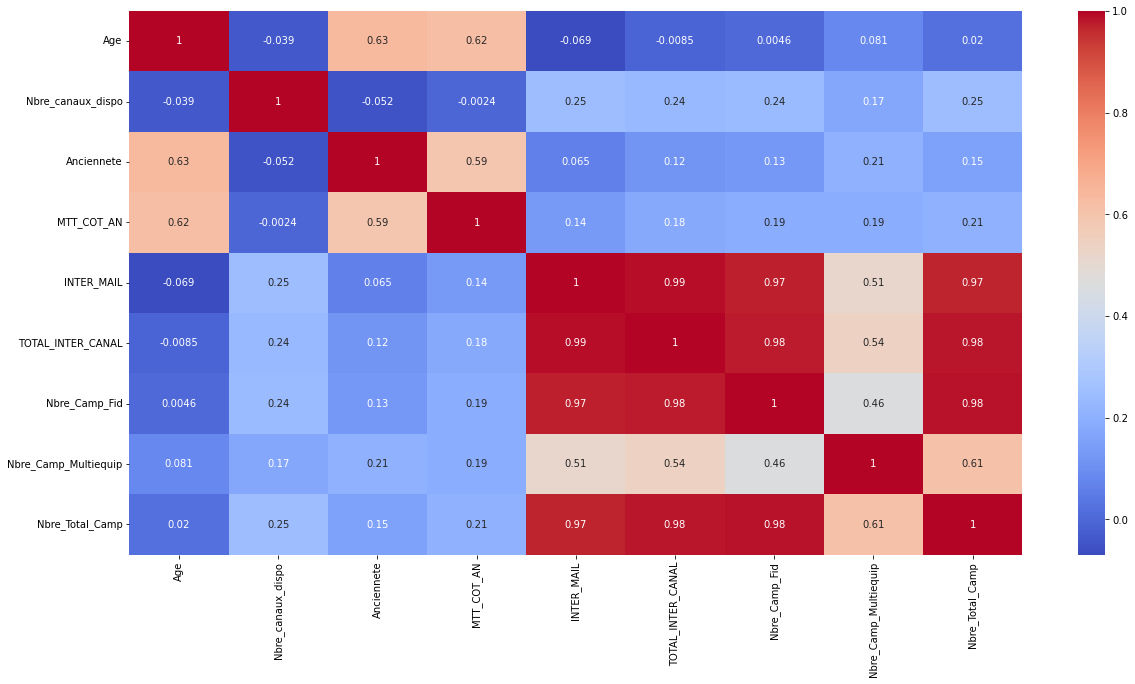

In [100]:
df = df_etude[int_var].corr().copy()

plt.rcParams["figure.figsize"]=[20,10]

sns.heatmap(df,annot=True, cmap="coolwarm")

plt.show()

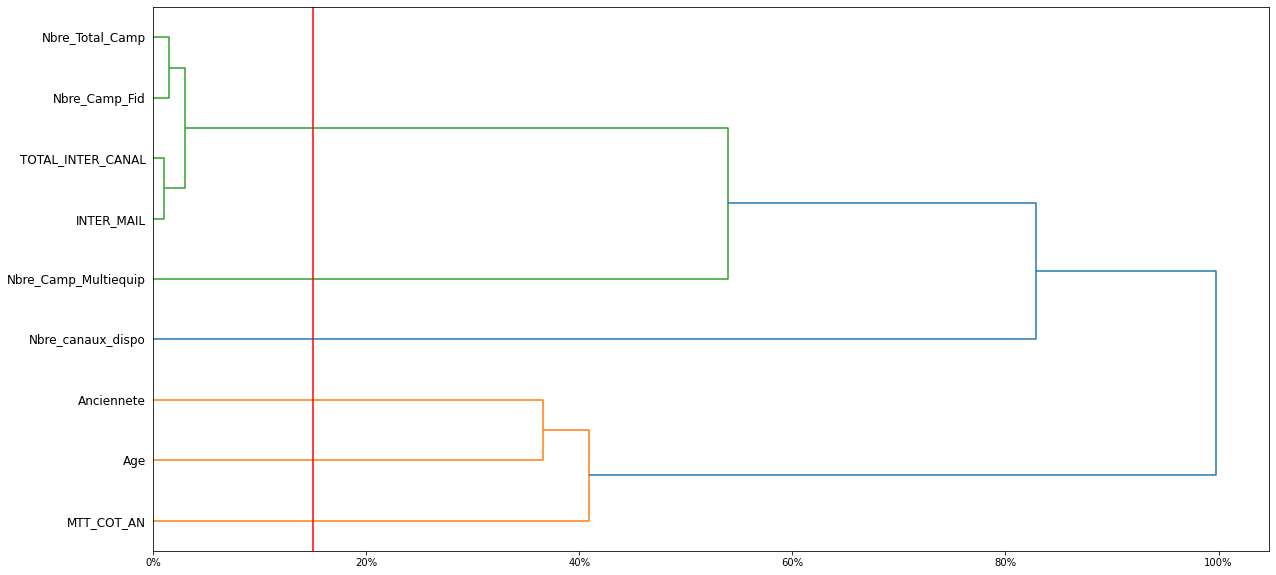

In [101]:
figure = pyplot.figure()

axes = figure.add_subplot(111)

dist = squareform(1-abs(df))

corr_linkage = hierarchy.complete(dist)

dendro = hierarchy.dendrogram(
    corr_linkage,
    orientation="right",
    labels=df.columns
)
plt.axvline(0.15, c='r')

#axes.yaxis.set_ticklabels(["Nombre Total campagne reçu","Total campagne de Fidélisation","Total contact tout canaux",
#                         "Nombre total contact email","Total campagne de multi-équipements","Total canaux disponible",
#                          "Ancienneté","Age","Montant de cotisation annuel"][::-1])

axes.xaxis.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

plt.show()

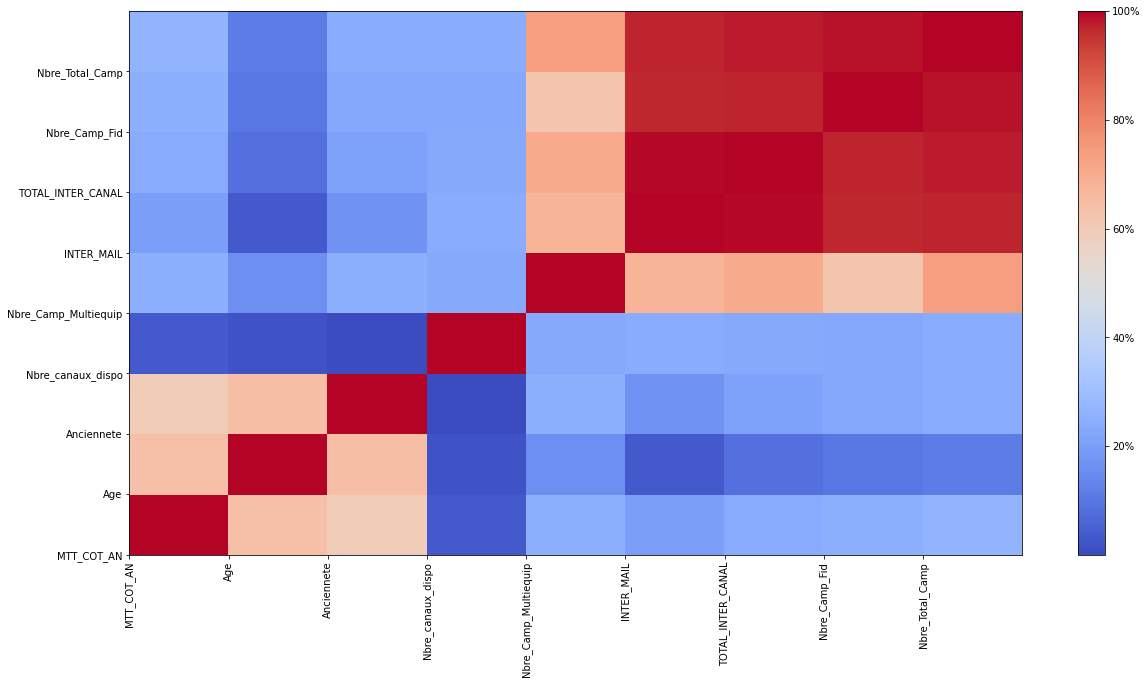

In [32]:
corr1=df.to_numpy()

fig = plt.figure()

ax = fig.add_subplot(1,1,1)

plot = ax.pcolor(abs(corr1[dendro["leaves"],:][:,dendro["leaves"]]), cmap="coolwarm")

dendro_idx = np.arange(0, len(dendro["ivl"]))

ax.set_xticks(dendro_idx)

ax.set_yticks(dendro_idx)

ax.set_xticklabels(dendro["ivl"], rotation='vertical')

ax.set_yticklabels(dendro["ivl"])

cbar = fig.colorbar(plot, format=ticker.PercentFormatter(xmax=1))

In [108]:
#df_etude[["INTER_MAIL","Nbre_Total_Camp","Nbre_Camp_Fid","TOTAL_INTER_CANAL"]].corr()

In [102]:
### fonction pour la sélection des variables

def selection_variable(df,liste_var,cible,type_var):
    
    var_sup = []
    
    if type_var=="quali":
    
        for group in liste_var:

            stat = []

            for var in group:

                stat.append(df.loc[cible,var])

            non_sup = stat.index(max(stat))  ## index variable à ne pas supprimer

            del(group[non_sup])

            var_sup = var_sup + group
            
    else:
        
        for group in liste_var:
            
            stat = []
            
            for var in group:
                
                stat.append(kstest(df.loc[(df[cible]=="0"),var],df.loc[(df[cible]=="1"),var])[0])
                
            non_sup = stat.index(max(stat))
            
            del(group[non_sup])
            
            var_sup = var_sup+group
         
    return var_sup

In [103]:
### Liste des variables quali ou quanti à supprimer

liste_var_group = [['Freq_moy_TEL/mois_disc', 'INTER_TEL_disc'], ['PROPO_FACEAFACE_disc', 'Nbre_Devis_Hors_Retr_disc'], ['INTER_COURRIER_disc', 'Freq_moy_Cour/mois_disc'],
                   ['evol_cotis_n-1_n', 'nb_baisse'], ['INTER_SMS_disc', 'Freq_moy_SMS/mois_disc']]

liste_quali_supp = selection_variable(df_cramer,liste_var_group,"TOP_RETRAITE","quali")

liste_quanti_supp = selection_variable(df_etude,[["INTER_MAIL","Nbre_Total_Camp","Nbre_Camp_Fid",
                                                   "TOTAL_INTER_CANAL"]],"TOP_RETRAITE","quanti")

In [104]:
liste_quanti_supp+liste_quali_supp

['Nbre_Total_Camp',
 'Nbre_Camp_Fid',
 'TOTAL_INTER_CANAL',
 'INTER_TEL_disc',
 'Nbre_Devis_Hors_Retr_disc',
 'Freq_moy_Cour/mois_disc',
 'nb_baisse',
 'Freq_moy_SMS/mois_disc']

In [6]:
## Variable à garder

int_var=['NOIDE', 'Age', 'Nbre_canaux_dispo', 'Anciennete', 'MTT_COT_AN', 'Nbre_Camp_Multiequip', 'Nbre_Total_Camp']

## Sous echantillonage aléatoire

In [5]:
X_train_disc = df_etude_undersample.drop(["TOP_RETRAITE","Devis_Epargne_retraite_disc_Au_moins_1"], axis=1).copy()

Y_train_disc = df_etude_undersample["TOP_RETRAITE"].copy()

counter = Counter(Y_train_disc)

print(counter)

rus = RandomUnderSampler(random_state=42)  ## pour figer l'échantillonage

X_res_disc, y_res_disc = rus.fit_resample(X_train_disc, Y_train_disc)

counter = Counter(y_res_disc)

print(counter)

Counter({0: 815538, 1: 66879})
Counter({0: 66879, 1: 66879})


## Sur echantillonage aléatoire

In [7]:
X_random_over = df_etude_undersample.drop(["TOP_RETRAITE","Devis_Epargne_retraite_disc_Au_moins_1"], axis=1).copy()

Y_random_over = df_etude_undersample["TOP_RETRAITE"].copy()

counter = Counter(Y_random_over)

print(counter)

rus = RandomOverSampler(random_state=42)

X_res_over, y_res_over = rus.fit_resample(X_random_over, Y_random_over)

counter = Counter(y_res_over)

print(counter)

Counter({0: 815538, 1: 66879})
Counter({0: 815538, 1: 815538})


## Smote

In [44]:
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]

for k in k_values:
    
    model = LogisticRegression()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(pipeline, X_random_over, Y_random_over, scoring='precision', cv=cv, n_jobs=-1)
    score = np.nanmean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.183
> k=2, Mean ROC AUC: 0.184
> k=3, Mean ROC AUC: 0.186
> k=4, Mean ROC AUC: 0.184
> k=5, Mean ROC AUC: 0.185
> k=6, Mean ROC AUC: 0.184
> k=7, Mean ROC AUC: 0.185


In [3]:
df_etude = pd.read_csv("df_pour_R_22_07.csv", encoding="mbcs", dtype={"NOIDE":str})

In [4]:
df_etude.head()

,NOIDE,Age,TOP_DECES,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Anciennete,FORMULE,CODSEX,TYPE_COTISATION,MTT_COT_AN,COUVRE_BE,COUVRE_BC,INTER_MAIL,TOTAL_INTER_CANAL,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,REGION,Devis_Assur_Décès_disc,Devis_Assur_Obs_disc,Devis_Assur_Vie_disc,Devis_CAM_disc,Devis_Epargne_retraite_disc,Devis_PIM_disc,PROPO_Courrier_disc,PROPO_FACEAFACE_disc,PROPO_INTERNET_disc,PROPO_Mail_disc,PROPO_TELEPHONE_disc,Nbre_Devis_Hors_Retr_disc,Nbre_Equip_Hors_Retr_disc,Nbre_canaux_Devis_disc,NB_RECLA_disc,INTER_COURRIER_disc,INTER_SMS_disc,INTER_TEL_disc,Nbre_Camp_Conq_disc,chgt_tr_cotis_22-23,chgt_tr_cotis_21-22,chgt_tr_cotis_20-21,evol_cotis_22-23,evol_cotis_21-22,evol_cotis_20-21,nb_evolution,nb_baisse
0,0106458830,40,0,0,0,0,0,Actif,0,0,0,0,0,14.0,Reference,F,Taux,2025.36,1,0,9.0,9.0,9.0,1.0,10.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Pays de la Loire,Aucun,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
1,0108106495,37,0,0,0,0,0,Actif,4,1,1,1,1,7.0,Initiale,M,Taux,836.04,0,0,15.0,15.0,12.0,4.0,16.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Bretagne,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
2,0105015422,46,0,1,0,0,0,Actif,4,1,1,1,1,11.0,Reference,F,Taux,2481.36,1,0,14.0,14.0,12.0,2.0,14.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Limousin/Poitou Charentes,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
3,0103711625,51,0,0,0,0,0,Actif,4,1,1,1,1,27.0,Reference,F,Taux,1314.24,0,0,20.0,22.0,20.0,2.0,22.0,1_mail/mois,ciblé_1_fois,Aucun_SMS/mois,ciblé_1_fois,1_Camp/mois,Grand Est,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
4,0105608656,26,0,0,0,0,0,Actif,0,0,0,0,0,2.0,Initiale,M,Taux,377.40,0,0,5.0,5.0,5.0,0.0,5.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Rhône Alpes,Aucun,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,0,NC,NC,évolution,NC,NC,1_et_plus,Aucune


In [32]:
df.head()

,NOIDE,Age,TOP_DECES,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_PIM,TOP_RETRAITE,NAT_ACTIVITE,Nbre_canaux_dispo,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,Anciennete,FORMULE,CODSEX,TYPE_COTISATION,MTT_COT_AN,COUVRE_BE,COUVRE_BC,INTER_MAIL,TOTAL_INTER_CANAL,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Total_Camp,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,REGION,Devis_Assur_Décès_disc,Devis_Assur_Obs_disc,Devis_Assur_Vie_disc,Devis_CAM_disc,Devis_Epargne_retraite_disc,Devis_PIM_disc,PROPO_Courrier_disc,PROPO_FACEAFACE_disc,PROPO_INTERNET_disc,PROPO_Mail_disc,PROPO_TELEPHONE_disc,Nbre_Devis_Hors_Retr_disc,Nbre_Equip_Hors_Retr_disc,Nbre_canaux_Devis_disc,NB_RECLA_disc,INTER_COURRIER_disc,INTER_SMS_disc,INTER_TEL_disc,Nbre_Camp_Conq_disc,chgt_tr_cotis_22-23,chgt_tr_cotis_21-22,chgt_tr_cotis_20-21,evol_cotis_22-23,evol_cotis_21-22,evol_cotis_20-21,nb_evolution,nb_baisse
0,0106458830,40,0,0,0,0,0,Actif,0,0,0,0,0,14.0,Reference,F,Taux,2025.36,1,0,9.0,9.0,9.0,1.0,10.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Pays de la Loire,Aucun,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
1,0108106495,37,0,0,0,0,0,Actif,4,1,1,1,1,7.0,Initiale,M,Taux,836.04,0,0,15.0,15.0,12.0,4.0,16.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Bretagne,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
2,0105015422,46,0,1,0,0,0,Actif,4,1,1,1,1,11.0,Reference,F,Taux,2481.36,1,0,14.0,14.0,12.0,2.0,14.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Limousin/Poitou Charentes,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
3,0103711625,51,0,0,0,0,0,Actif,4,1,1,1,1,27.0,Reference,F,Taux,1314.24,0,0,20.0,22.0,20.0,2.0,22.0,1_mail/mois,ciblé_1_fois,Aucun_SMS/mois,ciblé_1_fois,1_Camp/mois,Grand Est,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,0,0,0,évolution,évolution,évolution,1_et_plus,Aucune
4,0105608656,26,0,0,0,0,0,Actif,0,0,0,0,0,2.0,Initiale,M,Taux,377.40,0,0,5.0,5.0,5.0,0.0,5.0,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Rhône Alpes,Aucun,Aucun,Au_moins_1,Aucun,Au_moins_1,Aucun,Aucun,Au_moins_1,Aucun,Aucun,Aucun,Au_moins_1,Au_moins_1,Au_moins_1,Aucun,Aucun,Aucun,Aucun,Aucun,0,NC,NC,évolution,NC,NC,1_et_plus,Aucune


In [6]:
#df_etude = df_etude_undersample.copy()

In [7]:
#df_etude.drop(["NOIDE","Devis_Epargne_retraite_disc"], axis=1, inplace=True)

In [9]:
#df_etude["NAT_ACTIVITE"].value_counts(dropna=False)

In [138]:
#from imblearn.over_sampling import SMOTENC

In [92]:
#df_val_2023["TOP_RETRAITE"].value_counts(normalize=True)

In [95]:
#df_val_2023

Liste_noide = list(df_etude.loc[df_etude["TOP_RETRAITE"]=="0",'NOIDE'])

df_val_2023 = df_val_2023[df_val_2023["NOIDE"].isin(Liste_noide)].copy()

df_val_2023.drop(liste_quanti_supp+liste_quali_supp, axis=1, inplace = True)

## Préprocessing pour la modélisation

In [105]:
df_etude_bis = df_etude.copy()

In [224]:
df_etude_bis.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\df_etude.csv", index=False, encoding='mbcs')

In [106]:
### suppression des variables trop correlées

df_etude.drop(liste_quanti_supp+liste_quali_supp, axis=1, inplace = True)

In [107]:
Top = [col for col in df_etude.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_etude[col] = df_etude[col].astype(str)
    
df_etude["COUVRE_BE"] = df_etude["COUVRE_BE"].astype(float).astype(int).astype(str)

df_etude["COUVRE_BC"] = df_etude["COUVRE_BC"].astype(float).astype(int).astype(str)

In [108]:
X1=df_etude.drop(["TOP_RETRAITE","Devis_Epargne_retraite_disc"], axis=1).copy()

y1 = df_etude["TOP_RETRAITE"].copy()

x_train_nc, x_val, y_train_nc, y_val = train_test_split(X1,y1,test_size=0.3,random_state=42)

print("taille du jeu d\'entrainement",x_train_nc.shape,"\n")

print("taille du jeu de validation",x_val.shape,"\n")

taille du jeu d'entrainement (426268, 49) 

taille du jeu de validation (182687, 49) 



In [113]:
index=[]

x_train_nc.reset_index(drop=True, inplace=True)

for col in x_train_nc.columns:
    
    if type(x_train_nc[col][0])==str:
        
        index.append(list(x_train_nc.columns).index(col))

In [203]:
smotenc = SMOTENC(k_neighbors=4, sampling_strategy=.8, categorical_features=index)

X_nc, y_nc = smotenc.fit_resample(x_train_nc,y_train_nc)

In [204]:
y_nc.value_counts(normalize=True)

0    0.555556
1    0.444444
Name: TOP_RETRAITE, dtype: float64

In [124]:
## récupération de la classe de chaque colonne

def recup_class_col(df):
    """
    Cette fonction va recupérer la classe de chaque colonne contenu dans le dataframe df
    """
    clas = []

    for colonne in df:

        binaire = "Binaire" if df[colonne].nunique()==2 else "Non_Binaire"

        clas.append((colonne, str(type(df[colonne][0]))[7:-1], binaire))

    return pd.DataFrame(clas, columns=["Colonne","Type","Nbre_elem"])

In [121]:
## trnasformation des variables en qualitatives en dummies variables

def get_dummies_var(df,df_class_total, int_var):
    """
    Cette fonction va recupérer toutes les variables qualitatives du jeux de données et les transformer en dummie-variable
    """
    
    dummies_var = list(df_class_total.loc[df_class_total["Type"]=="'str'","Colonne"])[1:]

    int_var =list(df_class_total.loc[df_class_total["Type"]!="'str'","Colonne"])

    var_binaire = list(df_class_total.loc[df_class_total["Nbre_elem"]=="Binaire","Colonne"])

    df1 = pd.get_dummies(df[dummies_var], prefix=dummies_var)

    for colonne in var_binaire:

        try:

            df1.drop(colonne+"_0", axis=1, inplace=True)

            df1.rename(columns={colonne+"_1":colonne}, inplace=True)

        except KeyError:

            try:

                df1.drop(colonne+"_Aucun", axis=1, inplace=True)

            except KeyError:

                try:

                    df1.drop(colonne+"_F", axis=1, inplace=True)

                    df1.rename(columns={colonne+"_M":"SEXE"}, inplace=True)

                except KeyError:

                    df1.drop(colonne+"_Aucune", axis=1, inplace=True)

        #finally:
        #    print("le groupe try except est terminé")
            
    ### ici on regrouper les variables dummies et les variables quanti
    
    df_etude_dummy = pd.concat([df[["NOIDE"]+int_var],df1], axis=1)
    
    return df_etude_dummy

In [126]:
## Appel des deux fonctions précédentes pour transformer les données de train et de validation

x_train_nc = get_dummies_var(x_train_nc,recup_class_col(x_train_nc),int_var)

x_val = get_dummies_var(x_val,recup_class_col(x_val),int_var)

In [153]:
## On verifie que toutes les colonnes présentent dans le jeu de données d'apprentissage est bien présent dans le jeu de 
## validation si oui il faudra supprimer cette colonne car cela signifirait qu'un seul individu possède une valuer non nulle
## sur celle-ci

print(len(x_train_nc)==len(x_val))

for col in x_val:
    
    if col not in x_train.columns:
        
        print(col)

False
REGION_S. E. M.


In [154]:
x_val.drop("REGION_S. E. M.", axis=1, inplace=True)

In [123]:
## concaténation des dataframes pour un dataframe dummy

#df_etude_dummy = pd.concat([df_val_2023[["NOIDE"]+int_var],df1], axis=1)

#df_etude_dummy.head()

In [109]:
#df_val_2023 = df_etude_dummy.copy()

#x_train_nc = df_etude_dummy.copy()

In [47]:
counter = Counter(y_train_nc)

print(counter)

oversample = ADASYN(random_state=42)

X, y = oversample.fit_resample(x_train_nc, y_train_nc)

counter = Counter(y)

print(counter)

Counter({'0': 380334, '1': 29310})
Counter({'0': 380334, '1': 380334})


In [209]:
X_nc.shape

(998220, 112)

In [129]:
x_train_nc.shape

(426268, 94)

In [48]:
#kstest(X_res_over["Age"],x_train_nc["Age"])

KstestResult(statistic=0.09959593647689785, pvalue=0.0, statistic_location=48, statistic_sign=-1)

In [45]:
#kruskal(X_res_over["Age"],x_train_nc["Age"])

KruskalResult(statistic=11926.897117960152, pvalue=0.0)

In [58]:
#X_res_over["SEXE"].value_counts(normalize=True)

0    0.675222
1    0.324778
Name: SEXE, dtype: float64

In [51]:
#x_train_nc["COUVRE_BC"].value_counts(normalize=True)

0    0.922162
1    0.077838
Name: COUVRE_BC, dtype: float64

In [54]:
#x_train_nc["SEXE"].value_counts(normalize=True)

0    0.662863
1    0.337137
Name: SEXE, dtype: float64

In [ ]:
reg_log = LogisticRegression(n_jobs=-1,solver="saga")

parametre = {'penalty' : ['l1', 'elasticnet',250],
            'class_weight' : ['balanced',],
             "max_iter" : [100,200,300],
             "l1_ratio" : [0.1,0.3,0.5],
             "C": [.5,.7,.3]
            }

optimal_params =GridSearchCV(
        reg_log, 
        parametre,
        cv=5,
        verbose=0
    ,scoring='average_precision'
    )

optimal_params.fit(X,y)

print(optimal_params.best_params_)

In [39]:
reg_log = LogisticRegression(penalty='elasticnet', solver="saga", l1_ratio=0.3,max_iter=80) ##,class_weight={0:1.1,1:1.95} 

reg_log.fit(X_res_over, y_res_over)   

y_pred = reg_log.predict(x_val)

print(average_precision_score(y_val,y_pred))

print(classification_report(y_val,y_pred))

0.10756097329098961
              precision    recall  f1-score   support

           0       0.96      0.61      0.75    162889
           1       0.12      0.70      0.21     12673

    accuracy                           0.62    175562
   macro avg       0.54      0.66      0.48    175562
weighted avg       0.90      0.62      0.71    175562



In [142]:
y_val = y_val.astype(int)

In [265]:
#print(classification_report(y_val,reg_log.predict_proba(x_val)[:,1]))

In [143]:
print(average_precision_score(y_val,reg_log.predict_proba(x_val)[:,1]))

0.14989600537761208


In [144]:
0.15/0.72

0.20833333333333334

In [71]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

scores = cross_val_score(reg_log, x_val, y_val, scoring='roc_auc', cv=cv, n_jobs=-1)

In [72]:
scores

array([0.68532408, 0.67262197, 0.67176323, 0.67360559, 0.66854943,
       0.66688436, 0.67125739, 0.68209849, 0.67581583, 0.67327624])

In [73]:
np.mean(scores)

0.6741196598787309

In [40]:
average_precision_score(y_val,reg_log.predict(x_val))

0.10756097329098961

### Modélisation 

il faut diviser x_train_nc en deux apres avoir fait oversampling et par la suite optbinning pour le reste

In [130]:
counter = Counter(y_train_nc)

print(counter)

#rus = RandomOverSampler(random_state=42) ##, sampling_strategy=0.85

rus = RandomOverSampler(random_state=42)

X_res_over, y_res_over = rus.fit_resample(x_train_nc, y_train_nc)

counter = Counter(y_res_over)

print(counter)

Counter({'0': 425668, '1': 600})
Counter({'0': 425668, '1': 425668})


In [313]:
counter = Counter(y_train_nc)

print(counter)

oversample = ADASYN(random_state=42)

X, y = oversample.fit_resample(x_train_nc, y_train_nc)

counter = Counter(y)

print(counter)

Counter({'0': 380334, '1': 29310})
Counter({'1': 388586, '0': 380334})


In [131]:
x_train, x_test, y_train, y_test = train_test_split(X_res_over,y_res_over,test_size=0.3,random_state=42)

y_train = y_train.astype(int)

y_test = y_test.astype(int)

y_val = y_val.astype(int)

print("taille du jeu d\'entrainement",x_train.shape,"\n")

print("taille du jeu de test",x_test.shape,"\n")

taille du jeu d'entrainement (595935, 94) 

taille du jeu de test (255401, 94) 



In [132]:
optb = OptimalBinning(dtype="numerical", solver="cp")

def optimal_Binning(df1,df2,name,cible):
    
    optb.fit(df1[name].values, cible.values)
    
    name_woe_train = optb.transform(df1[name].values, metric="bins")
    
    name_woe_test = optb.transform(df2[name].values, metric="bins")
    
    return (name_woe_train,name_woe_test)


def supprime_col(df):
    
    disc = [col for col in df.columns if col.endswith("_disc")]

    for col in disc:

        if df[col].nunique()==1:

            df.drop(col,axis=1, inplace=True)

        else:

            df.drop(col[:-5],axis=1, inplace=True)
            
    return df

In [118]:
## On va supprimer les variable correlées et garder la plus associée à la variable cible 

#kstest(df_etude.loc[df_etude["TOP_RETRAITE"]=="0","Nbre_Total_Camp"],
#       df_etude.loc[df_etude["TOP_RETRAITE"]=="1","Nbre_Total_Camp"])

KstestResult(statistic=0.10398095978085803, pvalue=0.0, statistic_location=15.0, statistic_sign=1)

In [215]:
#x_val.drop(int_var, axis=1, inplace=True)

In [140]:
## discrétisation des variable continues

int_var=['Age', 'Nbre_canaux_dispo', 'Anciennete', 'MTT_COT_AN', 'Nbre_Camp_Multiequip', 'INTER_MAIL']

for col in int_var:
    
    x_train[col+"_disc"] = optimal_Binning(x_train,x_test,col,y_train)[0]
    
    x_test[col+"_disc"] = optimal_Binning(x_train,x_test,col,y_train)[1]
    
    x_val[col+"_disc"] = optimal_Binning(x_train,x_val,col,y_train)[1]
    
x_train =  supprime_col(x_train)   

x_test =  supprime_col(x_test) 

x_val =  supprime_col(x_val)

In [141]:
x_train.head()

,NOIDE,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,NAT_ACTIVITE_Actif,NAT_ACTIVITE_Retraité,NAT_ACTIVITE_Scolarité,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,FORMULE_Equilibre,FORMULE_Initiale,FORMULE_Integrale,FORMULE_OJI,FORMULE_Prev_seule,FORMULE_Reference,SEXE,COUVRE_BE,COUVRE_BC,TYPE_COTISATION_Forfait,TYPE_COTISATION_Plafond,TYPE_COTISATION_Plancher,TYPE_COTISATION_Taux,REGION_Aquitaine,REGION_Auvergne,REGION_Bourgogne Franche Comté,REGION_Bretagne,REGION_Centre,REGION_DFA,REGION_Grand Est,REGION_Hauts De France,REGION_ILE DE France,REGION_Languedoc/Roussillon,REGION_Limousin/Poitou Charentes,REGION_Midi Pyrénées,REGION_Normandie,REGION_PACA Corse,REGION_Pays de la Loire,REGION_Rhône Alpes,REGION_ZOI,Freq_moy_email/mois_disc_1_mail/mois,Freq_moy_email/mois_disc_Aucun_mail/mois,Freq_moy_email/mois_disc_ciblé_1_fois,Freq_moy_email/mois_disc_plus_2mails/mois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_Camp/mois_disc_ciblé_1_fois,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,chgt_tr_cotis_n-1_n_0,chgt_tr_cotis_n-1_n_1,chgt_tr_cotis_n-1_n_NC,chgt_tr_cotis_n-2_n-1_0,chgt_tr_cotis_n-2_n-1_1,chgt_tr_cotis_n-2_n-1_NC,evol_cotis_n-1_n_NC,evol_cotis_n-1_n_baisse,evol_cotis_n-1_n_stable,evol_cotis_n-1_n_évolution,evol_cotis_n-2_n-1_NC,evol_cotis_n-2_n-1_baisse,evol_cotis_n-2_n-1_stable,evol_cotis_n-2_n-1_évolution,nb_evolution_1_et_plus,nb_evolution_Aucune,nb_evolution_NC,PROPO_Courrier_disc_Au_moins_1,PROPO_FACEAFACE_disc_Au_moins_1,PROPO_INTERNET_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,Devis_Assur_Décès_disc_Au_moins_1,Devis_Assur_Obs_disc_Au_moins_1,Devis_Assur_Vie_disc_Au_moins_1,Devis_CAM_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Nbre_Equip_Hors_Retr_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,NB_RECLA_disc_Au_moins_1,INTER_COURRIER_disc_Au_moins_1,INTER_SMS_disc_Au_moins_1,Nbre_Camp_Conq_disc_Au_moins_1,Age_disc,Nbre_canaux_dispo_disc,Anciennete_disc,MTT_COT_AN_disc,INTER_MAIL_disc,Nbre_Camp_Multiequip_disc
809193,0108290021,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(-inf, 27.50)","[3.50, inf)","[4.50, 7.50)","[416.24, 573.62)","[4.50, 12.50)","[0.50, 2.50)"
630551,0107504896,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[27.50, 30.50)","[3.50, inf)","[4.50, 7.50)","[573.62, 756.65)","[13.50, 14.50)","[0.50, 2.50)"
39349,0102149583,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"[58.50, inf)","[2.50, 3.50)","[30.50, inf)","[1639.98, inf)","(-inf, 4.50)","(-inf, 0.50)"
446782,0107821580,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,"[30.50, 32.50)","[3.50, inf)","[4.50, 7.50)","[573.62, 756.65)","[4.50, 12.50)","(-inf, 0.50)"
606800,0108925417,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,"(-inf, 27.50)","[3.50, inf)","(-inf, 2.50)","(-inf, 416.24)","[4.50, 12.50)","[0.50, 2.50)"


In [142]:
var_dummies = ["Nbre_canaux_dispo_disc","Age_disc",  
              "Anciennete_disc","MTT_COT_AN_disc","INTER_MAIL_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_train[var_dummies], prefix=var_dummies)

var_restant = list(set(list(x_train.columns))-set(var_dummies))

x_train = pd.concat([x_train[var_restant],df], axis=1)

x_train.head()

,COUVRE_BE,REGION_Centre,COUVRE_BC,chgt_tr_cotis_n-2_n-1_0,TOP_PIM,Nbre_Equip_Hors_Retr_disc_Au_moins_1,chgt_tr_cotis_n-2_n-1_NC,nb_evolution_1_et_plus,Devis_CAM_disc_Au_moins_1,Freq_moy_Camp/mois_disc_1_Camp/mois,REGION_Hauts De France,evol_cotis_n-1_n_baisse,NB_RECLA_disc_Au_moins_1,evol_cotis_n-2_n-1_évolution,FORMULE_OJI,REGION_ILE DE France,Freq_moy_email/mois_disc_1_mail/mois,Contact_Cour,REGION_Rhône Alpes,Nbre_canaux_Devis_disc_Au_moins_1,NAT_ACTIVITE_Retraité,REGION_Pays de la Loire,evol_cotis_n-1_n_NC,REGION_DFA,TYPE_COTISATION_Plafond,Devis_Assur_Vie_disc_Au_moins_1,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,evol_cotis_n-1_n_stable,FORMULE_Initiale,PROPO_Mail_disc_Au_moins_1,NAT_ACTIVITE_Scolarité,INTER_SMS_disc_Au_moins_1,TOP_OBS,PROPO_Courrier_disc_Au_moins_1,Freq_moy_Camp/mois_disc_ciblé_1_fois,FORMULE_Integrale,REGION_Aquitaine,FORMULE_Prev_seule,Nbre_Camp_Conq_disc_Au_moins_1,REGION_ZOI,TYPE_COTISATION_Plancher,TOP_ASSUR_VIE,Freq_moy_TEL/mois_disc_ciblé_1_fois,INTER_COURRIER_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,FORMULE_Reference,TOP_HABITAT_MGEN,REGION_Normandie,TYPE_COTISATION_Forfait,evol_cotis_n-1_n_évolution,Freq_moy_email/mois_disc_plus_2mails/mois,PROPO_FACEAFACE_disc_Au_moins_1,REGION_Midi Pyrénées,REGION_Grand Est,TOP_DECES,Devis_Assur_Décès_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Contact_Mail,evol_cotis_n-2_n-1_baisse,REGION_Bourgogne Franche Comté,Freq_moy_email/mois_disc_Aucun_mail/mois,Contact_SMS,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,TOP_TOUT_HABITAT,PROPO_INTERNET_disc_Au_moins_1,NAT_ACTIVITE_Actif,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,evol_cotis_n-2_n-1_NC,NOIDE,REGION_Limousin/Poitou Charentes,chgt_tr_cotis_n-1_n_1,chgt_tr_cotis_n-1_n_0,chgt_tr_cotis_n-2_n-1_1,REGION_PACA Corse,Devis_Assur_Obs_disc_Au_moins_1,FORMULE_Equilibre,TYPE_COTISATION_Taux,evol_cotis_n-2_n-1_stable,Contact_Tel,SEXE,REGION_Bretagne,REGION_Auvergne,nb_evolution_NC,Freq_moy_email/mois_disc_ciblé_1_fois,nb_evolution_Aucune,TOP_CAM,REGION_Languedoc/Roussillon,chgt_tr_cotis_n-1_n_NC,"Nbre_canaux_dispo_disc_(-inf, 2.50)","Nbre_canaux_dispo_disc_[2.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Age_disc_(-inf, 27.50)","Age_disc_[27.50, 30.50)","Age_disc_[30.50, 32.50)","Age_disc_[32.50, 35.50)","Age_disc_[35.50, 38.50)","Age_disc_[38.50, 42.50)","Age_disc_[42.50, 46.50)","Age_disc_[46.50, 49.50)","Age_disc_[49.50, 55.50)","Age_disc_[55.50, 58.50)","Age_disc_[58.50, inf)","Anciennete_disc_(-inf, 2.50)","Anciennete_disc_[12.50, 16.50)","Anciennete_disc_[16.50, 19.50)","Anciennete_disc_[19.50, 23.50)","Anciennete_disc_[2.50, 3.50)","Anciennete_disc_[23.50, 30.50)","Anciennete_disc_[3.50, 4.50)","Anciennete_disc_[30.50, inf)","Anciennete_disc_[4.50, 7.50)","Anciennete_disc_[7.50, 12.50)","MTT_COT_AN_disc_(-inf, 416.24)","MTT_COT_AN_disc_[1116.90, 1232.82)","MTT_COT_AN_disc_[1232.82, 1639.98)","MTT_COT_AN_disc_[1639.98, inf)","MTT_COT_AN_disc_[416.24, 573.62)","MTT_COT_AN_disc_[573.62, 756.65)","MTT_COT_AN_disc_[756.65, 900.75)","MTT_COT_AN_disc_[900.75, 1116.90)","INTER_MAIL_disc_(-inf, 4.50)","INTER_MAIL_disc_[12.50, 13.50)","INTER_MAIL_disc_[13.50, 14.50)","INTER_MAIL_disc_[14.50, 15.50)","INTER_MAIL_disc_[15.50, 16.50)","INTER_MAIL_disc_[16.50, 18.50)","INTER_MAIL_disc_[18.50, inf)","INTER_MAIL_disc_[4.50, 12.50)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 2.50)","Nbre_Camp_Multiequip_disc_[2.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, inf)"
809193,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0108290021,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
630551,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0107504896,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,

In [143]:
var_dummies = ["Nbre_canaux_dispo_disc","Age_disc",  
              "Anciennete_disc","MTT_COT_AN_disc","INTER_MAIL_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_test[var_dummies], prefix=var_dummies)

var_restant = list(set(list(x_test.columns))-set(var_dummies))

x_test = pd.concat([x_test[var_restant],df], axis=1)

x_test.head()

,COUVRE_BE,REGION_Centre,COUVRE_BC,chgt_tr_cotis_n-2_n-1_0,TOP_PIM,Nbre_Equip_Hors_Retr_disc_Au_moins_1,chgt_tr_cotis_n-2_n-1_NC,nb_evolution_1_et_plus,Devis_CAM_disc_Au_moins_1,Freq_moy_Camp/mois_disc_1_Camp/mois,REGION_Hauts De France,evol_cotis_n-1_n_baisse,NB_RECLA_disc_Au_moins_1,evol_cotis_n-2_n-1_évolution,FORMULE_OJI,REGION_ILE DE France,Freq_moy_email/mois_disc_1_mail/mois,Contact_Cour,REGION_Rhône Alpes,Nbre_canaux_Devis_disc_Au_moins_1,NAT_ACTIVITE_Retraité,REGION_Pays de la Loire,evol_cotis_n-1_n_NC,REGION_DFA,TYPE_COTISATION_Plafond,Devis_Assur_Vie_disc_Au_moins_1,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,evol_cotis_n-1_n_stable,FORMULE_Initiale,PROPO_Mail_disc_Au_moins_1,NAT_ACTIVITE_Scolarité,INTER_SMS_disc_Au_moins_1,TOP_OBS,PROPO_Courrier_disc_Au_moins_1,Freq_moy_Camp/mois_disc_ciblé_1_fois,FORMULE_Integrale,REGION_Aquitaine,FORMULE_Prev_seule,Nbre_Camp_Conq_disc_Au_moins_1,REGION_ZOI,TYPE_COTISATION_Plancher,TOP_ASSUR_VIE,Freq_moy_TEL/mois_disc_ciblé_1_fois,INTER_COURRIER_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,FORMULE_Reference,TOP_HABITAT_MGEN,REGION_Normandie,TYPE_COTISATION_Forfait,evol_cotis_n-1_n_évolution,Freq_moy_email/mois_disc_plus_2mails/mois,PROPO_FACEAFACE_disc_Au_moins_1,REGION_Midi Pyrénées,REGION_Grand Est,TOP_DECES,Devis_Assur_Décès_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Contact_Mail,evol_cotis_n-2_n-1_baisse,REGION_Bourgogne Franche Comté,Freq_moy_email/mois_disc_Aucun_mail/mois,Contact_SMS,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,TOP_TOUT_HABITAT,PROPO_INTERNET_disc_Au_moins_1,NAT_ACTIVITE_Actif,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,evol_cotis_n-2_n-1_NC,NOIDE,REGION_Limousin/Poitou Charentes,chgt_tr_cotis_n-1_n_1,chgt_tr_cotis_n-1_n_0,chgt_tr_cotis_n-2_n-1_1,REGION_PACA Corse,Devis_Assur_Obs_disc_Au_moins_1,FORMULE_Equilibre,TYPE_COTISATION_Taux,evol_cotis_n-2_n-1_stable,Contact_Tel,SEXE,REGION_Bretagne,REGION_Auvergne,nb_evolution_NC,Freq_moy_email/mois_disc_ciblé_1_fois,nb_evolution_Aucune,TOP_CAM,REGION_Languedoc/Roussillon,chgt_tr_cotis_n-1_n_NC,"Nbre_canaux_dispo_disc_(-inf, 2.50)","Nbre_canaux_dispo_disc_[2.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Age_disc_(-inf, 27.50)","Age_disc_[27.50, 30.50)","Age_disc_[30.50, 32.50)","Age_disc_[32.50, 35.50)","Age_disc_[35.50, 38.50)","Age_disc_[38.50, 42.50)","Age_disc_[42.50, 46.50)","Age_disc_[46.50, 49.50)","Age_disc_[49.50, 55.50)","Age_disc_[55.50, 58.50)","Age_disc_[58.50, inf)","Anciennete_disc_(-inf, 2.50)","Anciennete_disc_[12.50, 16.50)","Anciennete_disc_[16.50, 19.50)","Anciennete_disc_[19.50, 23.50)","Anciennete_disc_[2.50, 3.50)","Anciennete_disc_[23.50, 30.50)","Anciennete_disc_[3.50, 4.50)","Anciennete_disc_[30.50, inf)","Anciennete_disc_[4.50, 7.50)","Anciennete_disc_[7.50, 12.50)","MTT_COT_AN_disc_(-inf, 416.24)","MTT_COT_AN_disc_[1116.90, 1232.82)","MTT_COT_AN_disc_[1232.82, 1639.98)","MTT_COT_AN_disc_[1639.98, inf)","MTT_COT_AN_disc_[416.24, 573.62)","MTT_COT_AN_disc_[573.62, 756.65)","MTT_COT_AN_disc_[756.65, 900.75)","MTT_COT_AN_disc_[900.75, 1116.90)","INTER_MAIL_disc_(-inf, 4.50)","INTER_MAIL_disc_[12.50, 13.50)","INTER_MAIL_disc_[13.50, 14.50)","INTER_MAIL_disc_[14.50, 15.50)","INTER_MAIL_disc_[15.50, 16.50)","INTER_MAIL_disc_[16.50, 18.50)","INTER_MAIL_disc_[18.50, inf)","INTER_MAIL_disc_[4.50, 12.50)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 2.50)","Nbre_Camp_Multiequip_disc_[2.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, inf)"
412790,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0106029118,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
632242,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0108408190,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

In [144]:
var_dummies = ["Nbre_canaux_dispo_disc","Age_disc",  
              "Anciennete_disc","MTT_COT_AN_disc","INTER_MAIL_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_val[var_dummies], prefix=var_dummies)

var_restant = list(set(list(x_val.columns))-set(var_dummies))

x_val = pd.concat([x_val[var_restant],df], axis=1)

x_val.head()

,COUVRE_BE,REGION_Centre,COUVRE_BC,chgt_tr_cotis_n-2_n-1_0,TOP_PIM,Nbre_Equip_Hors_Retr_disc_Au_moins_1,chgt_tr_cotis_n-2_n-1_NC,nb_evolution_1_et_plus,Devis_CAM_disc_Au_moins_1,Freq_moy_Camp/mois_disc_1_Camp/mois,REGION_Hauts De France,evol_cotis_n-1_n_baisse,NB_RECLA_disc_Au_moins_1,evol_cotis_n-2_n-1_évolution,FORMULE_OJI,REGION_ILE DE France,Freq_moy_email/mois_disc_1_mail/mois,Contact_Cour,REGION_Rhône Alpes,Nbre_canaux_Devis_disc_Au_moins_1,NAT_ACTIVITE_Retraité,REGION_Pays de la Loire,evol_cotis_n-1_n_NC,REGION_DFA,TYPE_COTISATION_Plafond,Devis_Assur_Vie_disc_Au_moins_1,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,evol_cotis_n-1_n_stable,FORMULE_Initiale,PROPO_Mail_disc_Au_moins_1,NAT_ACTIVITE_Scolarité,INTER_SMS_disc_Au_moins_1,TOP_OBS,PROPO_Courrier_disc_Au_moins_1,Freq_moy_Camp/mois_disc_ciblé_1_fois,FORMULE_Integrale,REGION_Aquitaine,FORMULE_Prev_seule,Nbre_Camp_Conq_disc_Au_moins_1,REGION_ZOI,TYPE_COTISATION_Plancher,TOP_ASSUR_VIE,Freq_moy_TEL/mois_disc_ciblé_1_fois,INTER_COURRIER_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,FORMULE_Reference,TOP_HABITAT_MGEN,REGION_Normandie,TYPE_COTISATION_Forfait,evol_cotis_n-1_n_évolution,Freq_moy_email/mois_disc_plus_2mails/mois,PROPO_FACEAFACE_disc_Au_moins_1,REGION_Midi Pyrénées,REGION_S. E. M.,REGION_Grand Est,TOP_DECES,Devis_Assur_Décès_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Contact_Mail,evol_cotis_n-2_n-1_baisse,REGION_Bourgogne Franche Comté,Freq_moy_email/mois_disc_Aucun_mail/mois,Contact_SMS,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,TOP_TOUT_HABITAT,PROPO_INTERNET_disc_Au_moins_1,NAT_ACTIVITE_Actif,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,evol_cotis_n-2_n-1_NC,NOIDE,REGION_Limousin/Poitou Charentes,chgt_tr_cotis_n-1_n_1,chgt_tr_cotis_n-1_n_0,chgt_tr_cotis_n-2_n-1_1,REGION_PACA Corse,Devis_Assur_Obs_disc_Au_moins_1,FORMULE_Equilibre,TYPE_COTISATION_Taux,evol_cotis_n-2_n-1_stable,Contact_Tel,SEXE,REGION_Bretagne,REGION_Auvergne,nb_evolution_NC,Freq_moy_email/mois_disc_ciblé_1_fois,nb_evolution_Aucune,TOP_CAM,REGION_Languedoc/Roussillon,chgt_tr_cotis_n-1_n_NC,"Nbre_canaux_dispo_disc_(-inf, 2.50)","Nbre_canaux_dispo_disc_[2.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Age_disc_(-inf, 27.50)","Age_disc_[27.50, 30.50)","Age_disc_[30.50, 32.50)","Age_disc_[32.50, 35.50)","Age_disc_[35.50, 38.50)","Age_disc_[38.50, 42.50)","Age_disc_[42.50, 46.50)","Age_disc_[46.50, 49.50)","Age_disc_[49.50, 55.50)","Age_disc_[55.50, 58.50)","Age_disc_[58.50, inf)","Anciennete_disc_(-inf, 2.50)","Anciennete_disc_[12.50, 16.50)","Anciennete_disc_[16.50, 19.50)","Anciennete_disc_[19.50, 23.50)","Anciennete_disc_[2.50, 3.50)","Anciennete_disc_[23.50, 30.50)","Anciennete_disc_[3.50, 4.50)","Anciennete_disc_[30.50, inf)","Anciennete_disc_[4.50, 7.50)","Anciennete_disc_[7.50, 12.50)","MTT_COT_AN_disc_(-inf, 416.24)","MTT_COT_AN_disc_[1116.90, 1232.82)","MTT_COT_AN_disc_[1232.82, 1639.98)","MTT_COT_AN_disc_[1639.98, inf)","MTT_COT_AN_disc_[416.24, 573.62)","MTT_COT_AN_disc_[573.62, 756.65)","MTT_COT_AN_disc_[756.65, 900.75)","MTT_COT_AN_disc_[900.75, 1116.90)","INTER_MAIL_disc_(-inf, 4.50)","INTER_MAIL_disc_[12.50, 13.50)","INTER_MAIL_disc_[13.50, 14.50)","INTER_MAIL_disc_[14.50, 15.50)","INTER_MAIL_disc_[15.50, 16.50)","INTER_MAIL_disc_[16.50, 18.50)","INTER_MAIL_disc_[18.50, inf)","INTER_MAIL_disc_[4.50, 12.50)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 2.50)","Nbre_Camp_Multiequip_disc_[2.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, inf)"
184091,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0107984227,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
418170,1,0,0,1,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0104810244,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [ ]:
## Normalisation

#scale=StandardScaler()

#scale.fit(x_train)

#x_train_disc_scale=scale.transform(x_train)

#x_test_disc_scale=scale.transform(x_test)

#X_train_disc_scale=scale.transform(X_train_disc)

### Importation des jeux de données

In [195]:
#x_train = 

#x_train.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\x_train_sklearn.csv", index=False,
#            encoding="mbcs")

#x_test = 

#x_test.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\x_test_sklearn.csv",index=False,
#            encoding="mbcs")

#y_train = 

#y_train.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\y_train_sklearn.csv",index=False,
#            encoding="mbcs")

#y_test.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\y_test_sklearn.csv",index=False,
 #           encoding="mbcs")

#x_val.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\x_val_sklearn.csv",index=False,
#            encoding="mbcs")

#y_val.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\y_val_sklearn.csv",index=False,
#            encoding="mbcs")

In [3]:
x_train = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\x_train_sklearn.csv",
            encoding="mbcs")

#x_test = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\x_test_sklearn.csv",
           # encoding="mbcs")

y_train = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\y_train_sklearn.csv",
            encoding="mbcs")

#y_test = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\y_test_sklearn.csv",
   #         encoding="mbcs")

#x_val = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\x_val_sklearn.csv",
      #      encoding="mbcs")

#y_val = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\y_val_sklearn.csv",
  #          encoding="mbcs")

In [154]:
#x_train_statmodel = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\x_train_statmodel.csv",
#            encoding="mbcs")

## Debut d'entrainement des modèles

In [206]:
## Fonction pour gérer le surapprentissage ou le sous-apprentissage

def under_over_fitting(liste1, liste2):
    
    plt.rcParams["figure.figsize"]=[14,8]
    
    precis1,precis2 = [],[]

    recall1, recall2 = [], []

    f1, f2 = [], []

    abcisse = list(np.round(np.linspace(.1,.99,30),2))

    for prop in abcisse:

        y_pred = (liste1[0][:,1]>=prop).astype(int)
        
        y_pred2 = (liste2[0][:,1]>=prop).astype(int)

        precis1.append(round(precision_score(liste1[1],y_pred),2))

        recall1.append(round(recall_score(liste1[1],y_pred),2))

        f1.append(round(f1_score(liste1[1],y_pred),2))
        
        precis2.append(round(precision_score(liste2[1],y_pred2),2))

        recall2.append(round(recall_score(liste2[1],y_pred2),2))

        f2.append(round(f1_score(liste2[1],y_pred2),2))
        
    fig, axe = plt.subplots(1,3)
    
    liste_final = [precis1,precis2,recall1, recall2,f1, f2]
    
    def plot_axis(axes, liste_ord,string):
        
        i,j=0,0
        
        while i<len(liste_ord):

            axes[j].plot(abcisse,liste_ord[i], label=string[j]+"_train")

            axes[j].plot(abcisse,liste_ord[i+1], label=string[j]+"_test")

            axes[j].legend()

            axes[j].set_xlabel("Seuil de séparation")

            axes[j].set_ylabel("Proportion")

            axes[j].set_ylim(0,1)

            axes[j].legend()
            
            j=i+1 if i==0 else i
            
            i+=2

        plt.show()

    return plot_axis(axe, liste_final,string=["precision","recall","f1"])

### Regression logistique

In [198]:
## Création des données d'entrainements

x_train_mod = x_train.drop("NOIDE", axis=1)
x_test_mod = x_test.drop("NOIDE", axis=1)
x_val_mod = x_val.drop("NOIDE", axis=1)

In [155]:
## lancement du modèle

reg_log = LogisticRegression(penalty='elasticnet', solver="saga", l1_ratio=0.2,max_iter=80) 

reg_log.fit(x_train_mod, y_train)   

y_pred = reg_log.predict(x_test_mod)

print(average_precision_score(y_test,reg_log.predict_proba(x_test_mod)[:,1]))

print(average_precision_score(y_val,reg_log.predict_proba(x_val_mod)[:,1]))

print(classification_report(y_test,y_pred))

0.8961576649523337
0.042376102268268115
              precision    recall  f1-score   support

           0       0.82      0.82      0.82    127767
           1       0.82      0.82      0.82    127634

    accuracy                           0.82    255401
   macro avg       0.82      0.82      0.82    255401
weighted avg       0.82      0.82      0.82    255401



In [197]:
#reg_log = LogisticRegression(penalty='elasticnet', solver="saga", l1_ratio=0.2,max_iter=80) ##,class_weight={0:1.1,1:1.95} 

#reg_log.fit(x_train_imp, y_train_imp)   

#y_pred = reg_log.predict(x_test_imp)

#print(average_precision_score(y_test,reg_log.predict_proba(x_test_imp)[:,1]))

#print(average_precision_score(y_val,reg_log.predict_proba(x_val_imp)[:,1]))

#print(classification_report(y_test,y_pred))

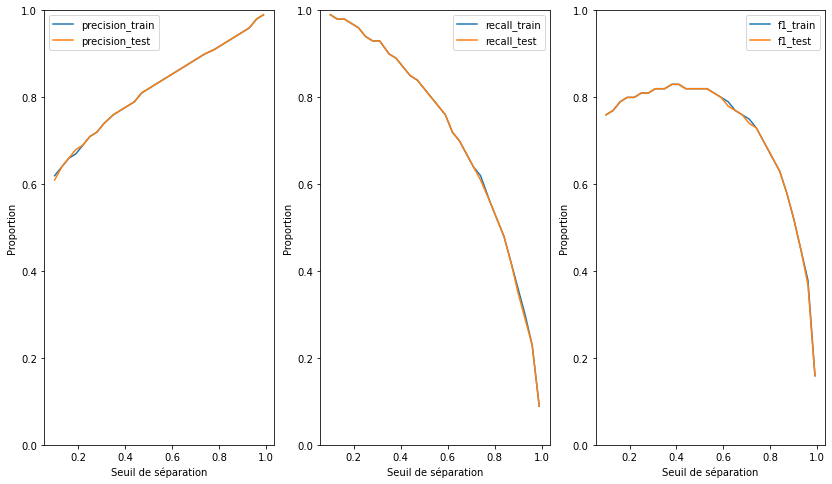

In [207]:
## Visualisation du recall, precision et f1 sur le train et le test

under_over_fitting([reg_log.predict_proba(x_train_mod),y_train],[reg_log.predict_proba(x_test_mod),y_test])

In [215]:
RF_model= RandomForestClassifier(n_estimators=70,random_state=42,criterion="entropy",
                                 max_depth=30, max_features=70, max_leaf_nodes=90,min_samples_leaf=90,n_jobs=-1) 

RF_model.fit(x_train_mod, y_train)

y_pred = RF_model.predict(x_val_mod)

print(roc_auc_score(y_test,RF_model.predict_proba(x_test_mod)[:,1]))

print(average_precision_score(y_val,RF_model.predict_proba(x_val_mod)[:,1]))
                       
print(classification_report(y_val,y_pred)) 

0.9413977665121637
0.03416267310174055
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    182433
           1       0.01      0.78      0.01       254

    accuracy                           0.82    182687
   macro avg       0.50      0.80      0.46    182687
weighted avg       1.00      0.82      0.90    182687



In [120]:
average_precision_score(y_test,reg_log.predict_proba(x_test)[:,1])

0.7015659016404913

In [121]:
average_precision_score(y_train,reg_log.predict_proba(x_train)[:,1])

0.702367008616554

In [122]:
average_precision_score(y_val,reg_log.predict_proba(x_val)[:,1])

0.15433651581069746

In [158]:
print(classification_report(y_val,reg_log.predict(x_val_mod)))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    182433
           1       0.01      0.80      0.01       254

    accuracy                           0.82    182687
   macro avg       0.50      0.81      0.46    182687
weighted avg       1.00      0.82      0.90    182687



In [33]:
precisions, rappels, seuils = precision_recall_curve(y_val, reg_log.predict_proba(x_val)[:,1])

precisions = precisions[:-1]
rappels = rappels[:-1]
condition = (rappels + precisions )> 0
precisions = precisions[condition]
rappels = rappels[condition]
seuils = seuils[condition]

f1_scores = 2 * rappels * precisions/(rappels + precisions)

val_seuil = seuils[np.argmax(f1_scores)]

print("Meilleur seuil : ", val_seuil)

Meilleur seuil :  0.6467089269981716


In [34]:
np.max(f1_scores)

0.24313088922321638

In [35]:
print(classification_report(y_val, reg_log.predict_proba(x_val)[:,1] >= val_seuil))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87    162889
           1       0.16      0.48      0.24     12673

    accuracy                           0.78    175562
   macro avg       0.56      0.64      0.56    175562
weighted avg       0.90      0.78      0.83    175562



In [36]:
print(confusion_matrix(y_val, reg_log.predict_proba(x_val)[:,1] >= val_seuil))

[[131187  31702]
 [  6532   6141]]


In [7]:
roc_auc_score(y_test,reg_log.predict_proba(x_test)[:,1])

0.7481287151285516

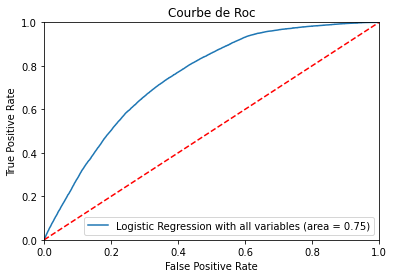

In [9]:
logit_roc_auc = roc_auc_score(y_test, reg_log.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, reg_log.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression with all variables (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe de Roc')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

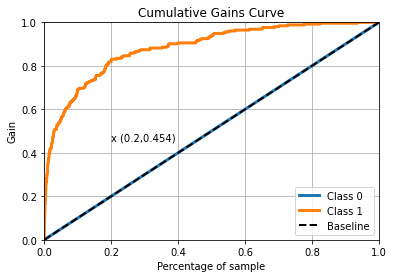

In [159]:
plt.rcParams["figure.figsize"]=[6,4]

skplt.metrics.plot_cumulative_gain(y_val, reg_log.predict_proba(x_val_mod))

pyplot.annotate('x (0.2,0.454)', xy = (0.2, 0.454), xytext = (0.2, 0.4543))
                                   
plt.show()

(0.0, 5.0)

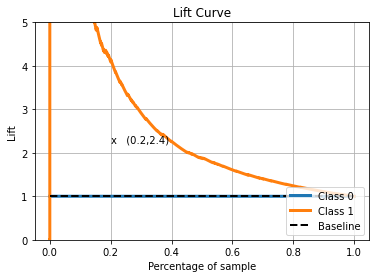

In [160]:
skplt.metrics.plot_lift_curve(y_val, reg_log.predict_proba(x_val_mod))

pyplot.annotate('x   (0.2,2.4)', xy = (0.2, 0.483), xytext = (0.2, 2.24))

plt.ylim(0,5)

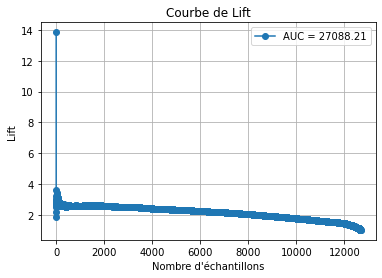

In [38]:

# Exemple de probabilités de prédiction pour un modèle
y_true = np.array(y_val)
y_pred_probs = reg_log.predict_proba(x_val)[:,1]  # Probabilités prédites

# Tri des probabilités prédites et des vraies valeurs pour le calcul de la courbe de Lift
sorted_indices = np.argsort(y_pred_probs)[::-1]
y_pred_probs_sorted = y_pred_probs[sorted_indices]
y_true_sorted = y_true[sorted_indices]

# Calcul des taux positifs et taux de Lift
total_positives = np.sum(y_true_sorted)
total_samples = len(y_true_sorted)
positives_count = 0
cumulative_positives = []
lift_values = []

for i in range(total_samples):
    if y_true_sorted[i] == 1:
        positives_count += 1
        cumulative_positives.append(positives_count)
        lift = (positives_count / (i + 1)) / (total_positives / total_samples)
        lift_values.append(lift)

# Calcul de l'aire sous la courbe de Lift
auc_lift = auc(cumulative_positives, lift_values)

# Tracer la courbe de Lift
plt.plot(cumulative_positives, lift_values, marker='o', label=f'AUC = {auc_lift:.2f}')
plt.xlabel("Nombre d'échantillons")
plt.ylabel("Lift")
plt.title("Courbe de Lift")
plt.legend()
plt.grid(True)
plt.show()

In [161]:
def plot_lift_curve(y_val, y_pred, step=0.1):  
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
    return x_val,y_v

In [216]:
lift, dec= plot_lift_curve(y_val,RF_model.predict_proba(x_val_mod)[:,1])

dec

[6.889650640924797,
 3.9959973717363826,
 2.8608454089935345,
 2.2637733317888804,
 1.8346356267835149,
 1.5879149198565519,
 1.400448848637393,
 1.230311593363522,
 1.1067319460799523,
 1.0]

In [218]:
def courbe_Lifts_cum(Lifts_cum,decile):
    
    fig = go.Figure()

    fig.add_trace(go.Bar(
        name = 'barplot',
        x = list(map(lambda x:str(round(x,2)),Lifts_cum)),
        y = decile, text=list(map(lambda x: f"{x:.2f}",decile)),textposition="outside",
        marker=dict(color=decile[::-1],colorscale='aggrnyl'),opacity=0.8
       ) )

    fig.add_trace(go.Scatter(
        name = 'line plot',
        x = list(map(lambda x:str(round(x,2)),Lifts_cum)),
        y = [1 for i in range(len(decile)+1)], line=dict(color='red', width=4, dash='dot')
       )
    )

    fig.update_yaxes(title="lift par décile")

    fig.update_xaxes(title="Proportion de l'échantillon",tickvals=list(range(len(decile))), ticktext=["10%","20%","30%","40%"
                                                                            ,"50%","60%","70%","80%","90%","100%"])



    fig.show()

In [219]:
## Tracer de la courbe de Lift

courbe_Lifts_cum(lift, dec)

In [15]:
4.88/2

2.44

In [130]:
y_val.value_counts()

TOP_RETRAITE
0               162889
1                12673
dtype: int64

In [22]:
0.1543/0.072

2.1430555555555557

In [184]:
lr_precision, lr_recall, _ = precision_recall_curve(y_val, reg_log.predict_proba(x_val.drop("NOIDE",axis=1))[:,1])
auc(lr_recall, lr_precision)  ## calcul auc precision recall

0.041226808315695

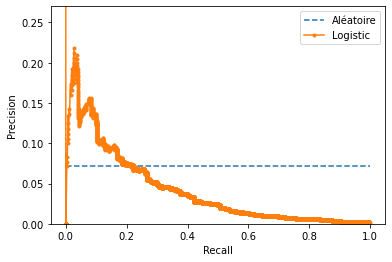

In [185]:
plt.plot([0, 1], [0.072, 0.072], linestyle='--', label='Aléatoire')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.ylim(0,0.27)
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [309]:
print(average_precision_score(y_val,reg_log.predict_proba(x_val)[:,1]))

0.15433651579740745


In [6]:
print(average_precision_score(y_test,RF_model.predict_proba(x_test)[:,1]))

0.9925393122040428


In [123]:
0.1543/0.072

2.1430555555555557

In [304]:
y_val.value_counts(normalize=True)

0    0.927815
1    0.072185
Name: TOP_RETRAITE, dtype: float64

In [ ]:
Random_forest = RandomForestClassifier()

parametre = {'n_estimators' : [100, 200,300],
            'max_features' : [10,20,30],
             "min_samples_leaf" : [10,15,20],
             "max_depth" : [10,15,20],
             "criterion": ["gini","entropy","log_loss"],
            "class_weight":["balanced","balanced_subsample"],
             "max_samples":[.7,.8,1]
            }

optimal_params =GridSearchCV(
        Random_forest, 
        parametre,
        cv=5,
        verbose=0
    ,scoring='roc_auc'
    )

optimal_params.fit(x_train,y_train)

print(optimal_params.best_params_)

## Sélection variable avec sklearn

In [191]:
## Sélection variable avec sklearn

x_train_scale = StandardScaler().fit_transform(x_train)

sklearn_sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=15, scoring="roc_auc" )

sklearn_sfs.fit(x_train_scale, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=15, scoring='roc_auc')

In [193]:
liste = sklearn_sfs.get_feature_names_out()

liste_selection = list(map(lambda x: list(x_train.columns)[int(x[1:])], liste))

liste_selection

['PROPO_FACEAFACE_disc_Au_moins_1',
 'TOP_ASSUR_VIE',
 'TYPE_COTISATION_Forfait',
 'Nbre_Equip_Hors_Retr_disc_Au_moins_1',
 'REGION_Hauts De France',
 'SEXE',
 'Nbre_canaux_Devis_disc_Au_moins_1',
 'TOP_TOUT_HABITAT',
 'Age_disc_[31.50, 35.50)',
 'Anciennete_disc_(-inf, 7.50)',
 'Anciennete_disc_[21.50, 23.50)',
 'Anciennete_disc_[23.50, 25.50)',
 'Anciennete_disc_[25.50, 28.50)',
 'Anciennete_disc_[37.50, inf)',
 'Anciennete_disc_[7.50, 21.50)']

In [77]:
X = X_res_over[liste_selection].copy()

x_stat = sm.add_constant(X)

logit_model=sm.Logit(y_res_over,x_stat)

result=logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.605512
         Iterations 9
                                    Results: Logit
Model:                      Logit                  Pseudo R-squared:       0.126      
Dependent Variable:         TOP_RETRAITE           AIC:                    921218.7168
Date:                       2023-08-11 22:56       BIC:                    921403.3880
No. Observations:           760668                 Log-Likelihood:         -4.6059e+05
Df Model:                   15                     LL-Null:                -5.2725e+05
Df Residuals:               760652                 LLR p-value:            0.0000     
Converged:                  1.0000                 Scale:                  1.0000     
No. Iterations:             9.0000                                                    
--------------------------------------------------------------------------------------
                                      Coef.  Std.Err.     z     

In [36]:
#log_reg = smf.logit("TOP_RETRAITE ~ TOP_DECES + CODSEX + TYPE_COTISATION + nb_evolution + Age_disc + NAT_ACTIVITE +Anciennete_disc", data=x_train_statmodel)

#resul = log_reg.fit()

In [155]:
Liste_supp = ['Age',
 'Nbre_canaux_dispo',
 'Anciennete',
 'MTT_COT_AN',
 'Nbre_Camp_Multiequip',
 'Nbre_Total_Camp']

x_train_statmodel.drop(Liste_supp, axis=1, inplace=True)

In [6]:
### Sélection des variables importantes pour les modeles de regression logistique avec stats models

def selection_variables(df_train,df_test,cible):
    
    AUC, ignore_col= [(0,0)], []
    
    bal = ""
    
    i=0
    
    df_train.columns = [col.replace("-","_") for col in df_train.columns]
    
    df_test.columns = [col.replace("-","_") for col in df_test.columns]
    
    variables = [col for col in df_train.columns if col!=cible and not col.startswith("Freq")]
    
    for col in variables:
        
        bal= bal + col if i==0 else bal+"+"+col
        
        model = smf.logit(f"{cible} ~ {bal}", data=df_train)
        
        try:
        
            result = model.fit()
            
        except np.linalg.LinAlgError:
            
            ignore_col.append(col)
            
            continue
        
        auc_roc = round(roc_auc_score(df_test[cible],result.predict(df_test)),2)
        
        print(auc_roc)
        
        i=1
        
        if (auc_roc - AUC[-1][1])<=1e-2:
            
            ignore_col.append(col)
        
        AUC.append((bal,auc_roc))
            
    return AUC, ignore_col      

In [11]:
## Liste des variable à ignorer pour un modèle optimal

var_non_import = selection_variables(x_train_statmodel,x_test_statmodel,"TOP_RETRAITE")[1]

Optimization terminated successfully.
         Current function value: 0.692292
         Iterations 5
0.5
Optimization terminated successfully.
         Current function value: 0.691553
         Iterations 5
0.51
Optimization terminated successfully.
         Current function value: 0.689987
         Iterations 5
0.51
Optimization terminated successfully.
         Current function value: 0.686743
         Iterations 5
0.55
Optimization terminated successfully.
         Current function value: 0.686725
         Iterations 5
0.55
Optimization terminated successfully.
         Current function value: 0.685479
         Iterations 5
0.55
Optimization terminated successfully.
         Current function value: 0.685468
         Iterations 5
0.55
Optimization terminated successfully.
         Current function value: 0.685446
         Iterations 5
0.55
Optimization terminated successfully.
         Current function value: 0.685433
         Iterations 5
0.55
Optimization terminated successfully.


In [21]:
## modèle sur les variables importantes sélectionnées.

var_imp = list(set(x_train_statmodel.columns) - set(var_non_import))

var_importante = [col for col in var_imp if not col.startswith("Freq") and col!="TOP_RETRAITE"]

print(var_importante)

['Anciennete_disc',
 'TOP_DECES',
 'REGION',
 'Nbre_Camp_Conq_disc',
 'TOP_TOUT_HABITAT',
 'PROPO_Mail_disc',
 'PROPO_TELEPHONE_disc',
 'Devis_Assur_Vie_disc',
 'Nbre_Devis_Hors_Retr_disc',
 'NAT_ACTIVITE',
 'nb_baisse',
 'Devis_Protect_Juriq_disc',
 'Age_disc',
 'PROPO_INTERNET_disc',
 'FORMULE',
 'Contact_SMS',
 'TOP_ASSUR_VIE',
 'Devis_CAM_disc',
 'PROPO_FACEAFACE_disc',
 'TYPE_COTISATION']

In [50]:
Top = [col for col in x_train_statmodel.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    x_train_statmodel[col] = x_train_statmodel[col].astype("object")
    
x_train_statmodel["COUVRE_BE"] = x_train_statmodel["COUVRE_BE"].astype(float).astype(int).astype(str)

x_train_statmodel["COUVRE_BC"] = x_train_statmodel["COUVRE_BC"].astype(float).astype(int).astype(str)

x_train_statmodel["TOP_RETRAITE"] = x_train_statmodel["TOP_RETRAITE"].astype(int)

In [51]:
### lancement du modèle sur les variables importantes

cible="TOP_RETRAITE"

bal = "+".join(var_importante)

model = smf.logit(f"{cible} ~ {bal}", data=x_train_statmodel)
    
result = model.fit()

print("l'AUC est de :",roc_auc_score(x_test_statmodel[cible],result.predict(x_test_statmodel)))

         Current function value: 0.586220
         Iterations: 35
l'AUC est de : 0.7440496899123228


In [156]:
x_train_statmodel["Anciennete_disc"].value_counts()

[7.50, 21.50)     154623
(-inf, 7.50)      129491
[30.50, 37.50)     73382
[25.50, 28.50)     48500
[23.50, 25.50)     34943
[28.50, 30.50)     33087
[21.50, 23.50)     29712
[37.50, inf)       28729
Name: Anciennete_disc, dtype: int64

In [166]:
np.exp(0.7558)

2.1293142935912623

In [52]:
## résultat du modèle

result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
===========================================================================================
Model:                       Logit                    Pseudo R-squared:         0.154      
Dependent Variable:          TOP_RETRAITE             AIC:                      624403.1182
Date:                        2023-08-15 22:32         BIC:                      625063.0495
No. Observations:            532467                   Log-Likelihood:           -3.1214e+05
Df Model:                    58                       LL-Null:                  -3.6908e+05
Df Residuals:                532408                   LLR p-value:              0.0000     
Converged:                   0.0000                   Scale:                    1.0000     
No. Iterations:              35.0000                                                       
-------------------------------------------------------------------------------------------
                                     Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-------------------------------------------------------------------------------------------
Intercept                             1.4756    0.0934  15.8053 0.0000     1.2926    1.6586
Anciennete_disc[T.[21.50, 23.50)]     1.8184    0.0165 109.9536 0.0000     1.7860    1.8508
Anciennete_disc[T.[23.50, 25.50)]     2.2179    0.0163 135.7668 0.0000     2.1859    2.2499
Anciennete_disc[T.[25.50, 28.50)]     2.3493    0.0155 151.7171 0.0000     2.3190    2.3797
Anciennete_disc[T.[28.50, 30.50)]     2.4660    0.0172 143.2869 0.0000     2.4323    2.4998
Anciennete_disc[T.[30.50, 37.50)]     2.6250    0.0152 172.6034 0.0000     2.5952    2.6548
Anciennete_disc[T.[37.50, inf)]       2.8432    0.0205 138.7130 0.0000     2.8030    2.8834
Anciennete_disc[T.[7.50, 21.50)]      1.6451    0.0119 138.2637 0.0000     1.6217    1.6684
TOP_DECES[T.1]                        0.4970    0.0189  26.2422 0.0000     0.4599    0.5341
REGION[T.Auvergne]                    0.1490    0.0240   6.2198 0.0000     0.1020    0.1959
REGION[T.Bourgogne Franche Comté]     0.2418    0.0196  12.3332 0.0000     0.2034    0.2802
REGION[T.Bretagne ]                  -0.0908    0.0200  -4.5383 0.0000    -0.1300   -0.0516
REGION[T.Centre]                      0.1085    0.0209   5.2019 0.0000     0.0676    0.1494
REGION[T.DFA]                        -0.0622    0.0237  -2.6211 0.0088    -0.1087   -0.0157
REGION[T.Grand Est]                   0.1223    0.0172   7.0978 0.0000     0.0886    0.1561
REGION[T.Hauts De France]            -0.0955    0.0172  -5.5678 0.0000    -0.1292   -0.0619
REGION[T.ILE DE France]              -0.0830    0.0158  -5.2503 0.0000    -0.1140   -0.0520
REGION[T.Languedoc/Roussillon]        0.0081    0.0196   0.4159 0.6775    -0.0302    0.0465
REGION[T.Limousin/Poitou Charentes]   0.1385    0.0203   6.8061 0.0000     0.0986    0.1783
REGION[T.Midi Pyrénées ]              0.0743    0.0189   3.9311 0.0001     0.0373    0.1114
REGION[T.Normandie ]                  0.1678    0.0192   8.7363 0.0000     0.1301    0.2054
REGION[T.PACA Corse]                  0.0818    0.0172   4.7500 0.0000     0.0481    0.1156
REGION[T.Pays de la Loire ]           0.0646    0.0200   3.2270 0.0013     0.0254    0.1039
REGION[T.Rhône Alpes]                 0.1149    0.0170   6.7579 0.0000     0.0816    0.1483
REGION[T.S. E. M.]                  -13.5003 1176.5580  -0.0115 0.9908 -2319.5115 2292.5110
REGION[T.ZOI]                        -0.1505    0.0241  -6.2394 0.0000    -0.1978   -0.1032
Nbre_Camp_Conq_disc[T.Aucun]         -0.0158    0.0189  -0.8389 0.4015    -0.0528    0.0211
TOP_TOUT_HABITAT[T.1]                 0.1194    0.0076  15.7982 0.0000     0.1046    0.1342
PROPO_Mail_disc[T.Aucun]             -1.1806    0.0473 -24.9335 0.0000    -1.2734   -1.0878
PROPO_TELEPHONE_disc[T.Aucun]        -1.3985    0.0238 -58.7037 0.0000    -1.4452   -1.3518
Devis_Assur_Vie_disc[T.Aucun]     

In [194]:
reg_log.coef_.shape

(1, 131)

In [221]:
#shap.Explainer(RF_model)
explainer = shap.Explainer(RF_model)
shap_values = explainer(x_val)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])

KeyboardInterrupt: 

In [10]:
explain = shap.Explainer(RF_model)
shap_val = explain(x_train)

In [11]:
shap_val

.values =
array([[[-0.1138439 ,  0.1138439 ],
        [-0.02969921,  0.02969921],
        [ 0.03692293, -0.03692293],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-0.1138439 ,  0.1138439 ],
        [-0.02969921,  0.02969921],
        [ 0.03692293, -0.03692293],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-0.1302648 ,  0.1302648 ],
        [-0.00808172,  0.00808172],
        [ 0.03669385, -0.03669385],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[-0.1210008 ,  0.1210008 ],
        [-0.00501317,  0.00501317],
        [ 0.03423932, -0.03423932],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-0.11455476,  0.11455476],
        [-0.03431

In [21]:
x_train.shape

(532467, 143)

In [27]:
RF_model= RandomForestClassifier(n_estimators=150,max_depth=15, max_features=80, max_leaf_nodes=90,
                                random_state=42,criterion="entropy")

In [60]:
y_pred = RF_model.predict_proba(x_val[liste_imp_RF])

In [78]:
np.argmin(y_pred,axis=0)

array([13571,    12], dtype=int64)

In [77]:
y_pred[13571]

array([0.14142326, 0.85857674])

In [81]:
np.mean(y_pred)

0.5

In [62]:
y_pred.mean(axis=0)

array([0.58440373, 0.41559627])

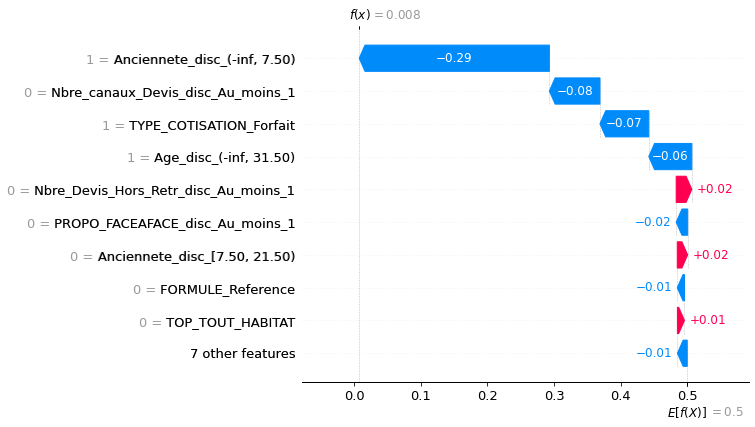

In [133]:
exp = shap.Explanation(shap_values[12].values[:,1],shap_values[12].base_values[1],
                       shap_values[12].data,feature_names=liste_imp_RF)

shap.plots.waterfall(exp) #, max_display=20

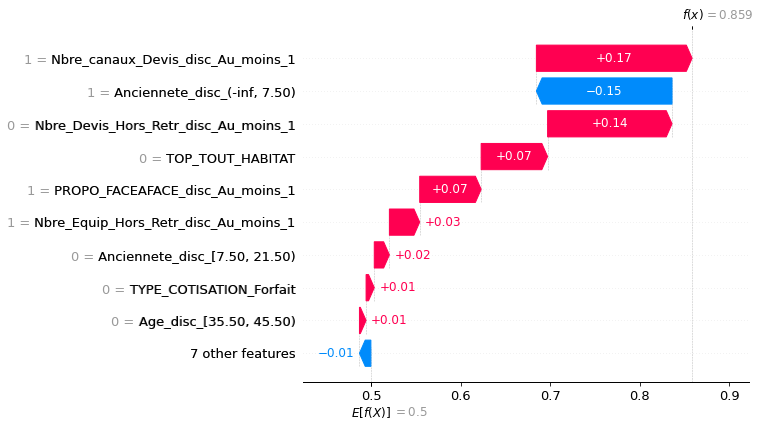

In [76]:
exp = shap.Explanation(shap_values[13571].values[:,1],shap_values[13571].base_values[1],
                       shap_values[13571].data,feature_names=liste_imp_RF)

shap.plots.waterfall(exp)

In [84]:
shap.initjs()
shap.plots.force(exp)

In [86]:
shap_values[0]

.values =
array([[-0.10330658,  0.10330658],
       [-0.06463901,  0.06463901],
       [ 0.00726793, -0.00726793],
       [-0.01259659,  0.01259659],
       [ 0.00559764, -0.00559764],
       [-0.00245723,  0.00245723],
       [-0.00251242,  0.00251242],
       [-0.01366063,  0.01366063],
       [-0.00452533,  0.00452533],
       [ 0.00409487, -0.00409487],
       [-0.01395727,  0.01395727],
       [-0.05838229,  0.05838229],
       [ 0.01263426, -0.01263426],
       [-0.00537059,  0.00537059],
       [ 0.00132584, -0.00132584],
       [ 0.00039869, -0.00039869]])

.base_values =
array([0.50037783, 0.49962217])

.data =
array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [97]:
shap_values.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

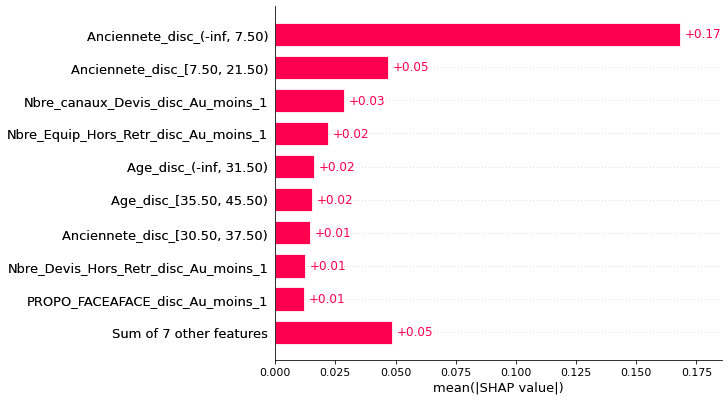

In [110]:
shap.plots.bar(exp)

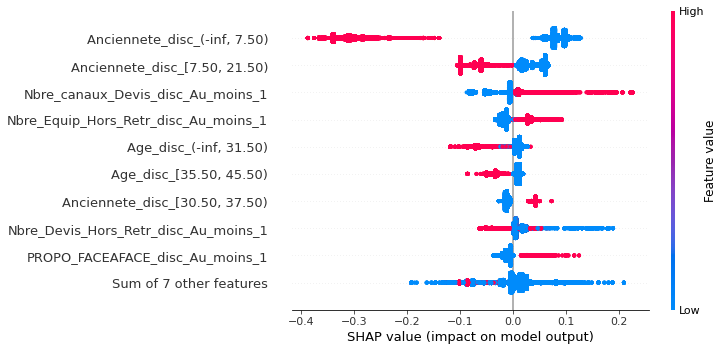

In [98]:
exp = shap.Explanation(shap_values.values[:,:,1],shap_values.base_values[:,1],
                       shap_values.data,feature_names=liste_imp_RF)

shap.plots.beeswarm(exp)

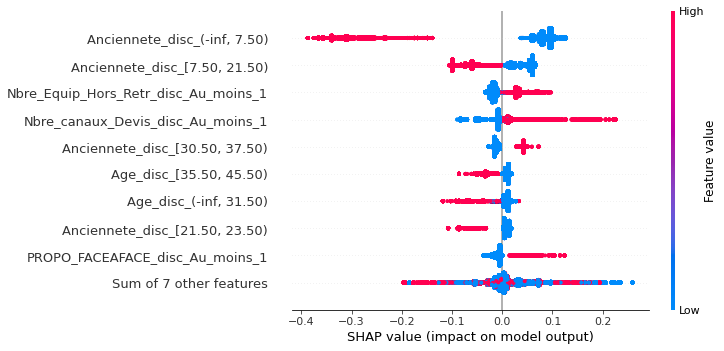

In [119]:
exp_test = shap.Explanation(shap_val.values[:,:,1],shap_val.base_values[:,1],shap_val.data,feature_names=liste_imp_RF)

#shap.initjs()

shap.plots.beeswarm(exp_test)

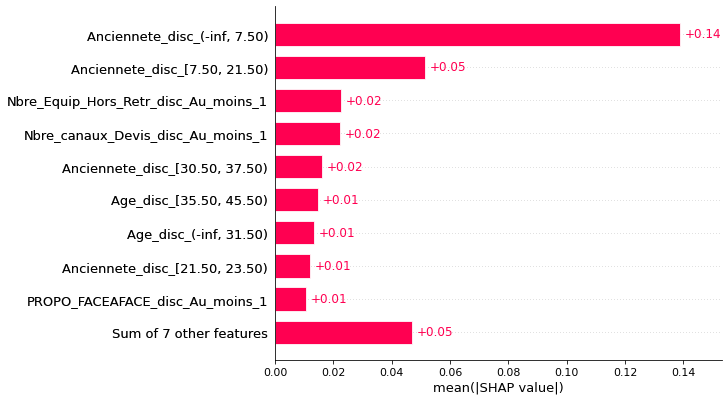

In [124]:
shap.plots.bar(exp_test)

In [129]:
np.mean(abs(shap_val.values[:,:,1]),axis=0)

array([0.13890296, 0.05127145, 0.0221882 , 0.01315298, 0.01620372,
       0.0075541 , 0.00438275, 0.01189627, 0.01048328, 0.01061269,
       0.01467649, 0.00850622, 0.02268063, 0.00928708, 0.00467713,
       0.00190919])

In [130]:
kstest(np.mean(abs(shap_val.values[:,:,1]),axis=0),np.mean(abs(shap_values.values[:,:,1]),axis=0))

KstestResult(statistic=0.125, pvalue=0.9998909696588173, statistic_location=0.009287081025924983, statistic_sign=1)

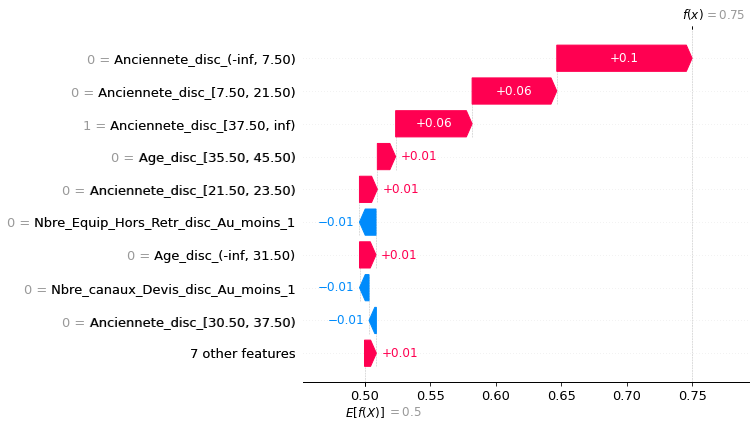

In [71]:
#explainer = shap.Explainer(RF_model)
#shap_values = explainer(x_val[liste_imp_RF])

# visualize the first prediction's explanation

exp = shap.Explanation(shap_values[0].values[:,1],shap_values[0].base_values[1],shap_values[0].data,feature_names=liste_imp_RF)

#shap.initjs()

shap.plots.waterfall(exp)

#shap.plots.force(shap_values[0])

#shap.force_plot(base_value = explainer.expected_value[0], shap_values = shap_values.values[0, :],
#                features = x_val[liste_imp_RF])

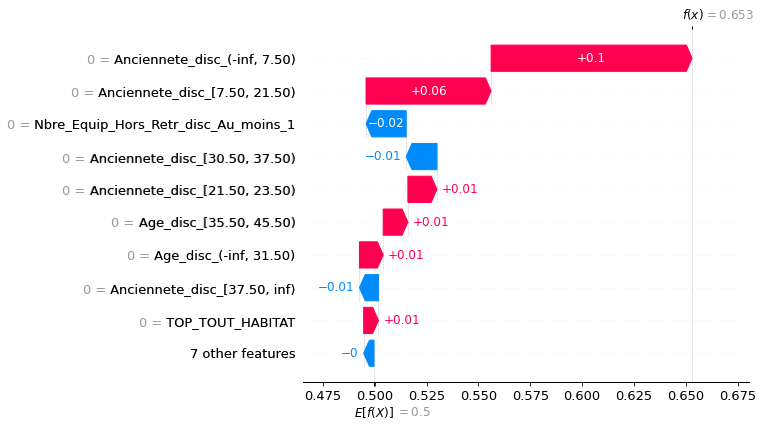

In [111]:
explain = shap.Explainer(RF_model)
shap_val = explain(x_test[liste_imp_RF])

# visualize the first prediction's explanation

exp_test = shap.Explanation(shap_val[0].values[:,1],shap_val[0].base_values[1],shap_val[0].data,feature_names=liste_imp_RF)

#shap.initjs()

shap.plots.waterfall(exp_test)

In [112]:
y_pred_test = RF_model.predict_proba(x_test[liste_imp_RF])

np.argmax(y_pred_test,axis=0)

array([ 154, 4695], dtype=int64)

In [116]:
y_pred_test[4695,:]

array([0.14142326, 0.85857674])

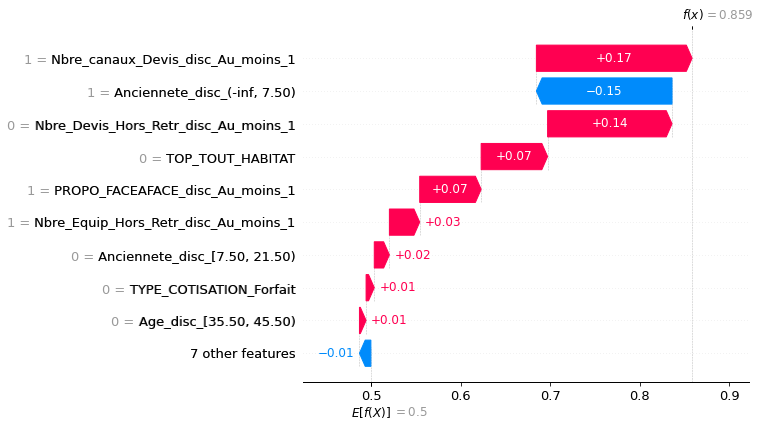

In [117]:
exp_test = shap.Explanation(shap_val[4695].values[:,1],shap_val[4695].base_values[1],shap_val[4695].data,feature_names=liste_imp_RF)

#shap.initjs()

shap.plots.waterfall(exp_test)

In [72]:
shap_values[0].data

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [75]:
x_val[liste_imp_RF].iloc[0]

Anciennete_disc_(-inf, 7.50)            0
Anciennete_disc_[7.50, 21.50)           0
Nbre_canaux_Devis_disc_Au_moins_1       0
Age_disc_(-inf, 31.50)                  0
Anciennete_disc_[30.50, 37.50)          0
TYPE_COTISATION_Forfait                 0
FORMULE_Reference                       1
Anciennete_disc_[21.50, 23.50)          0
Nbre_Devis_Hors_Retr_disc_Au_moins_1    0
PROPO_FACEAFACE_disc_Au_moins_1         0
Age_disc_[35.50, 45.50)                 0
Anciennete_disc_[37.50, inf)            1
Nbre_Equip_Hors_Retr_disc_Au_moins_1    0
TOP_TOUT_HABITAT                        0
Age_disc_[31.50, 35.50)                 0
TOP_ASSUR_VIE                           0
Name: 0, dtype: int64

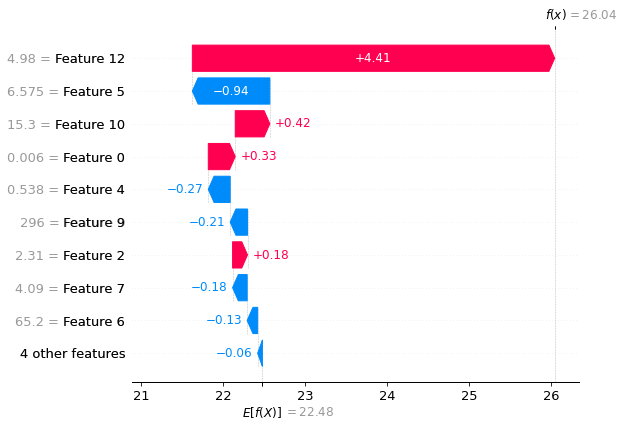

In [56]:
shap.plots.waterfall(exp)

In [51]:
help(shap.Explanation)

Help on class Explanation in module shap._explanation:

class Explanation(builtins.object)
 |  Explanation(values, base_values=None, data=None, display_data=None, instance_names=None, feature_names=None, output_names=None, output_indexes=None, lower_bounds=None, upper_bounds=None, error_std=None, main_effects=None, hierarchical_values=None, clustering=None, compute_time=None)
 |  
 |  A slicable set of parallel arrays representing a SHAP explanation.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, other)
 |  
 |  __copy__(self)
 |  
 |  __getitem__(self, item)
 |      This adds support for OpChain indexing.
 |  
 |  __init__(self, values, base_values=None, data=None, display_data=None, instance_names=None, feature_names=None, output_names=None, output_indexes=None, lower_bounds=None, upper_bounds=None, error_std=None, main_effects=None, hierarchical_values=None, clustering=None, compute_time=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __l

In [9]:
x_val.shape

(175562, 143)

In [10]:


#RF_model= RandomForestClassifier(n_estimators=170,max_depth=15, max_features=80, max_leaf_nodes=100,min_samples_leaf=90 
  #                               ,random_state=42,criterion="entropy", n_jobs=-1) #, class_weight="balanced")

#RF_model.fit(x_train, y_train)

y_pred = RF_model.predict(x_val)

#print(roc_auc_score(y_test,RF_model.predict_proba(x_test)[:,1]))

print(average_precision_score(y_val,RF_model.predict_proba(x_val)[:,1]))
                       
print(classification_report(y_val,y_pred)) 

0.16247275181479254
              precision    recall  f1-score   support

           0       0.97      0.62      0.76    162889
           1       0.13      0.75      0.23     12673

    accuracy                           0.63    175562
   macro avg       0.55      0.68      0.49    175562
weighted avg       0.91      0.63      0.72    175562



In [122]:
x_train_imp = x_train.drop("NOIDE",axis=1)

#x_test_imp = x_test.drop("NOIDE",axis=1)

#x_val_imp = x_val.drop("NOIDE", axis=1)

RF_model_imp= RandomForestClassifier(n_estimators=170,max_depth=15, max_features=80, max_leaf_nodes=100,min_samples_leaf=90 
                                 ,random_state=42,criterion="entropy", n_jobs=-1) #, class_weight="balanced")

RF_model_imp.fit(x_train_imp, y_train)

#y_pred = RF_model_imp.predict(x_val_imp)

#print(roc_auc_score(y_test,RF_model_imp.predict_proba(x_test_imp)[:,1]))

#print(average_precision_score(y_val,RF_model_imp.predict_proba(x_val_imp)[:,1]))
                       
#print(classification_report(y_val,y_pred)) 

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=80,
                       max_leaf_nodes=100, min_samples_leaf=90,
                       n_estimators=170, n_jobs=-1, random_state=42)

renommer les colonnes de df_val_2023 avant d'appliquervle RF aussi supprimer la colonne TOP_retraite et noide

In [196]:
cros_val = cross_val_score(reg_log,x_train,y_train, cv=5, scoring="roc_auc")

cros_val

array([0.69841406, 0.69742905, 0.69828498, 0.69586184, 0.69876498])

In [123]:
cros_val = cross_val_score(RF_model_imp,x_train,y_train, cv=5, scoring="roc_auc")

cros_val

array([0.76399405, 0.76202902, 0.76149252, 0.76274631, 0.7636612 ])

In [128]:
df_val_2023.rename(columns={"chgt_tr_cotis_22-23_0":"chgt_tr_cotis_20-21_0",
"chgt_tr_cotis_22-23_1":"chgt_tr_cotis_20-21_1",
"chgt_tr_cotis_22-23_NC":"chgt_tr_cotis_20-21_NC",
"evol_cotis_22-23_NC":"evol_cotis_20-21_NC",
"evol_cotis_22-23_baisse":"evol_cotis_20-21_baisse",
"evol_cotis_22-23_stable":"evol_cotis_20-21_stable",
"evol_cotis_22-23_évolution":"evol_cotis_20-21_évolution"}, inplace=True)

In [129]:
[col for col in df_val_2023.columns if col.startswith("chgt_tr_cotis_22-23")]

[]

In [137]:
x_train_imp.shape

(532467, 143)

In [147]:
for col in x_val.columns:
    
    if col not in x_train_imp.columns:
        
        print(col)

Devis_Epargne_retraite_disc_Au_moins_1


In [183]:
#y_val = df_val_2023["TOP_RETRAITE"].copy()

#x_val = df_val_2023.drop(["TOP_RETRAITE","NOIDE","Devis_Epargne_retraite_disc_Au_moins_1"], axis=1)

In [192]:
print(average_precision_score(y_val,RF_model_imp.predict_proba(x_val)[:,1]))

0.005737689938298144


In [165]:
x_val_mod.insert(0,"Score_RL",reg_log.predict_proba(x_val_mod)[:,1])

x_val_mod.insert(1,"TOP_RETRAITE",y_val)

x_val_mod.insert(0,"NOIDE",x_val["NOIDE"])

In [166]:
x_val_mod.sort_values("Score_RL",inplace=True, ascending=False)

x_val_mod.head()

,NOIDE,Score_RL,TOP_RETRAITE,COUVRE_BE,REGION_Centre,COUVRE_BC,chgt_tr_cotis_n-2_n-1_0,TOP_PIM,Nbre_Equip_Hors_Retr_disc_Au_moins_1,chgt_tr_cotis_n-2_n-1_NC,nb_evolution_1_et_plus,Devis_CAM_disc_Au_moins_1,Freq_moy_Camp/mois_disc_1_Camp/mois,REGION_Hauts De France,evol_cotis_n-1_n_baisse,NB_RECLA_disc_Au_moins_1,evol_cotis_n-2_n-1_évolution,FORMULE_OJI,REGION_ILE DE France,Freq_moy_email/mois_disc_1_mail/mois,Contact_Cour,REGION_Rhône Alpes,Nbre_canaux_Devis_disc_Au_moins_1,NAT_ACTIVITE_Retraité,REGION_Pays de la Loire,evol_cotis_n-1_n_NC,REGION_DFA,TYPE_COTISATION_Plafond,Devis_Assur_Vie_disc_Au_moins_1,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,evol_cotis_n-1_n_stable,FORMULE_Initiale,PROPO_Mail_disc_Au_moins_1,NAT_ACTIVITE_Scolarité,INTER_SMS_disc_Au_moins_1,TOP_OBS,PROPO_Courrier_disc_Au_moins_1,Freq_moy_Camp/mois_disc_ciblé_1_fois,FORMULE_Integrale,REGION_Aquitaine,FORMULE_Prev_seule,Nbre_Camp_Conq_disc_Au_moins_1,REGION_ZOI,TYPE_COTISATION_Plancher,TOP_ASSUR_VIE,Freq_moy_TEL/mois_disc_ciblé_1_fois,INTER_COURRIER_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,FORMULE_Reference,TOP_HABITAT_MGEN,REGION_Normandie,TYPE_COTISATION_Forfait,evol_cotis_n-1_n_évolution,Freq_moy_email/mois_disc_plus_2mails/mois,PROPO_FACEAFACE_disc_Au_moins_1,REGION_Midi Pyrénées,REGION_Grand Est,TOP_DECES,Devis_Assur_Décès_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Contact_Mail,evol_cotis_n-2_n-1_baisse,REGION_Bourgogne Franche Comté,Freq_moy_email/mois_disc_Aucun_mail/mois,Contact_SMS,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,TOP_TOUT_HABITAT,PROPO_INTERNET_disc_Au_moins_1,NAT_ACTIVITE_Actif,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,evol_cotis_n-2_n-1_NC,REGION_Limousin/Poitou Charentes,chgt_tr_cotis_n-1_n_1,chgt_tr_cotis_n-1_n_0,chgt_tr_cotis_n-2_n-1_1,REGION_PACA Corse,Devis_Assur_Obs_disc_Au_moins_1,FORMULE_Equilibre,TYPE_COTISATION_Taux,evol_cotis_n-2_n-1_stable,Contact_Tel,SEXE,REGION_Bretagne,REGION_Auvergne,nb_evolution_NC,Freq_moy_email/mois_disc_ciblé_1_fois,nb_evolution_Aucune,TOP_CAM,REGION_Languedoc/Roussillon,chgt_tr_cotis_n-1_n_NC,"Nbre_canaux_dispo_disc_(-inf, 2.50)","Nbre_canaux_dispo_disc_[2.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Age_disc_(-inf, 27.50)","Age_disc_[27.50, 30.50)","Age_disc_[30.50, 32.50)","Age_disc_[32.50, 35.50)","Age_disc_[35.50, 38.50)","Age_disc_[38.50, 42.50)","Age_disc_[42.50, 46.50)","Age_disc_[46.50, 49.50)","Age_disc_[49.50, 55.50)","Age_disc_[55.50, 58.50)","Age_disc_[58.50, inf)","Anciennete_disc_(-inf, 2.50)","Anciennete_disc_[12.50, 16.50)","Anciennete_disc_[16.50, 19.50)","Anciennete_disc_[19.50, 23.50)","Anciennete_disc_[2.50, 3.50)","Anciennete_disc_[23.50, 30.50)","Anciennete_disc_[3.50, 4.50)","Anciennete_disc_[30.50, inf)","Anciennete_disc_[4.50, 7.50)","Anciennete_disc_[7.50, 12.50)","MTT_COT_AN_disc_(-inf, 416.24)","MTT_COT_AN_disc_[1116.90, 1232.82)","MTT_COT_AN_disc_[1232.82, 1639.98)","MTT_COT_AN_disc_[1639.98, inf)","MTT_COT_AN_disc_[416.24, 573.62)","MTT_COT_AN_disc_[573.62, 756.65)","MTT_COT_AN_disc_[756.65, 900.75)","MTT_COT_AN_disc_[900.75, 1116.90)","INTER_MAIL_disc_(-inf, 4.50)","INTER_MAIL_disc_[12.50, 13.50)","INTER_MAIL_disc_[13.50, 14.50)","INTER_MAIL_disc_[14.50, 15.50)","INTER_MAIL_disc_[15.50, 16.50)","INTER_MAIL_disc_[16.50, 18.50)","INTER_MAIL_disc_[18.50, inf)","INTER_MAIL_disc_[4.50, 12.50)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 2.50)","Nbre_Camp_Multiequip_disc_[2.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, inf)"
287029,0103798586,0.999933,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
528,0104922286,0.999891,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [169]:
x_val_mod.shape

(182687, 134)

In [174]:
y_val.value_counts(normalize=True)

0    0.99861
1    0.00139
Name: TOP_RETRAITE, dtype: float64

In [168]:
0.2*254

50.800000000000004

In [170]:
0.2*182687

36537.4

In [158]:
x_val.shape

(506729, 146)

In [171]:
x_val_mod.iloc[:36538,2].sum()

208

In [172]:
208/36538

0.005692703486780886

In [179]:
102/101346

0.0010064531407258303

In [175]:
0.0057/0.00139

4.100719424460432

In [191]:
y_val.value_counts(normalize=True)

0    0.998883
1    0.001117
Name: TOP_RETRAITE, dtype: float64

In [188]:
y_pred = (RF_model_imp.predict_proba(x_val)[:,1]>0.5).astype(int)

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.33      0.49    506163
           1       0.00      0.70      0.00       566

    accuracy                           0.33    506729
   macro avg       0.50      0.51      0.25    506729
weighted avg       1.00      0.33      0.49    506729



In [190]:
print(confusion_matrix(y_val,y_pred))

[[164697 341466]
 [   170    396]]


In [286]:
x_val_imp = x_val.drop("NOIDE", axis=1).copy()

In [282]:
#x_val_imp.drop("Score_RL", axis=1, inplace=True)

In [287]:
x_val_imp.insert(0,"Score_RL",reg_log.predict_proba(x_lift)[:,1])

In [288]:
x_val_imp.head()

,Score_RL,REGION_Limousin/Poitou Charentes,REGION_PACA Corse,Devis_PIM_disc_Au_moins_1,chgt_tr_cotis_20-21_0,evol_cotis_21-22_NC,evol_cotis_21-22_baisse,Freq_moy_Camp/mois_disc_ciblé_1_fois,nb_evolution_NC,Nbre_Equip_Hors_Retr_disc_Au_moins_1,PROPO_Courrier_disc_Au_moins_1,Freq_moy_email/mois_disc_plus_2mails/mois,PROPO_FACEAFACE_disc_Au_moins_1,chgt_tr_cotis_21-22_NC,FORMULE_Reference,nb_evolution_Aucune,NB_RECLA_disc_Au_moins_1,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,REGION_Normandie,Freq_moy_SMS/mois_disc_ciblé_1_fois,TYPE_COTISATION_Taux,REGION_ILE DE France,NAT_ACTIVITE_Retraité,REGION_Hauts De France,NAT_ACTIVITE_Actif,COUVRE_BC,Contact_Cour,Nbre_Camp_Conq_disc_Au_moins_1,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,TOP_ASSUR_VIE,Contact_Tel,chgt_tr_cotis_20-21_NC,evol_cotis_20-21_baisse,REGION_ZOI,SEXE,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,TOP_DECES,TYPE_COTISATION_Forfait,Devis_Assur_Décès_disc_Au_moins_1,Freq_moy_Cour/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,nb_baisse_1_et_plus,COUVRE_BE,Devis_Assur_Vie_disc_Au_moins_1,REGION_Midi Pyrénées,Freq_moy_email/mois_disc_ciblé_1_fois,Devis_Sante_Animale_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,chgt_tr_cotis_21-22_1,Contact_Mail,REGION_Rhône Alpes,evol_cotis_20-21_NC,chgt_tr_cotis_21-22_0,REGION_Bourgogne Franche Comté,TOP_TOUT_HABITAT,REGION_Grand Est,Freq_moy_email/mois_disc_1_mail/mois,evol_cotis_20-21_évolution,Devis_CAM_disc_Au_moins_1,TYPE_COTISATION_Plancher,REGION_Languedoc/Roussillon,FORMULE_Initiale,Devis_Assur_Obs_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,REGION_Pays de la Loire,TOP_CAM,TOP_OBS,FORMULE_OJI,nb_evolution_1_et_plus,TOP_SANTE_ANIM,Freq_moy_email/mois_disc_Aucun_mail/mois,evol_cotis_21-22_stable,FORMULE_Integrale,TOP_PROTECT_JURIQ,chgt_tr_cotis_20-21_1,nb_baisse_Aucune,FORMULE_Equilibre,PROPO_TELEPHONE_disc_Au_moins_1,FORMULE_Prev_seule,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,evol_cotis_21-22_évolution,Devis_Protect_Juriq_disc_Au_moins_1,REGION_DFA,PROPO_INTERNET_disc_Au_moins_1,TOP_PIM,REGION_Centre,evol_cotis_20-21_stable,REGION_Aquitaine,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,REGION_Bretagne,nb_baisse_NC,TOP_HABITAT_MGEN,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,TYPE_COTISATION_Plafond,NAT_ACTIVITE_Scolarité,REGION_Auvergne,PROPO_Mail_disc_Au_moins_1,Contact_SMS,"Nbre_canaux_dispo_disc_(-inf, 2.50)","Nbre_canaux_dispo_disc_[2.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Age_disc_(-inf, 31.50)","Age_disc_[31.50, 35.50)","Age_disc_[35.50, 45.50)","Age_disc_[45.50, 47.50)","Age_disc_[47.50, 50.50)","Age_disc_[50.50, 52.50)","Age_disc_[52.50, 54.50)","Age_disc_[54.50, 57.50)","Age_disc_[57.50, 59.50)","Age_disc_[59.50, inf)","Anciennete_disc_(-inf, 7.50)","Anciennete_disc_[21.50, 23.50)","Anciennete_disc_[23.50, 25.50)","Anciennete_disc_[25.50, 28.50)","Anciennete_disc_[28.50, 30.50)","Anciennete_disc_[30.50, 37.50)","Anciennete_disc_[37.50, inf)","Anciennete_disc_[7.50, 21.50)","MTT_COT_AN_disc_(-inf, 494.09)","MTT_COT_AN_disc_[1201.38, 1308.78)","MTT_COT_AN_disc_[1308.78, 1412.58)","MTT_COT_AN_disc_[1412.58, 1508.10)","MTT_COT_AN_disc_[1508.10, 1772.34)","MTT_COT_AN_disc_[1772.34, inf)","MTT_COT_AN_disc_[494.09, 678.09)","MTT_COT_AN_disc_[678.09, 866.73)","MTT_COT_AN_disc_[866.73, 1201.38)","Nbre_Total_Camp_disc_(-inf, 4.50)","Nbre_Total_Camp_disc_[10.50, 13.50)","Nbre_Total_Camp_disc_[13.50, 15.50)","Nbre_Total_Camp_disc_[15.50, 16.50)","Nbre_Total_Camp_disc_[16.50, 17.50)","Nbre_Total_Camp_disc_[17.50, 19.50)","Nbre_Total_Camp_disc_[19.50, inf)","Nbre_Total_Camp_disc_[4.50, 7.50)","Nbre_Total_Camp_disc_[7.50, 10.50)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 1.50)","Nbre_Camp_Multiequip_disc_[1.50, 2.50)","Nbre_Camp_Multiequip_disc_[2.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, inf)"
0,0.750916,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,

In [289]:
x_val_imp.insert(1,"TOP_RETRAITE", list(y_val))

x_val_imp.insert(0,"NOIDE",x_val["NOIDE"])

x_val_imp.sort_values("Score_RL", ascending=False, inplace=True)

x_val_imp.head()

,NOIDE,Score_RL,TOP_RETRAITE,REGION_Limousin/Poitou Charentes,REGION_PACA Corse,Devis_PIM_disc_Au_moins_1,chgt_tr_cotis_20-21_0,evol_cotis_21-22_NC,evol_cotis_21-22_baisse,Freq_moy_Camp/mois_disc_ciblé_1_fois,nb_evolution_NC,Nbre_Equip_Hors_Retr_disc_Au_moins_1,PROPO_Courrier_disc_Au_moins_1,Freq_moy_email/mois_disc_plus_2mails/mois,PROPO_FACEAFACE_disc_Au_moins_1,chgt_tr_cotis_21-22_NC,FORMULE_Reference,nb_evolution_Aucune,NB_RECLA_disc_Au_moins_1,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,REGION_Normandie,Freq_moy_SMS/mois_disc_ciblé_1_fois,TYPE_COTISATION_Taux,REGION_ILE DE France,NAT_ACTIVITE_Retraité,REGION_Hauts De France,NAT_ACTIVITE_Actif,COUVRE_BC,Contact_Cour,Nbre_Camp_Conq_disc_Au_moins_1,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,TOP_ASSUR_VIE,Contact_Tel,chgt_tr_cotis_20-21_NC,evol_cotis_20-21_baisse,REGION_ZOI,SEXE,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,TOP_DECES,TYPE_COTISATION_Forfait,Devis_Assur_Décès_disc_Au_moins_1,Freq_moy_Cour/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,nb_baisse_1_et_plus,COUVRE_BE,Devis_Assur_Vie_disc_Au_moins_1,REGION_Midi Pyrénées,Freq_moy_email/mois_disc_ciblé_1_fois,Devis_Sante_Animale_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,chgt_tr_cotis_21-22_1,Contact_Mail,REGION_Rhône Alpes,evol_cotis_20-21_NC,chgt_tr_cotis_21-22_0,REGION_Bourgogne Franche Comté,TOP_TOUT_HABITAT,REGION_Grand Est,Freq_moy_email/mois_disc_1_mail/mois,evol_cotis_20-21_évolution,Devis_CAM_disc_Au_moins_1,TYPE_COTISATION_Plancher,REGION_Languedoc/Roussillon,FORMULE_Initiale,Devis_Assur_Obs_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,REGION_Pays de la Loire,TOP_CAM,TOP_OBS,FORMULE_OJI,nb_evolution_1_et_plus,TOP_SANTE_ANIM,Freq_moy_email/mois_disc_Aucun_mail/mois,evol_cotis_21-22_stable,FORMULE_Integrale,TOP_PROTECT_JURIQ,chgt_tr_cotis_20-21_1,nb_baisse_Aucune,FORMULE_Equilibre,PROPO_TELEPHONE_disc_Au_moins_1,FORMULE_Prev_seule,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,evol_cotis_21-22_évolution,Devis_Protect_Juriq_disc_Au_moins_1,REGION_DFA,PROPO_INTERNET_disc_Au_moins_1,TOP_PIM,REGION_Centre,evol_cotis_20-21_stable,REGION_Aquitaine,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,REGION_Bretagne,nb_baisse_NC,TOP_HABITAT_MGEN,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,TYPE_COTISATION_Plafond,NAT_ACTIVITE_Scolarité,REGION_Auvergne,PROPO_Mail_disc_Au_moins_1,Contact_SMS,"Nbre_canaux_dispo_disc_(-inf, 2.50)","Nbre_canaux_dispo_disc_[2.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Age_disc_(-inf, 31.50)","Age_disc_[31.50, 35.50)","Age_disc_[35.50, 45.50)","Age_disc_[45.50, 47.50)","Age_disc_[47.50, 50.50)","Age_disc_[50.50, 52.50)","Age_disc_[52.50, 54.50)","Age_disc_[54.50, 57.50)","Age_disc_[57.50, 59.50)","Age_disc_[59.50, inf)","Anciennete_disc_(-inf, 7.50)","Anciennete_disc_[21.50, 23.50)","Anciennete_disc_[23.50, 25.50)","Anciennete_disc_[25.50, 28.50)","Anciennete_disc_[28.50, 30.50)","Anciennete_disc_[30.50, 37.50)","Anciennete_disc_[37.50, inf)","Anciennete_disc_[7.50, 21.50)","MTT_COT_AN_disc_(-inf, 494.09)","MTT_COT_AN_disc_[1201.38, 1308.78)","MTT_COT_AN_disc_[1308.78, 1412.58)","MTT_COT_AN_disc_[1412.58, 1508.10)","MTT_COT_AN_disc_[1508.10, 1772.34)","MTT_COT_AN_disc_[1772.34, inf)","MTT_COT_AN_disc_[494.09, 678.09)","MTT_COT_AN_disc_[678.09, 866.73)","MTT_COT_AN_disc_[866.73, 1201.38)","Nbre_Total_Camp_disc_(-inf, 4.50)","Nbre_Total_Camp_disc_[10.50, 13.50)","Nbre_Total_Camp_disc_[13.50, 15.50)","Nbre_Total_Camp_disc_[15.50, 16.50)","Nbre_Total_Camp_disc_[16.50, 17.50)","Nbre_Total_Camp_disc_[17.50, 19.50)","Nbre_Total_Camp_disc_[19.50, inf)","Nbre_Total_Camp_disc_[4.50, 7.50)","Nbre_Total_Camp_disc_[7.50, 10.50)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 1.50)","Nbre_Camp_Multiequip_disc_[1.50, 2.50)","Nbre_Camp_Multiequip_disc_[2.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, inf)"
134167,0102971407,0.997780,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0

In [263]:
5817/2534

2.2955801104972378

In [303]:
int(np.ceil(0.3*len(x_val_imp)))

52669

In [304]:
x_val_imp.iloc[:52669,2].sum()

7843

In [305]:
7843/52669

0.1489111241907004

In [307]:
x_val_imp.iloc[:52669,[0,2]].to_csv("NOIDE_mieux_score.csv",index=False, encoding="mbcs")

In [292]:
5758/12673

0.4543517714826797

In [246]:
prop_dec = 5817/35113

prop_dec

0.165665138267878

In [247]:
prop_dec/0.072

2.300904698164972

In [220]:
Counter(y_val)

Counter({0: 162889, 1: 12673})

In [262]:
0.2*12673

2534.6000000000004

In [221]:
11184/12673

0.882506115363371

In [197]:
#RF_model_imp.classes_

array([0, 1], dtype=int64)

In [193]:
y_val.value_counts(normalize=True)

0    0.927815
1    0.072185
Name: TOP_RETRAITE, dtype: float64

In [226]:
x_val_imp['TOP_RETRAITE'].sum() / len(x_val_imp)

0.07218532484250578

In [4]:
RF_model= RandomForestClassifier(n_estimators=170,max_depth=15, max_features=80, max_leaf_nodes=100,min_samples_leaf=90 
                                 ,random_state=42,criterion="entropy", n_jobs=-1) #, class_weight="balanced")

RF_model.fit(x_train, y_train)

#y_pred = RF_model.predict(x_val)

#print(roc_auc_score(y_test,RF_model.predict_proba(x_test)[:,1]))

#print(average_precision_score(y_val,RF_model.predict_proba(x_val)[:,1]))
                       
#print(classification_report(y_val,y_pred)) 

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=80,
                       max_leaf_nodes=100, min_samples_leaf=90,
                       n_estimators=170, n_jobs=-1, random_state=42)

In [137]:
0.1624/0.072

2.2555555555555555

In [45]:
0.1642/0.072

2.280555555555556

In [138]:
print(roc_auc_score(y_train,RF_model_imp.predict_proba(x_train_imp)[:,1]))

0.7563965917539884


In [27]:
y_pred = (RF_model.predict_proba(x_val)[:,1]>0.2).astype(int)

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87    244873
           1       0.15      0.45      0.23     19853

    accuracy                           0.77    264726
   macro avg       0.55      0.62      0.55    264726
weighted avg       0.89      0.77      0.82    264726



In [28]:
average_precision_score(y_val,y_pred,average="weighted")

0.1100093978061733

In [99]:
feature[feature["Importance"]>0.5]

,index,Importance
0,"Anciennete_disc_(-inf, 7.50)",50.866848
1,"Anciennete_disc_[7.50, 21.50)",9.453245
2,Nbre_canaux_Devis_disc_Au_moins_1,5.328409
3,"Age_disc_(-inf, 31.50)",5.315769
4,"Anciennete_disc_[30.50, 37.50)",2.907053
5,TYPE_COTISATION_Forfait,2.693077
6,FORMULE_Reference,2.044394
7,"Anciennete_disc_[21.50, 23.50)",1.825175
8,Nbre_Devis_Hors_Retr_disc_Au_moins_1,1.824023
9,PROPO_FACEAFACE_disc_Au_moins_1,1.755635


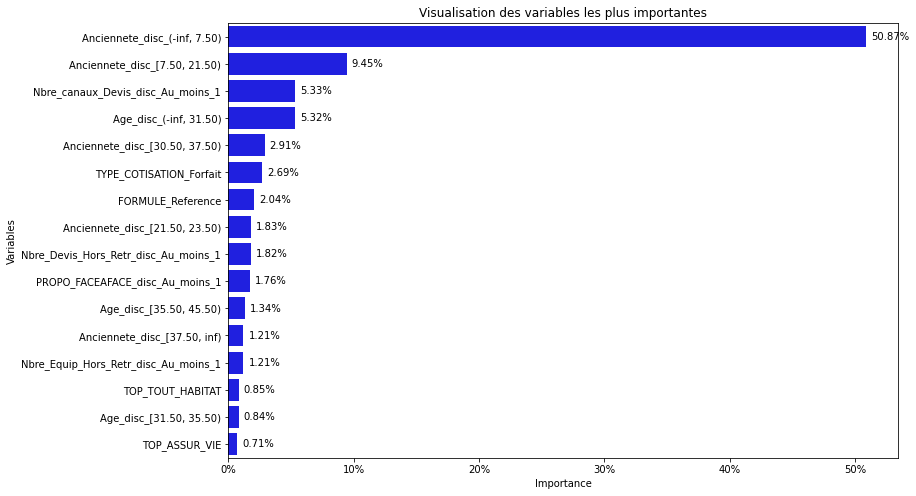

In [5]:
feature = pd.DataFrame(100*RF_model.feature_importances_, 
                       index=x_train.columns, columns=["Importance"]).sort_values("Importance", ascending=False).reset_index()

plt.figure(figsize=(12,8))

ax = sns.barplot(data=feature[feature["Importance"]>0.5], y="index",x="Importance", orient="h", color="blue")

for p in ax.patches:
    ax.annotate(f"{p.get_width():.2f}%", xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
    
ax.xaxis.set_ticklabels(map(lambda x: str(x)+"%", range(0,52,10)))

plt.ylabel("Variables")

plt.title("Visualisation des variables les plus importantes")

plt.show()

In [8]:
len(liste_imp_RF)

16

In [7]:
liste_imp_RF = list(feature.loc[feature["Importance"]>0.5,"index"])

In [9]:
RF_model= RandomForestClassifier(n_estimators=170,max_depth=15, max_features=10, max_leaf_nodes=100,min_samples_leaf=90 
                                 ,random_state=42,criterion="entropy", n_jobs=-1) #, class_weight="balanced")

RF_model.fit(x_train[liste_imp_RF], y_train)

#y_pred = RF_model.predict(x_val[liste_imp_RF])

#print(roc_auc_score(y_test,RF_model.predict_proba(x_test[liste_imp_RF])[:,1]))

#print(average_precision_score(y_val,RF_model.predict_proba(x_val[liste_imp_RF])[:,1]))
                       
#print(classification_report(y_val,y_pred)) 

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=10,
                       max_leaf_nodes=100, min_samples_leaf=90,
                       n_estimators=170, n_jobs=-1, random_state=42)

## Classificateur naive bayesien

In [107]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [108]:
model_baye = BernoulliNB()

model_baye.fit(x_train[liste_imp_RF].to_numpy(), y_train)

print(roc_auc_score(y_test,model_baye.predict_proba(x_test[liste_imp_RF].to_numpy())[:,1]))

0.7092263930134974


In [109]:
print(average_precision_score(y_val,model_baye.predict_proba(x_val[liste_imp_RF].to_numpy())[:,1]))

0.13479635546212598


### sur echantillonage aléatoire

In [34]:
counter = Counter(y_train_nc)

print(counter)

rus = RandomOverSampler(random_state=42) ##, sampling_strategy=0.85

X_res_over, y_res_over = rus.fit_resample(x_train_nc, y_train_nc)

counter = Counter(y_res_over)

print(counter)

Counter({'0': 380334, '1': 29310})
Counter({'0': 380334, '1': 380334})


In [ ]:
reg_log = LogisticRegression(max_iter=200, penalty="l1", l1_ratio=0.05, solver="liblinear")  ## penalty='elasticnet', solver="saga", l1_ratio=0.3,max_iter=80,class_weight={0:1.1,1:1.95}

reg_log.fit(X_res_over, y_res_over)

y_pred = reg_log.predict(x_val)

print(average_precision_score(y_val,y_pred))

print(classification_report(y_val,y_pred))

In [41]:
roc_auc_score(y_val,reg_log.predict(x_val))

0.6551831111638353

In [23]:
average_precision_score(y_val,y_pred)/0.075

1.4973709002318423

In [20]:
y_val.value_counts(normalize=True)

0    0.925005
1    0.074995
Name: TOP_RETRAITE, dtype: float64

In [30]:
over = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)

#over = SMOTE(sampling_strategy=0.2, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)

print(Counter(Y_train_disc))

steps = [('under', under),('over', over)]

X_pipe, y_pipe = Pipeline(steps=steps).fit_resample(X_train_disc,Y_train_disc)

print(Counter(y_pipe))

Counter({0: 815538, 1: 66879})
Counter({1: 66879, 0: 61183})


In [38]:
counter = Counter(Y_train_disc)

print(counter)

oversample = ADASYN(random_state=42)

X, y = oversample.fit_resample(X_train_disc, Y_train_disc)

counter = Counter(y)

print(counter)

Counter({0: 815538, 1: 66879})
Counter({1: 816525, 0: 815538})


In [39]:
x_train, x_test, y_train, y_test = train_test_split(X_pipe,y_pipe,test_size=0.3,random_state=42)

print("taille du jeu d\'entrainement",x_train.shape,"\n")

print("taille du jeu de test",x_test.shape,"\n")

taille du jeu d'entrainement (1305650, 112) 

taille du jeu de test (326413, 112) 



In [40]:
reg_log = LogisticRegression()  #penalty='l1', solver="saga", l1_ratio=0.3

reg_log.fit(x_train, y_train)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(reg_log.score(x_test, y_test)))

y_pred = reg_log.predict(x_test)

print(classification_report(y_test,y_pred))

Accuracy of logistic regression classifier on test set: 0.82
              precision    recall  f1-score   support

           0       0.81      0.83      0.82    162897
           1       0.83      0.81      0.82    163516

    accuracy                           0.82    326413
   macro avg       0.82      0.82      0.82    326413
weighted avg       0.82      0.82      0.82    326413



In [33]:
print(classification_report(Y_train_disc,reg_log.predict(X_train_disc)))

              precision    recall  f1-score   support

           0       0.96      0.52      0.67    815538
           1       0.11      0.75      0.20     66879

    accuracy                           0.54    882417
   macro avg       0.54      0.63      0.44    882417
weighted avg       0.90      0.54      0.64    882417



In [52]:
roc_auc_score(Y_train_disc, reg_log.predict(X_train_disc))

0.5429918734954257

In [58]:
confusion_matrix(y,reg_log.predict(X))

array([[663065, 152473],
       [203047, 613478]], dtype=int64)

In [55]:
scores = cross_val_score(reg_log,X,y, scoring='precision', cv=10, n_jobs=-1)

In [57]:
np.nanmean(scores)

0.8199548503826348

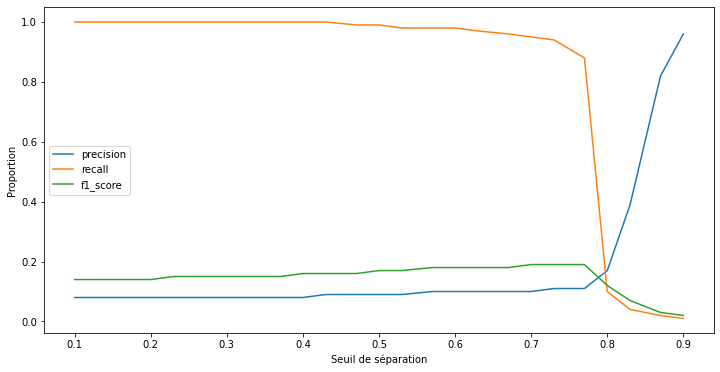

'La précision maximale est 0.96 pour le seuil de 0.9'

In [106]:
trace_indicateur(RF_model.predict_proba(X_train_disc),Y_train_disc)

In [312]:
RF_model= BalancedRandomForestClassifier(n_estimators=150,max_depth=40, max_features=40, max_leaf_nodes=60,
                                random_state=42,criterion="entropy", class_weight="balanced")

RF_model.fit(x_train, y_train)

print(f"L'AUC est de :{roc_auc_score(y_test, RF_model.predict(x_test))}\n\n")

y_pred = RF_model.predict(x_test)
                       
print(classification_report(y_test,y_pred)) 

L'AUC est de :0.688525626904391




NameError: name 'x_test_disc' is not defined

In [315]:
print(average_precision_score(y_val, RF_model.predict_proba(x_val)[:,1]))

0.15776922635528418


In [92]:
print(classification_report(Y_train_disc,RF_model.predict(X_train_disc)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    815538
           1       0.08      1.00      0.14     66879

    accuracy                           0.08    882417
   macro avg       0.04      0.50      0.07    882417
weighted avg       0.01      0.08      0.01    882417



In [64]:
RF_model=RandomForestClassifier(n_estimators=300,max_depth=15, max_features=15, max_leaf_nodes=30,
                                random_state=42,criterion="entropy", class_weight="balanced")

RF_model.fit(X_train_disc, Y_train_disc)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features=15, max_leaf_nodes=30,
                       n_estimators=300, random_state=42)

In [111]:
y_pred = (RF_model.predict_proba(X_train_disc)[:,1]>0.8).astype(int)

print(classification_report(Y_train_disc,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94    815538
           1       0.17      0.10      0.12     66879

    accuracy                           0.90    882417
   macro avg       0.55      0.53      0.53    882417
weighted avg       0.87      0.90      0.88    882417



In [109]:
confusion_matrix(Y_train_disc,y_pred)

array([[211830, 603708],
       [  1636,  65243]], dtype=int64)

In [48]:
%matplotlib inline

<Figure size 864x432 with 0 Axes>

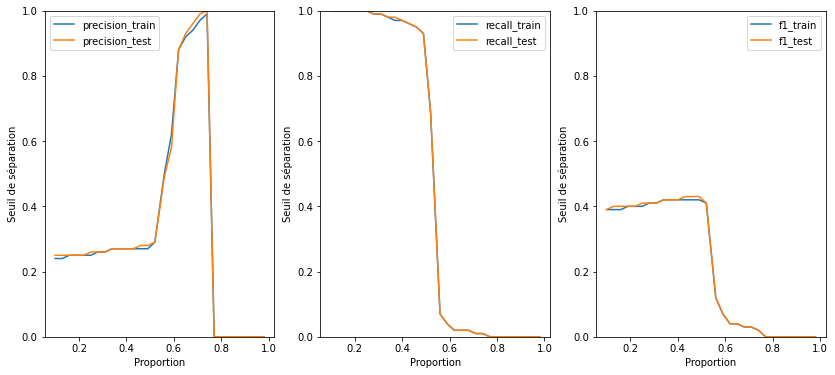

In [82]:
under_over_fitting([RF_model.predict_proba(x_train_disc),y_train_disc],[RF_model.predict_proba(x_test_disc),y_test_disc])

In [112]:
scale = StandardScaler().fit(x_train_disc)

x_train_scale = scale.transform(x_train_disc)

x_test_scale = scale.transform(x_test_disc)

X_train_disc_scale = scale.transform(X_train_disc)

In [126]:
# one hot encode outputs
y_train_keras = to_categorical(y_train)

y_test_keras = to_categorical(y_test)

Y_train_disc_keras = to_categorical(Y_train_disc)

count_classes = y_test_keras.shape[1]

print(count_classes)

model = Sequential()

model.add(Dense(500, activation='relu', input_dim=112, name="Couche_entree"))

model.add(Dense(800, activation='relu', name="1er_Couche_cachee"))

model.add(Dense(500, activation='relu', name="2ieme_Couche_cachee"))

model.add(Dense(700, activation='relu', name="Couche_cachee"))

model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax', name="Couche_sortie"))

# Compile the model
model.compile(optimizer="Adam",        #keras.optimizers.Adam(learning_rate=0.09), 
              loss='categorical_crossentropy', 
              metrics=['accuracy','precision'])

# build the model
history = model.fit(x_train_scale, y_train_keras, epochs=20,batch_size=10000, validation_split=0.3, verbose=1)

2
Epoch 1/20
14/14 [==============================] - 5s 340ms/step - loss: 0.7225 - accuracy: 0.4975 - val_loss: 0.6934 - val_accuracy: 0.4950
Epoch 2/20
14/14 [==============================] - 5s 330ms/step - loss: 0.6941 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4992
Epoch 3/20
14/14 [==============================] - 5s 333ms/step - loss: 0.6933 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 4/20
14/14 [==============================] - 5s 347ms/step - loss: 0.6930 - accuracy: 0.5065 - val_loss: 0.6932 - val_accuracy: 0.5026
Epoch 5/20
14/14 [==============================] - 5s 352ms/step - loss: 0.6928 - accuracy: 0.5110 - val_loss: 0.6933 - val_accuracy: 0.5019
Epoch 6/20
14/14 [==============================] - 5s 364ms/step - loss: 0.6925 - accuracy: 0.5155 - val_loss: 0.6934 - val_accuracy: 0.4997
Epoch 7/20
14/14 [==============================] - 5s 370ms/step - loss: 0.6919 - accuracy: 0.5193 - val_loss: 0.6937 - val_accuracy: 0.4991
Epoc

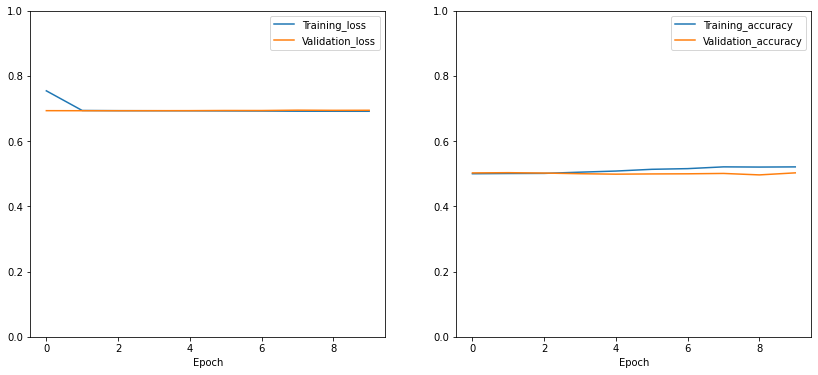

In [124]:

#plt.figure(figsize=(12,5))

plt.rcParams['figure.figsize'] = [14, 6]

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(history.history["loss"],label="Training_loss")

ax1.plot(history.history["val_loss"],label="Validation_loss")

ax1.legend()

ax1.set_xlabel("Epoch")

ax1.set_ylim(0,1)

ax2.plot(history.history["accuracy"],label="Training_accuracy")

ax2.plot(history.history["val_accuracy"],label="Validation_accuracy")

ax2.set_xlabel("Epoch")

ax2.set_ylim(0,1)

ax2.legend()

plt.show()

27576/27576 [==============================] - 53s 2ms/step


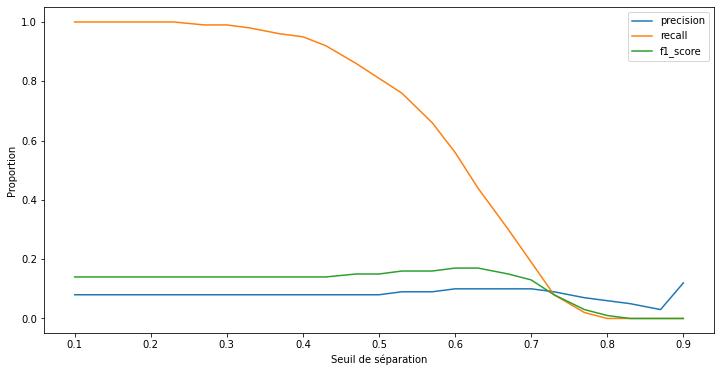

'La précision maximale est 0.12 pour le seuil de 0.9'

In [122]:
pred_train = history.model.predict(x_test_scale)

trace_indicateur(pred_train, y_test_disc)

In [117]:
y_pred = (pred_train[:,1]>0.57).astype(int)

print(classification_report(y_test_disc,y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     62858
           1       0.52      0.00      0.00     20168

    accuracy                           0.76     83026
   macro avg       0.64      0.50      0.43     83026
weighted avg       0.70      0.76      0.65     83026



In [118]:
confusion_matrix(y_test_disc,y_pred)

array([[62848,    10],
       [20157,    11]], dtype=int64)

27576/27576 [==============================] - 70s 3ms/step


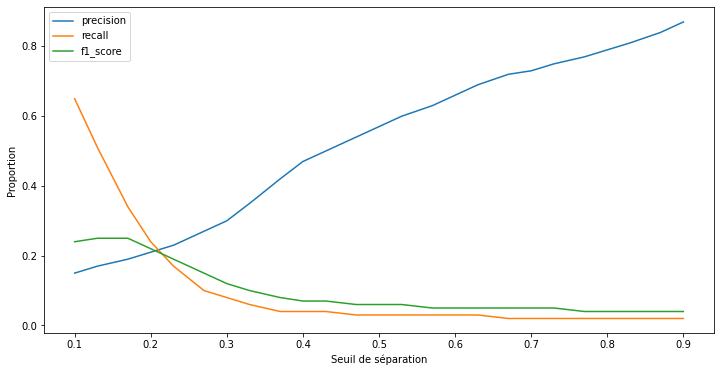

'La précision maximale est 0.87 pour le seuil de 0.9'

In [68]:
pred_train = history.model.predict(X_train_disc_scale)

trace_indicateur(pred_train, Y_train_disc)

In [75]:
y_pred = (pred_train[:,1]>0.1).astype(int)

print(classification_report(Y_train_disc,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80    815538
           1       0.15      0.65      0.24     66879

    accuracy                           0.69    882417
   macro avg       0.55      0.67      0.52    882417
weighted avg       0.90      0.69      0.76    882417



In [74]:
confusion_matrix(Y_train_disc,y_pred)

array([[687535, 128003],
       [ 38743,  28136]], dtype=int64)

In [43]:
model = EasyEnsembleClassifier(n_estimators=150, n_jobs=-1)

model.fit(x_train,y_train)

EasyEnsembleClassifier(n_estimators=150, n_jobs=-1)

In [ ]:
y_pred = (model.predict_proba(x_test)[:,1]>0.35).astype(int)

print(classification_report(y_test,y_pred))

In [45]:
y_pred = (model.predict_proba(x_test)[:,1]>0.35).astype(int)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    244873
           1       0.07      1.00      0.14     19853

    accuracy                           0.07    264726
   macro avg       0.04      0.50      0.07    264726
weighted avg       0.01      0.07      0.01    264726



<IPython.core.display.Javascript object>


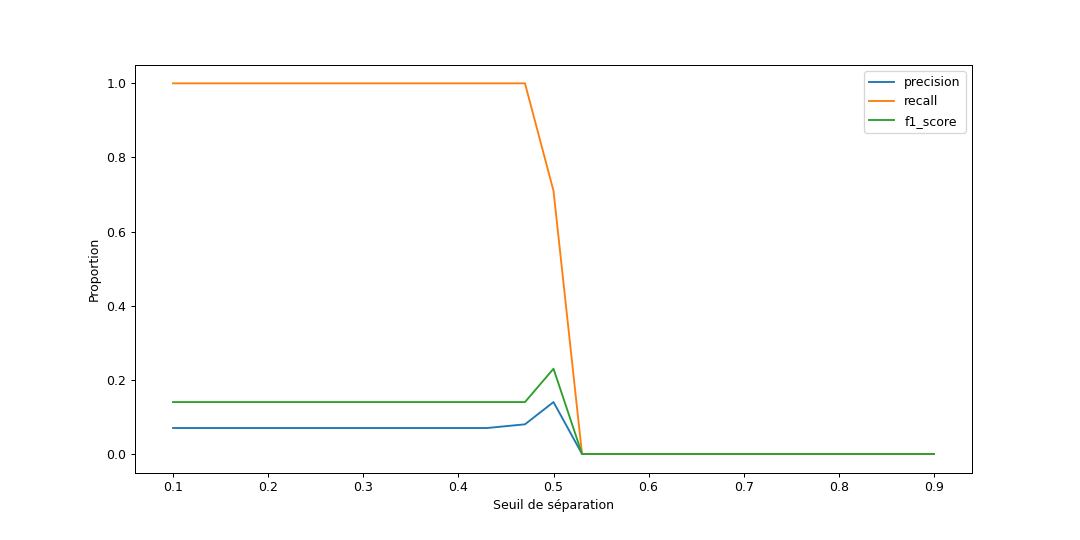

'La précision maximale est 0.14 pour le seuil de 0.5'

In [44]:
trace_indicateur(model.predict_proba(x_test),y_test)

In [8]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_disc, Y_train_disc, scoring='precision', cv=cv, n_jobs=-1)

In [9]:
scores

array([0.13887211, 0.13761544, 0.13787255, 0.13774809, 0.13879926,
       0.13680334, 0.13791586, 0.13776978, 0.1377862 , 0.1383779 ,
       0.13814228, 0.13783806, 0.13649583, 0.13851695, 0.13732879,
       0.13924328, 0.13702214, 0.13755567, 0.13871083, 0.13860429,
       0.13758   , 0.13816606, 0.1374889 , 0.13797367, 0.1375    ,
       0.1392233 , 0.13769467, 0.13846959, 0.13766176, 0.13835037])

## link tomek

In [76]:
X1 = df_etude_undersample.drop(["TOP_RETRAITE","Devis_Epargne_retraite_disc_Au_moins_1"], axis=1).copy()

y1 = df_etude_undersample["TOP_RETRAITE"]

counter = Counter(y1)

print(counter)

undersample = OneSidedSelection(n_neighbors=10, n_seeds_S=120000, random_state=0, 
                                sampling_strategy ="auto")  #TomekLinks()

X_res_disc_tomek, y_res_disc_tomek = undersample.fit_resample(X1, y1)

counter = Counter(y_res_disc_tomek)

print(counter)

Counter({0: 815538, 1: 66879})
Counter({0: 209873, 1: 66879})


In [222]:
#X_train_disc = X1.copy()

#Y_train_disc = y1.copy()

In [202]:
#help(OneSidedSelection)

In [338]:
#df_train = pd.concat([X_res_disc,y_res_disc], axis=1)

x_train_random, x_test_random, y_train_random, y_test_random = train_test_split(X_res_disc,y_res_disc,test_size=0.3,random_state=42)

print("taille du jeu d\'entrainement",x_train_random.shape,"\n")

print("taille du jeu de test",x_test_random.shape,"\n")

taille du jeu d'entrainement (1141753, 112) 

taille du jeu de test (489323, 112) 



In [8]:
#df_train = pd.concat([X_res_disc,y_res_disc], axis=1)

x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(X_res_over,y_res_over,test_size=0.3,random_state=42)

print("taille du jeu d\'entrainement",x_train_over.shape,"\n")

print("taille du jeu de test",x_test_over.shape,"\n")

taille du jeu d'entrainement (1141753, 112) 

taille du jeu de test (489323, 112) 



In [77]:
#df_train = pd.concat([X_res_disc,y_res_disc], axis=1)

x_train_disc, x_test_disc, y_train_disc, y_test_disc = train_test_split(X_res_disc_tomek,y_res_disc_tomek,test_size=0.3,random_state=42)

print("taille du jeu d\'entrainement",x_train_disc.shape,"\n")

print("taille du jeu de test",x_test_disc.shape,"\n")

taille du jeu d'entrainement (193726, 112) 

taille du jeu de test (83026, 112) 



In [9]:
optb = OptimalBinning(dtype="numerical", solver="cp")

def optimal_Binning(df1,df2,name,cible):
    
    optb.fit(df1[name].values, cible.values)
    
    name_woe_train = optb.transform(df1[name].values, metric="bins")
    
    name_woe_test = optb.transform(df2[name].values, metric="bins")
    
    return (name_woe_train,name_woe_test)


def supprime_col(df):
    
    disc = [col for col in df.columns if col.endswith("_disc")]

    for col in disc:

        if df[col].nunique()==1:

            df.drop(col,axis=1, inplace=True)

        else:

            df.drop(col[:-5],axis=1, inplace=True)
            
    return df

In [10]:
for col in int_var[1:]:
    
    x_train_over[col+"_disc"] = optimal_Binning(x_train_over,x_test_over,col,y_train_over)[0]
    
    x_test_over[col+"_disc"] = optimal_Binning(x_train_over,x_test_over,col,y_train_over)[1]
    
    #x_train_random[col+"_disc"] = optimal_Binning(x_train_random,x_test_random,col,y_train_random)[0]
    
    #x_test_random[col+"_disc"] = optimal_Binning(x_train_random,x_test_random,col,y_train_random)[1]
    
    X_random_over[col+"_disc"] = optimal_Binning(x_train_over,X_random_over,col,y_train_over)[1]

x_train_over =  supprime_col(x_train_over)   

x_test_over =  supprime_col(x_test_over) 

#x_train_random =  supprime_col(x_train_random)   

#x_test_random =  supprime_col(x_test_random)

X_random_over =  supprime_col(X_random_over) 
       
#df_etude_undersample.drop(['INTER_MAIL', 
 #    'TOTAL_INTER_CANAL', 'Nbre_Camp_Fid'],axis=1, inplace=True)
    
x_train_over.drop(["INTER_MAIL","TOTAL_INTER_CANAL","Nbre_Camp_Fid"], axis=1,inplace=True)

x_test_over.drop(["INTER_MAIL","TOTAL_INTER_CANAL","Nbre_Camp_Fid"], axis=1,inplace=True)


#x_train_random.drop(["INTER_MAIL","TOTAL_INTER_CANAL","Nbre_Camp_Fid"], axis=1,inplace=True)

#x_test_random.drop(["INTER_MAIL","TOTAL_INTER_CANAL","Nbre_Camp_Fid"], axis=1,inplace=True)


X_random_over.drop(["INTER_MAIL","TOTAL_INTER_CANAL","Nbre_Camp_Fid"], axis=1,inplace=True)
    
X_random_over.head()

,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_SANTE_ANIM,NAT_ACTIVITE_Actif,NAT_ACTIVITE_Retraité,NAT_ACTIVITE_Scolarité,Contact_Tel,Contact_Mail,Contact_SMS,Contact_Cour,FORMULE_Equilibre,FORMULE_Initiale,FORMULE_Integrale,FORMULE_OJI,FORMULE_Prev_seule,FORMULE_Reference,SEXE,COUVRE_BE,COUVRE_BC,TYPE_COTISATION_Forfait,TYPE_COTISATION_Plafond,TYPE_COTISATION_Plancher,TYPE_COTISATION_Taux,REGION_Aquitaine,REGION_Auvergne,REGION_Bourgogne Franche Comté,REGION_Bretagne,REGION_Centre,REGION_DFA,REGION_Grand Est,REGION_Hauts De France,REGION_ILE DE France,REGION_Languedoc/Roussillon,REGION_Limousin/Poitou Charentes,REGION_Midi Pyrénées,REGION_Normandie,REGION_PACA Corse,REGION_Pays de la Loire,REGION_Rhône Alpes,REGION_S. E. M.,REGION_ZOI,Freq_moy_email/mois_disc_1_mail/mois,Freq_moy_email/mois_disc_Aucun_mail/mois,Freq_moy_email/mois_disc_ciblé_1_fois,Freq_moy_email/mois_disc_plus_2mails/mois,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,Freq_moy_Cour/mois_disc_ciblé_1_fois,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,Freq_moy_SMS/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,Freq_moy_Camp/mois_disc_1_Camp/mois,Freq_moy_Camp/mois_disc_ciblé_1_fois,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,chgt_tr_cotis_21-22_0,chgt_tr_cotis_21-22_1,chgt_tr_cotis_21-22_NC,chgt_tr_cotis_20-21_0,chgt_tr_cotis_20-21_1,chgt_tr_cotis_20-21_NC,evol_cotis_21-22_NC,evol_cotis_21-22_baisse,evol_cotis_21-22_stable,evol_cotis_21-22_évolution,evol_cotis_20-21_NC,evol_cotis_20-21_baisse,evol_cotis_20-21_stable,evol_cotis_20-21_évolution,nb_evolution_1_et_plus,nb_evolution_Aucune,nb_evolution_NC,nb_baisse_1_et_plus,nb_baisse_Aucune,nb_baisse_NC,PROPO_Courrier_disc_Au_moins_1,PROPO_FACEAFACE_disc_Au_moins_1,PROPO_INTERNET_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,PROPO_TELEPHONE_disc_Au_moins_1,Devis_Assur_Décès_disc_Au_moins_1,Devis_Assur_Obs_disc_Au_moins_1,Devis_Assur_Vie_disc_Au_moins_1,Devis_CAM_disc_Au_moins_1,Devis_PIM_disc_Au_moins_1,Devis_Protect_Juriq_disc_Au_moins_1,Devis_Sante_Animale_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,Nbre_Equip_Hors_Retr_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,NB_RECLA_disc_Au_moins_1,INTER_COURRIER_disc_Au_moins_1,INTER_SMS_disc_Au_moins_1,INTER_TEL_disc_Au_moins_1,Nbre_Camp_Conq_disc_Au_moins_1,Age_disc,Nbre_canaux_dispo_disc,Anciennete_disc,MTT_COT_AN_disc,Nbre_Camp_Multiequip_disc,Nbre_Total_Camp_disc
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,"[31.50, 44.50)","(-inf, 0.50)","[7.50, 21.50)","[844.53, 1172.98)","[0.50, 2.50)","[9.50, 11.50)"
1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,"[31.50, 44.50)","[3.50, inf)","(-inf, 7.50)","[722.94, 844.53)","[3.50, 4.50)","[13.50, 20.50)"
2,1,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,"[44.50, 46.50)","[3.50, inf)","[7.50, 21.50)","[844.53, 1172.98)","[0.50, 2.50)","[13.50, 20.50)"
3,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,0,"[48.50, 50.50)","[3.50, inf)","[25.50, 28.50)","[1237.86, 1324.85)","[0.50, 2.50)","[20.50, 23.50)"
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,

In [13]:
var_dummies = ["Nbre_Total_Camp_disc","Age_disc",  #"Nbre_Camp_Fid_disc","TOTAL_INTER_CANAL_disc","INTER_MAIL_disc",
              "Anciennete_disc","MTT_COT_AN_disc","Nbre_canaux_dispo_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_train_disc[var_dummies], prefix=var_dummies)

var_restant = set(list(x_train_disc.columns))-set(var_dummies)

x_train_disc = pd.concat([x_train_disc[var_restant],df], axis=1)

x_train_disc.head()

,TOP_HABITAT_MGEN,TOP_OBS,Nbre_canaux_Devis_disc_Au_moins_1,TOP_TOUT_HABITAT,Freq_moy_SMS/mois_disc_ciblé_1_fois,TYPE_COTISATION_Taux,TOP_SANTE_ANIM,TYPE_COTISATION_Forfait,NAT_ACTIVITE_Actif,NAT_ACTIVITE_Scolarité,REGION_ZOI,Freq_moy_email/mois_disc_plus_2mails/mois,evol_cotis_20-21_stable,chgt_tr_cotis_21-22_0,REGION_Limousin/Poitou Charentes,chgt_tr_cotis_20-21_1,REGION_Auvergne,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_email/mois_disc_Aucun_mail/mois,PROPO_FACEAFACE_disc_Au_moins_1,evol_cotis_20-21_évolution,Contact_Mail,Devis_Sante_Animale_disc_Au_moins_1,Contact_Tel,REGION_Hauts De France,Contact_Cour,nb_baisse_Aucune,chgt_tr_cotis_20-21_0,Freq_moy_Camp/mois_disc_ciblé_1_fois,Devis_Assur_Obs_disc_Au_moins_1,Nbre_Devis_Hors_Retr_disc_Au_moins_1,FORMULE_Equilibre,Freq_moy_email/mois_disc_1_mail/mois,evol_cotis_21-22_stable,Contact_SMS,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,TYPE_COTISATION_Plancher,nb_baisse_1_et_plus,FORMULE_Reference,Devis_PIM_disc_Au_moins_1,chgt_tr_cotis_20-21_NC,SEXE,chgt_tr_cotis_21-22_1,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,REGION_Languedoc/Roussillon,REGION_Grand Est,TOP_PROTECT_JURIQ,FORMULE_Integrale,evol_cotis_20-21_baisse,REGION_Rhône Alpes,REGION_S. E. M.,REGION_Aquitaine,NAT_ACTIVITE_Retraité,REGION_Centre,PROPO_Courrier_disc_Au_moins_1,FORMULE_Prev_seule,evol_cotis_20-21_NC,evol_cotis_21-22_évolution,REGION_PACA Corse,NB_RECLA_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,chgt_tr_cotis_21-22_NC,TOP_CAM,Devis_Assur_Vie_disc_Au_moins_1,Devis_Assur_Décès_disc_Au_moins_1,REGION_DFA,Freq_moy_Cour/mois_disc_ciblé_1_fois,Nbre_Equip_Hors_Retr_disc_Au_moins_1,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,nb_evolution_1_et_plus,TOP_ASSUR_VIE,REGION_ILE DE France,Freq_moy_email/mois_disc_ciblé_1_fois,INTER_SMS_disc_Au_moins_1,REGION_Pays de la Loire,nb_evolution_Aucune,nb_baisse_NC,TOP_DECES,evol_cotis_21-22_NC,Devis_CAM_disc_Au_moins_1,nb_evolution_NC,REGION_Normandie,COUVRE_BE,Devis_Protect_Juriq_disc_Au_moins_1,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,COUVRE_BC,Nbre_Camp_Conq_disc_Au_moins_1,PROPO_INTERNET_disc_Au_moins_1,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,REGION_Bretagne,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,TOP_PIM,PROPO_TELEPHONE_disc_Au_moins_1,TYPE_COTISATION_Plafond,Freq_moy_Camp/mois_disc_1_Camp/mois,FORMULE_Initiale,evol_cotis_21-22_baisse,REGION_Bourgogne Franche Comté,FORMULE_OJI,INTER_COURRIER_disc_Au_moins_1,INTER_TEL_disc_Au_moins_1,REGION_Midi Pyrénées,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,"Nbre_Total_Camp_disc_(-inf, 3.50)","Nbre_Total_Camp_disc_[11.50, 13.50)","Nbre_Total_Camp_disc_[13.50, 20.50)","Nbre_Total_Camp_disc_[20.50, 23.50)","Nbre_Total_Camp_disc_[23.50, inf)","Nbre_Total_Camp_disc_[3.50, 7.50)","Nbre_Total_Camp_disc_[7.50, 9.50)","Nbre_Total_Camp_disc_[9.50, 11.50)","Age_disc_(-inf, 31.50)","Age_disc_[31.50, 44.50)","Age_disc_[44.50, 46.50)","Age_disc_[46.50, 48.50)","Age_disc_[48.50, 50.50)","Age_disc_[50.50, 52.50)","Age_disc_[52.50, 54.50)","Age_disc_[54.50, 57.50)","Age_disc_[57.50, 59.50)","Age_disc_[59.50, inf)","Anciennete_disc_(-inf, 7.50)","Anciennete_disc_[21.50, 23.50)","Anciennete_disc_[23.50, 25.50)","Anciennete_disc_[25.50, 28.50)","Anciennete_disc_[28.50, 30.50)","Anciennete_disc_[30.50, 37.50)","Anciennete_disc_[37.50, inf)","Anciennete_disc_[7.50, 21.50)","MTT_COT_AN_disc_(-inf, 504.35)","MTT_COT_AN_disc_[1172.98, 1237.86)","MTT_COT_AN_disc_[1237.86, 1324.85)","MTT_COT_AN_disc_[1324.85, 1404.18)","MTT_COT_AN_disc_[1404.18, 1770.06)","MTT_COT_AN_disc_[1770.06, inf)","MTT_COT_AN_disc_[504.35, 722.94)","MTT_COT_AN_disc_[722.94, 844.53)","MTT_COT_AN_disc_[844.53, 1172.98)","Nbre_canaux_dispo_disc_(-inf, 0.50)","Nbre_canaux_dispo_disc_[0.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 2.50)","Nbre_Camp_Multiequip_disc_[2.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, 4.50)","Nbre_Camp_Multiequip_disc_[4.50, inf)"
0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0

In [324]:
x_train_random.shape

(93630, 109)

In [327]:
var_dummies = ["Nbre_Total_Camp_disc","Age_disc",  #"Nbre_Camp_Fid_disc","TOTAL_INTER_CANAL_disc","INTER_MAIL_disc",
              "Anciennete_disc","MTT_COT_AN_disc","Nbre_canaux_dispo_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_test_disc[var_dummies], prefix=var_dummies)

var_restant = set(list(x_test_disc.columns))-set(var_dummies)

x_test_disc = pd.concat([x_test_disc[var_restant],df], axis=1)

x_test_disc.head()

,chgt_tr_cotis_21-22_1,chgt_tr_cotis_20-21_0,REGION_PACA Corse,TOP_SANTE_ANIM,evol_cotis_21-22_NC,nb_evolution_1_et_plus,TYPE_COTISATION_Plafond,nb_baisse_1_et_plus,INTER_SMS_disc_Au_moins_1,Freq_moy_Camp/mois_disc_plus_2_Camp/mois,TOP_HABITAT_MGEN,REGION_Bretagne,TOP_PROTECT_JURIQ,Freq_moy_TEL/mois_disc_plus_1_TEL/mois,nb_baisse_Aucune,Freq_moy_Cour/mois_disc_plus_1_Cour/mois,Freq_moy_TEL/mois_disc_Aucun_TEL/mois,Freq_moy_email/mois_disc_Aucun_mail/mois,INTER_COURRIER_disc_Au_moins_1,chgt_tr_cotis_20-21_1,COUVRE_BE,NAT_ACTIVITE_Actif,chgt_tr_cotis_20-21_NC,Devis_Assur_Vie_disc_Au_moins_1,REGION_Midi Pyrénées,TOP_CAM,evol_cotis_20-21_stable,REGION_Centre,evol_cotis_20-21_baisse,Contact_Mail,Freq_moy_SMS/mois_disc_au_moins_1_SMS/mois,SEXE,nb_evolution_Aucune,NAT_ACTIVITE_Scolarité,REGION_Bourgogne Franche Comté,FORMULE_Reference,REGION_Rhône Alpes,FORMULE_OJI,Contact_Tel,REGION_S. E. M.,TOP_ASSUR_VIE,Freq_moy_email/mois_disc_1_mail/mois,Devis_Assur_Obs_disc_Au_moins_1,TOP_DECES,TYPE_COTISATION_Taux,Devis_CAM_disc_Au_moins_1,REGION_Aquitaine,Nbre_Camp_Conq_disc_Au_moins_1,nb_evolution_NC,evol_cotis_20-21_NC,evol_cotis_21-22_évolution,nb_baisse_NC,Freq_moy_email/mois_disc_ciblé_1_fois,REGION_ZOI,PROPO_INTERNET_disc_Au_moins_1,Nbre_canaux_Devis_disc_Au_moins_1,REGION_DFA,REGION_Grand Est,Nbre_Devis_Hors_Retr_disc_Au_moins_1,Freq_moy_SMS/mois_disc_ciblé_1_fois,Devis_Protect_Juriq_disc_Au_moins_1,evol_cotis_21-22_stable,Freq_moy_Camp/mois_disc_ciblé_1_fois,REGION_Normandie,TYPE_COTISATION_Plancher,Freq_moy_SMS/mois_disc_Aucun_SMS/mois,chgt_tr_cotis_21-22_NC,chgt_tr_cotis_21-22_0,NB_RECLA_disc_Au_moins_1,FORMULE_Initiale,Devis_Assur_Décès_disc_Au_moins_1,REGION_Languedoc/Roussillon,Nbre_Equip_Hors_Retr_disc_Au_moins_1,FORMULE_Prev_seule,PROPO_TELEPHONE_disc_Au_moins_1,TOP_OBS,REGION_ILE DE France,PROPO_Courrier_disc_Au_moins_1,REGION_Auvergne,TOP_PIM,Contact_SMS,Devis_PIM_disc_Au_moins_1,Contact_Cour,Freq_moy_TEL/mois_disc_ciblé_1_fois,Freq_moy_Cour/mois_disc_ciblé_1_fois,INTER_TEL_disc_Au_moins_1,PROPO_FACEAFACE_disc_Au_moins_1,Devis_Sante_Animale_disc_Au_moins_1,PROPO_Mail_disc_Au_moins_1,FORMULE_Equilibre,REGION_Pays de la Loire,evol_cotis_20-21_évolution,Freq_moy_Cour/mois_disc_Aucun_Cour/mois,FORMULE_Integrale,Freq_moy_Camp/mois_disc_1_Camp/mois,COUVRE_BC,evol_cotis_21-22_baisse,REGION_Limousin/Poitou Charentes,Freq_moy_email/mois_disc_plus_2mails/mois,TYPE_COTISATION_Forfait,REGION_Hauts De France,TOP_TOUT_HABITAT,NAT_ACTIVITE_Retraité,"Nbre_Total_Camp_disc_(-inf, 3.50)","Nbre_Total_Camp_disc_[12.50, 14.50)","Nbre_Total_Camp_disc_[14.50, 20.50)","Nbre_Total_Camp_disc_[20.50, inf)","Nbre_Total_Camp_disc_[3.50, 7.50)","Nbre_Total_Camp_disc_[7.50, 9.50)","Nbre_Total_Camp_disc_[9.50, 12.50)","Age_disc_(-inf, 31.50)","Age_disc_[31.50, 44.50)","Age_disc_[44.50, 46.50)","Age_disc_[46.50, 48.50)","Age_disc_[48.50, 50.50)","Age_disc_[50.50, 53.50)","Age_disc_[53.50, 55.50)","Age_disc_[55.50, 57.50)","Age_disc_[57.50, 59.50)","Age_disc_[59.50, inf)","Anciennete_disc_(-inf, 7.50)","Anciennete_disc_[21.50, 23.50)","Anciennete_disc_[23.50, 25.50)","Anciennete_disc_[25.50, 27.50)","Anciennete_disc_[27.50, 29.50)","Anciennete_disc_[29.50, 31.50)","Anciennete_disc_[31.50, 37.50)","Anciennete_disc_[37.50, inf)","Anciennete_disc_[7.50, 21.50)","MTT_COT_AN_disc_(-inf, 494.34)","MTT_COT_AN_disc_[1176.42, 1237.86)","MTT_COT_AN_disc_[1237.86, 1314.06)","MTT_COT_AN_disc_[1314.06, 1405.50)","MTT_COT_AN_disc_[1405.50, 1771.98)","MTT_COT_AN_disc_[1771.98, inf)","MTT_COT_AN_disc_[494.34, 722.82)","MTT_COT_AN_disc_[722.82, 840.20)","MTT_COT_AN_disc_[840.20, 1176.42)","Nbre_canaux_dispo_disc_(-inf, 0.50)","Nbre_canaux_dispo_disc_[0.50, 3.50)","Nbre_canaux_dispo_disc_[3.50, inf)","Nbre_Camp_Multiequip_disc_(-inf, 0.50)","Nbre_Camp_Multiequip_disc_[0.50, 3.50)","Nbre_Camp_Multiequip_disc_[3.50, inf)"
133218,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0

In [208]:
## Normalisation

scale=StandardScaler()

scale.fit(x_train_disc)

x_train_disc_scale=scale.transform(x_train_disc)

x_test_disc_scale=scale.transform(x_test_disc)

#X_train_disc_scale=scale.transform(X_train_disc)

In [12]:
#### Fonction pour afficher la precision, le recall et le F1-score en fonction du seuil

def trace_indicateur(liste, y):
    
    precis= []

    recall = []

    f1 = []

    abcisse = list(np.round(np.linspace(.1,.9,25),2))

    for prop in abcisse:

        y_pred = (liste[:,1]>=prop).astype(int)

        precis.append(round(precision_score(y,y_pred),2))

        recall.append(round(recall_score(y,y_pred),2))

        f1.append(round(f1_score(y,y_pred),2))

    plt.figure(figsize=(12,6))

    plt.plot(abcisse,precis, label="precision")

    plt.plot(abcisse,recall, label="recall")

    plt.plot(abcisse,f1, label="f1_score")
    
    plt.xlabel("Seuil de séparation")
    
    plt.ylabel("Proportion")

    plt.legend()

    plt.show()
    
    return f"La précision maximale est {max(precis)} pour le seuil de {abcisse[precis.index(max(precis))]}"

In [50]:
## Fonction pour gérer le surapprentissage

def under_over_fitting(liste1, liste2):
    
    precis1,precis2 = [],[]

    recall1, recall2 = [], []

    f1, f2 = [], []

    abcisse = list(np.round(np.linspace(.1,.99,30),2))

    for prop in abcisse:

        y_pred = (liste1[0][:,1]>=prop).astype(int)
        
        y_pred2 = (liste2[0][:,1]>=prop).astype(int)

        precis1.append(round(precision_score(liste1[1],y_pred),2))

        recall1.append(round(recall_score(liste1[1],y_pred),2))

        f1.append(round(f1_score(liste1[1],y_pred),2))
        
        precis2.append(round(precision_score(liste2[1],y_pred2),2))

        recall2.append(round(recall_score(liste2[1],y_pred2),2))

        f2.append(round(f1_score(liste2[1],y_pred2),2))
        
    plt.figure(figsize=(12,6))
        
    fig, axe = plt.subplots(1,3)
    
    liste_final = [precis1,precis2,recall1, recall2,f1, f2]
    
    def plot_axis(axes, liste_ord,string):
        
        i,j=0,0
        
        while i<len(liste_ord):

            axes[j].plot(abcisse,liste_ord[i], label=string[j]+"_train")

            axes[j].plot(abcisse,liste_ord[i+1], label=string[j]+"_test")

            axes[j].legend()

            axes[j].set_xlabel("Seuil de séparation")

            axes[j].set_ylabel("Proportion")

            axes[j].set_ylim(0,1)

            axes[j].legend()
            
            j=i+1 if i==0 else i
            
            i+=2

        plt.show()

    return plot_axis(axe, liste_final,string=["precision","recall","f1"])

<Figure size 864x432 with 0 Axes>

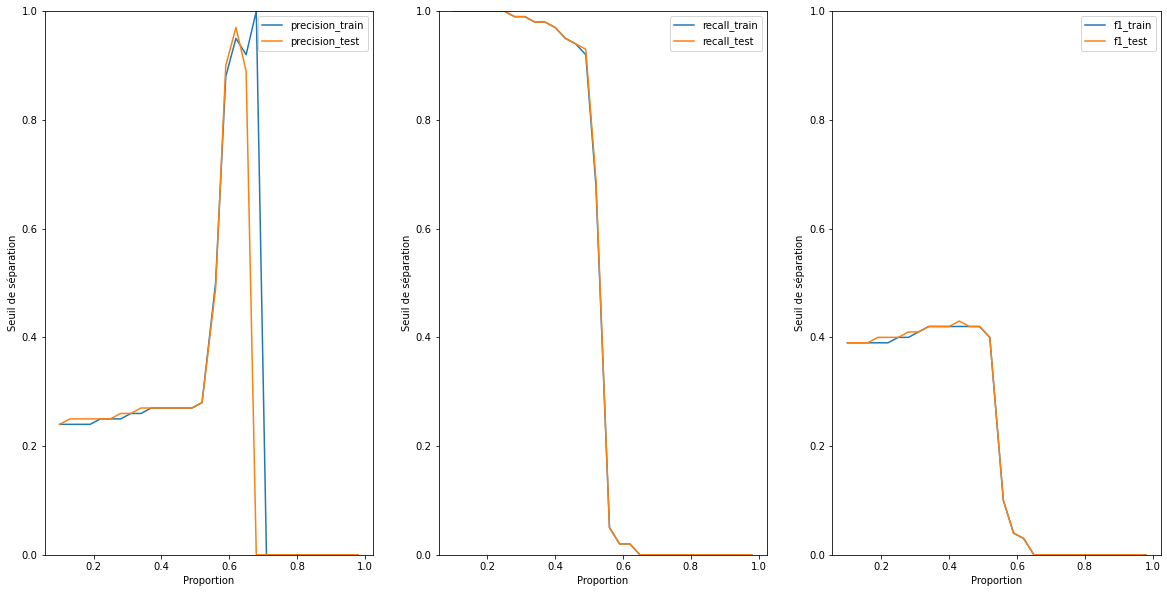

In [269]:
under_over_fitting([RF_model.predict_proba(x_train_disc),y_train_disc],[RF_model.predict_proba(x_test_disc),y_test_disc])

In [16]:
reg_log = LogisticRegression(penalty='l1', solver="saga", l1_ratio=0.3)

reg_log.fit(x_train_over, y_train_over)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(reg_log.score(x_test_over, y_test_over)))

y_pred = reg_log.predict(x_test_over)

print(classification_report(y_test_over,y_pred))

Accuracy of logistic regression classifier on test set: 0.67
              precision    recall  f1-score   support

           0       0.69      0.64      0.66    244377
           1       0.66      0.71      0.69    244946

    accuracy                           0.67    489323
   macro avg       0.68      0.67      0.67    489323
weighted avg       0.68      0.67      0.67    489323



In [31]:
scores = cross_val_score(reg_log,X_res_over,y_res_over, scoring='roc_auc', cv=10, n_jobs=-1)

In [32]:
scores

array([0.68312579, 0.7015777 , 0.70174088, 0.70193191,        nan,
       0.70124945, 0.7037601 ,        nan,        nan, 0.69980067])

In [36]:
u_pred = (reg_log.predict_proba(X_random_over)[:,1]>=0.45).astype(int)

#u_pred = reg_log.predict(X_train_disc)

print(classification_report(Y_random_over,u_pred))

print(confusion_matrix(Y_random_over,u_pred))

              precision    recall  f1-score   support

           0       0.97      0.52      0.68    815538
           1       0.12      0.82      0.21     66879

    accuracy                           0.54    882417
   macro avg       0.55      0.67      0.45    882417
weighted avg       0.91      0.54      0.64    882417

[[424886 390652]
 [ 12297  54582]]


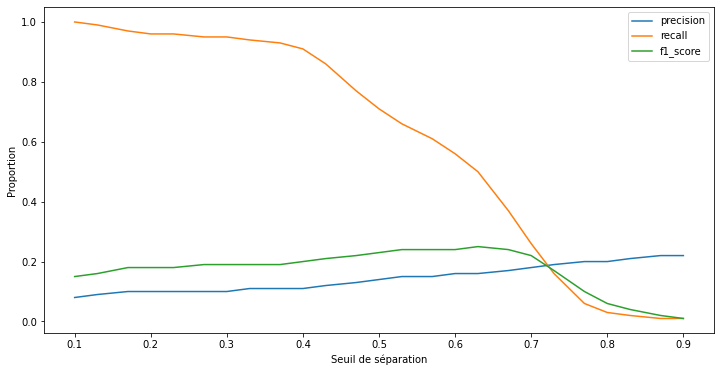

'La précision maximale est 0.22 pour le seuil de 0.87'

In [20]:
trace_indicateur(reg_log.predict_proba(X_random_over),Y_random_over)

## random Forest

In [24]:
RF_model=RandomForestClassifier(n_estimators=300,max_depth=15, max_features=15, max_leaf_nodes=30,
                                random_state=42,criterion="entropy", class_weight="balanced_subsample")

RF_model.fit(x_train_over, y_train_over)

print(f"L'AUC est de :{roc_auc_score(y_test_over, RF_model.predict(x_test_over))}\n\n")

y_pred = RF_model.predict(x_test_over)
                       
print(classification_report(y_test_over,y_pred)) 

L'AUC est de :0.6555647363512878


              precision    recall  f1-score   support

           0       0.68      0.60      0.63    244377
           1       0.64      0.72      0.68    244946

    accuracy                           0.66    489323
   macro avg       0.66      0.66      0.65    489323
weighted avg       0.66      0.66      0.65    489323



In [313]:
print(f"L'AUC est de :{roc_auc_score(y_test_random, RF_model.predict(x_test_random))}\n\n")

y_pred = RF_model.predict(x_test_random)
                       
print(classification_report(y_test_random,y_pred)) 

L'AUC est de :0.6563524502121159


              precision    recall  f1-score   support

           0       0.67      0.62      0.64     20116
           1       0.64      0.70      0.67     20012

    accuracy                           0.66     40128
   macro avg       0.66      0.66      0.66     40128
weighted avg       0.66      0.66      0.66     40128



In [271]:
u_pred = (RF_model.predict_proba(x_train_disc)[:,1]>=.6).astype(int)

print(classification_report(y_train_disc,u_pred))

print(confusion_matrix(y_train_disc,u_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86    147015
           1       0.70      0.03      0.05     46711

    accuracy                           0.76    193726
   macro avg       0.73      0.51      0.46    193726
weighted avg       0.75      0.76      0.67    193726

[[146453    562]
 [ 45390   1321]]


In [273]:
u_pred = (RF_model.predict_proba(x_test_disc)[:,1]>=.54).astype(int)

print(classification_report(y_test_disc,u_pred))

print(confusion_matrix(y_test_disc,u_pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84     62858
           1       0.38      0.14      0.20     20168

    accuracy                           0.74     83026
   macro avg       0.58      0.53      0.52     83026
weighted avg       0.68      0.74      0.69     83026

[[58387  4471]
 [17402  2766]]


In [267]:
u_pred = (RF_model.predict_proba(X_train_disc)[:,1]>=.6).astype(int)

print(classification_report(Y_train_disc,u_pred))

print(confusion_matrix(Y_train_disc,u_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    815538
           1       0.78      0.02      0.03     66879

    accuracy                           0.93    882417
   macro avg       0.85      0.51      0.50    882417
weighted avg       0.91      0.93      0.89    882417

[[815202    336]
 [ 65684   1195]]


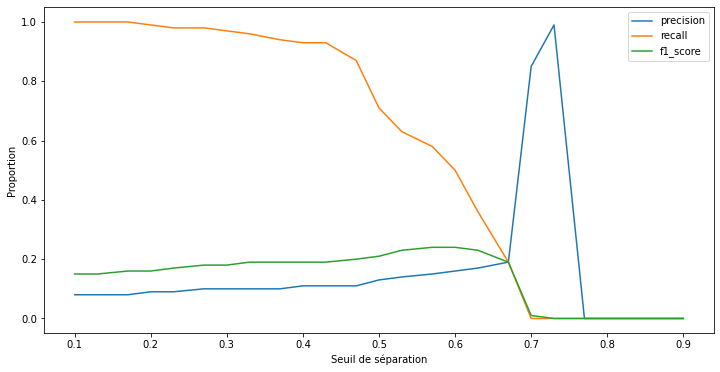

'La précision maximale est 0.99 pour le seuil de 0.73'

In [25]:
trace_indicateur(RF_model.predict_proba(X_random_over),Y_random_over)

In [315]:
Random_forest = RandomForestClassifier()

parametre = {'n_estimators' : [150, 200,250,350,400,500],
            'max_features' : [10,15,20,24,30,35],
             "min_samples_leaf" : [.1,.2,.5,.6],
             "max_depth" : [10,15,20,24,30,35],
             "criterion": ["gini","entropy","log_loss"],
             "class_weight":["balanced", "balanced_subsample",None]
            }

optimal_params =GridSearchCV(
        Random_forest, 
        parametre,
        cv=5,
        verbose=0
    ,scoring='accuracy'
    )

optimal_params.fit(x_train_random,y_train_random)

print(optimal_params.best_params_)


KeyboardInterrupt

